In [2]:
import pandas as pd, numpy as np, missingno as msno, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import shapiro, kstest, chi2_contingency, pearsonr, pointbiserialr, spearmanr
from xgboost import XGBClassifier

import warnings

warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
submission_format = pd.read_csv("dataset/sample_submission.csv")

## EDA

#### Cek missing value

**Cek jumlah missing value per kolom**

In [63]:
train.isnull().sum()

Latitude                 3610
Longitude                7073
Station Code             5360
Depth                    4445
Parameter Code           1697
Analysis Method Code    11597
Value Flags             11828
Data Quality                0
Dataset_Source           6212
temperature_avg          4517
rainfall_mm              5174
humidity_pct              849
pressure_hPa             6814
drought_index            5979
extreme_precip_days      2023
urban_pct                1889
forest_pct               1831
agriculture_pct          2620
water_pct                4017
wetland_pct              3418
grassland_pct            2574
barren_pct               4558
frag_index               1569
soil_perm                2542
ind_count                2974
hg_impact                3535
pb_impact                5667
ind_risk_score           1953
param_category           3924
country_code             4432
time_season               980
value_with_unit          4499
sampling_method          1788
is_referen

**Cek apakah di kolom boolean ada missing value**

In [64]:
train.isnull().values.any()

np.True_

**Cek total keseluruhan missing value**

In [65]:
train.isnull().sum().sum()

np.int64(166174)

**Cek persentase total missing value per kolom**

In [66]:
missing_percent = train.isnull().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)
print(missing_percent_sorted)

Value Flags             84.497785
Analysis Method Code    82.847550
Longitude               50.528647
pressure_hPa            48.678383
analytical_program      48.499786
water_body_type         47.392485
Dataset_Source          44.377768
drought_index           42.713245
pollution_risk          41.420203
pb_impact               40.484355
Station Code            38.291184
rainfall_mm             36.962423
sampling_weather        35.826547
barren_pct              32.561795
temperature_avg         32.268896
value_with_unit         32.140306
Depth                   31.754536
country_code            31.661666
water_pct               28.696957
param_category          28.032576
Latitude                25.789398
hg_impact               25.253608
regulatory_framework    24.910702
wetland_pct             24.417774
ind_count               21.245892
agriculture_pct         18.716960
testing_laboratory      18.409773
grassland_pct           18.388341
soil_perm               18.159737
extreme_precip

**Cek baris mana saja yang berisi missing value**

In [67]:
train[train.isnull().any(axis=1)]

Latitude  Longitude Station Code  Depth Parameter Code  \
0      50.902800        NaN     CAN00062    NaN             OH   
1            NaN        NaN          NaN    0.3            NaN   
2      46.271170   11.42484     ITA00304    0.0            NaN   
3      49.458600 -120.50400     CAN00328    0.3         Cs-Tot   
4      49.527900 -115.54920     CAN00204    0.3         Li-Tot   
...          ...        ...          ...    ...            ...   
13993  42.010000        NaN          NaN    0.0         Cr-Dis   
13994  26.766389        NaN     IND02371    NaN     O2-Dis-Sat   
13995  47.851690   13.80288     AUT00260    NaN     O2-Dis-Sat   
13996  43.570520        NaN          NaN    0.0            NaN   
13997  49.664300 -114.90410     CAN00164    0.3            NaN   

      Analysis Method Code Value Flags Data Quality Dataset_Source  \
0                  VMV_351         NaN         Fair            NaN   
1                      NaN         NaN         Fair         carbon   
2            APAT3200_2003           <         Fair        mercury   
3                 VMV_3528         NaN         Fair        caesium   
4                 VMV_1919         NaN         Good        lithium   
...                    ...         ...          ...            ...   
13993                  NaN         NaN         Fair       chromium   
13994                  NaN         NaN      Unknown  dissolved_gas   
13995                  NaN         NaN         Fair            NaN   
13996                  NaN         NaN         Fair       hardness   
13997             VMV_3529           <         Good      berillium   

       temperature_avg  ...    sampling_method  is_referenced_method  \
0                  NaN  ...                NaN                 False   
1                  NaN  ...   Composite Sample                  True   
2            -5.702201  ...        Grab Sample                   NaN   
3             6.250698  ...   Composite Sample                 False   
4            -9.855316  ...      Manual Sample                 False   
...                ...  ...                ...                   ...   
13993        12.236726  ...      Manual Sample                  True   
13994              NaN  ...                NaN                 False   
13995        14.084927  ...                NaN                 False   
13996        10.435863  ...  Field Measurement                  True   
13997              NaN  ...      Manual Sample                 False   

       water_body_type              analytical_program  pollution_risk  \
0              Wetland           Provincial Monitoring          Medium   
1                  NaN                             NaN             Low   
2                  NaN                             NaN             NaN   
3            Reservoir                             NaN             NaN   
4                River                             NaN          Medium   
...                ...                             ...             ...   
13993             Lake  International Water Assessment          Medium   
13994           Stream  International Water Assessment          Medium   
13995          Estuary                             NaN             NaN   
13996              NaN                             NaN             NaN   
13997      Groundwater                             NaN             Low   

                    testing_laboratory  validated_results  sampling_weather  \
0       National Water Research Center              False             Snowy   
1                                  NaN               True               NaN   
2      International Water Quality Lab               True               NaN   
3         Canadian Analytical Services               True             Rainy   
4       National Water Research Center               True               NaN   
...                                ...                ...               ...   
13993  International Water Quality Lab               True          

**Cek visualisasi missing value**

<Axes: >

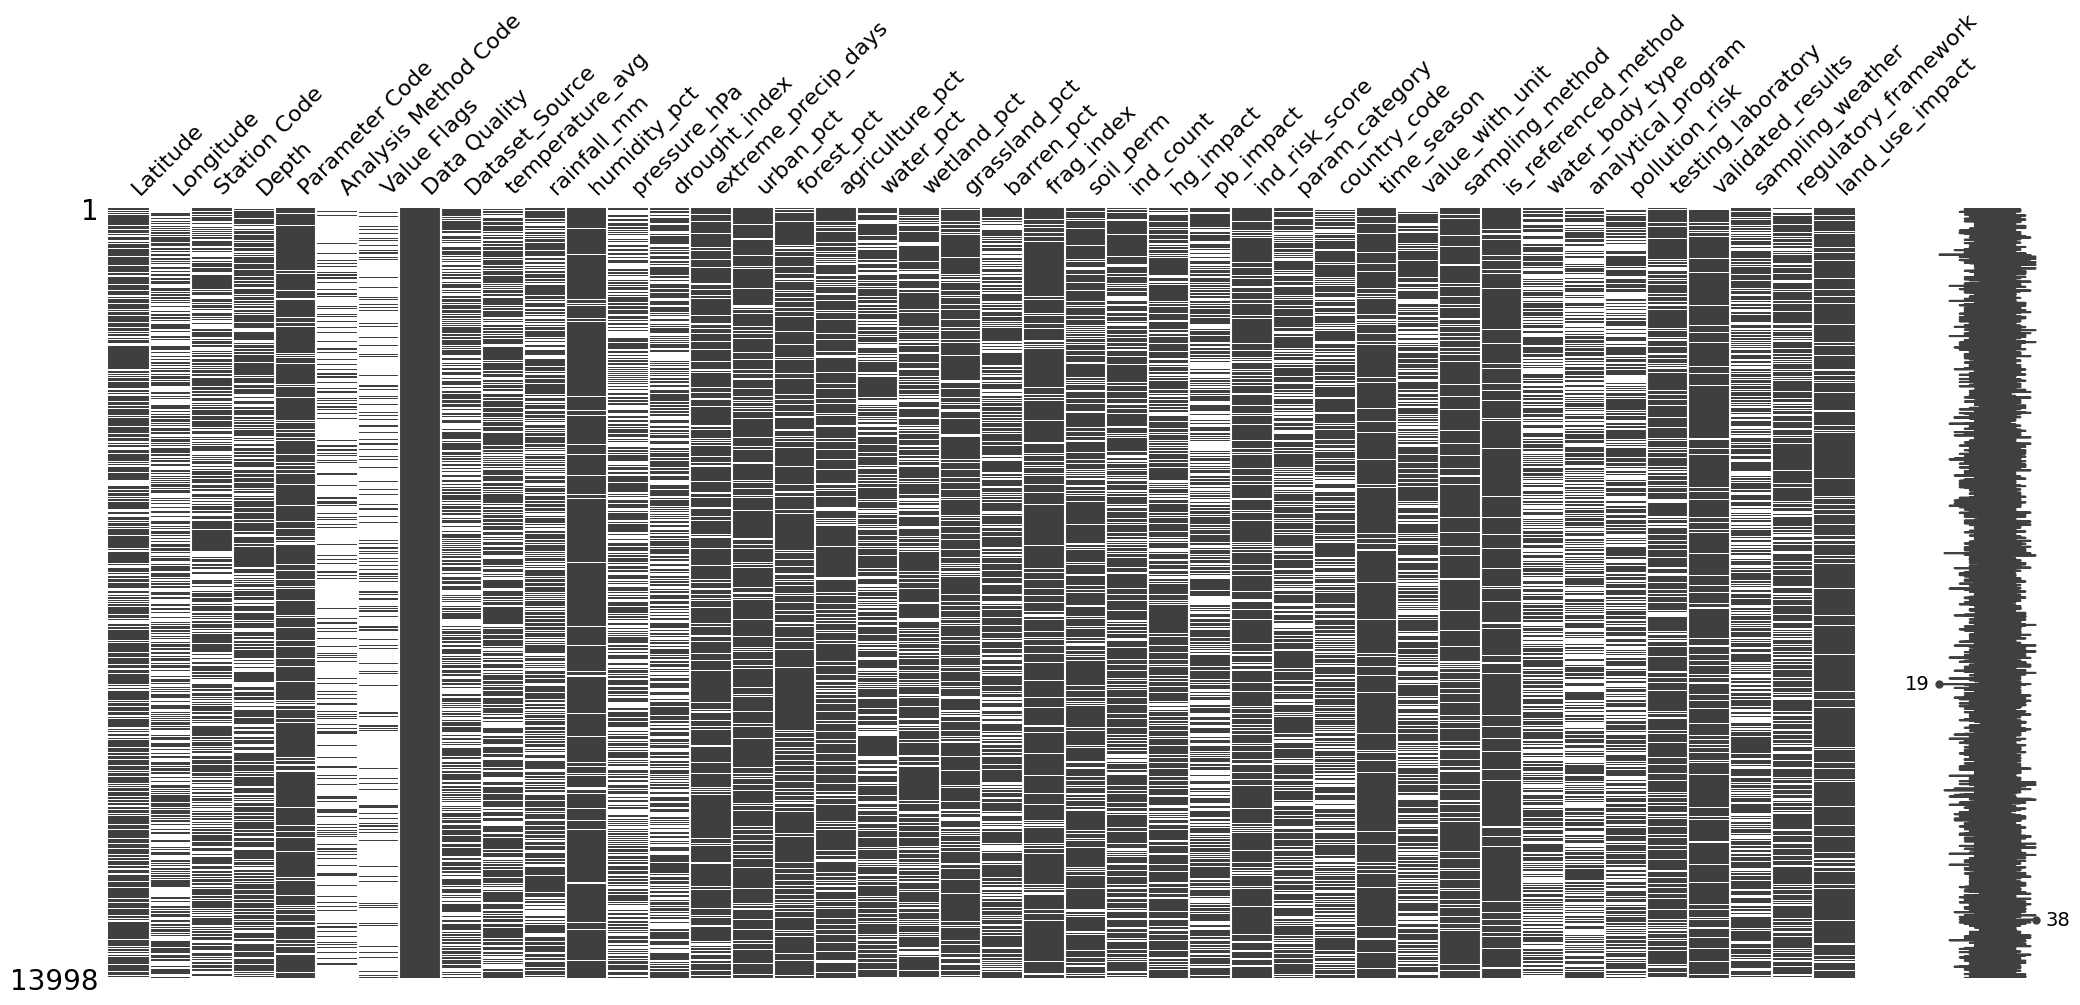

In [68]:
msno.matrix(train)

#### Cek distribusi data

##### **Cek statistik deskriptif dasar**

In [69]:
train.describe()

Latitude    Longitude        Depth  temperature_avg  rainfall_mm  \
count  10388.000000  6925.000000  9553.000000      9481.000000  8824.000000   
mean      35.436061   -27.693376     0.456213         6.824907    80.873508   
std       16.219775    75.700544     5.159160        10.630105    28.561500   
min      -51.688333  -162.882936     0.000000       -22.621346    15.497462   
25%       21.394603  -100.809745     0.300000        -1.068542    57.891712   
50%       36.339265    -6.649400     0.300000         7.007714    78.730045   
75%       49.148500    21.982860     0.300000        14.660102   101.413967   
max       81.842880    96.170556   300.000000        32.337238   201.615502   

       humidity_pct  pressure_hPa  drought_index  extreme_precip_days  \
count  13149.000000   7184.000000    8019.000000         11975.000000   
mean      80.595012   1008.435708       0.006299             1.272735   
std        8.839679      3.688106       1.158943             1.355884   
min       49.146679    995.417479      -1.998474             0.000000   
25%       74.117278   1005.858214      -1.001138             0.000000   
50%       80.307203   1008.512444       0.014264             1.000000   
75%       87.432189   1010.999508       1.021632             2.000000   
max       95.000000   1022.112516       1.999635             9.000000   

          urban_pct  ...    water_pct   wetland_pct  grassland_pct  \
count  12109.000000  ...  9981.000000  10580.000000   11424.000000   
mean       9.185385  ...     6.608126      8.297825      12.331256   
std        3.373840  ...     2.659858      1.620872       3.779209   
min        0.257167  ...     1.826344      2.767104       2.864197   
25%        6.513480  ...     4.500750      7.406341       9.045556   
50%        9.331719  ...     6.134553      8.363030      12.180642   
75%       11.976079  ...     8.215836      9.257593      15.631952   
max       17.700829  ...    14.306060     13.365626      22.773705   

        barren_pct    frag_index     soil_perm     ind_count     hg_impact  \
count  9440.000000  12429.000000  11456.000000  11024.000000  10463.000000   
mean      5.015210      0.737440      0.584229      0.430062      0.166358   
std       1.431305      0.049427      0.023127      0.894309      1.460679   
min       0.782129      0.592426      0.518350      0.000000      0.000000   
25%       4.129750      0.699000      0.565790      0.000000      0.000000   
50%       5.044905      0.743271      0.582249      0.000000      0.000000   
75%       6.044761      0.774717      0.603042      1.000000      0.020725   
max       8.963669      0.873797      0.650025      7.000000     62.146841   

         pb_impact  ind_risk_score  
count  8331.000000    12045.000000  
mean      0.174060        1.379598  
std       1.725642        4.047634  
min       0.000000        0.000000  
25%       0.000000        0.000000  
50%       0.000000        0.000000  
75%       0.024444        0.351765  
max     100.000000       47.513133  

[8 rows x 22 columns]

##### **Cek histogram tiap kolom**

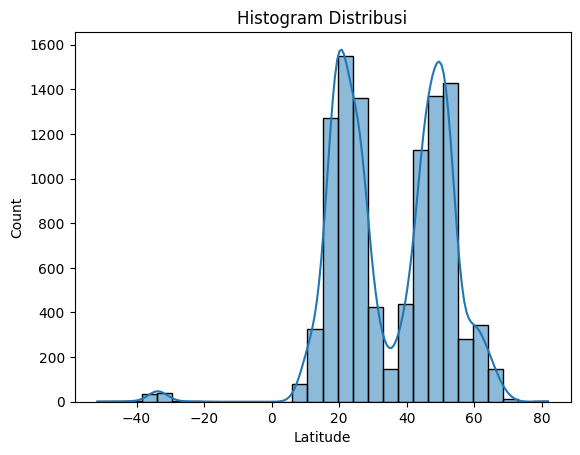

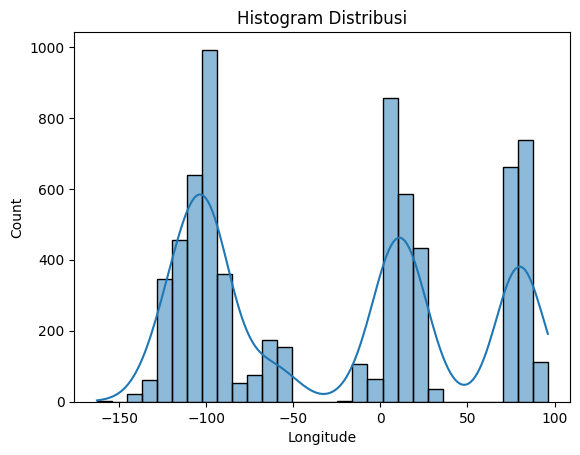

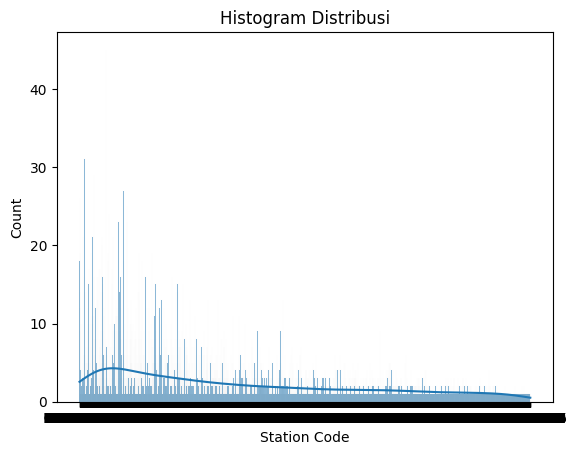

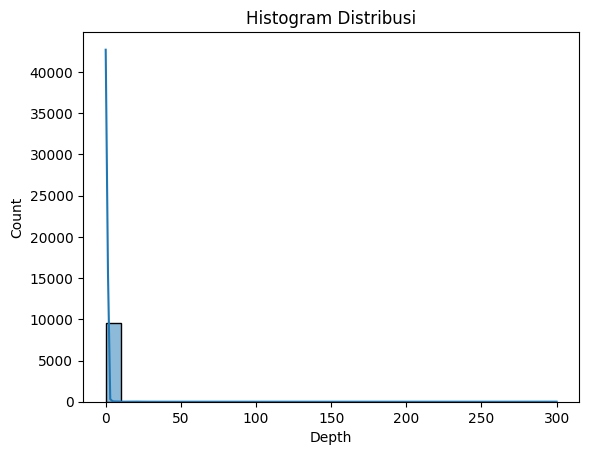

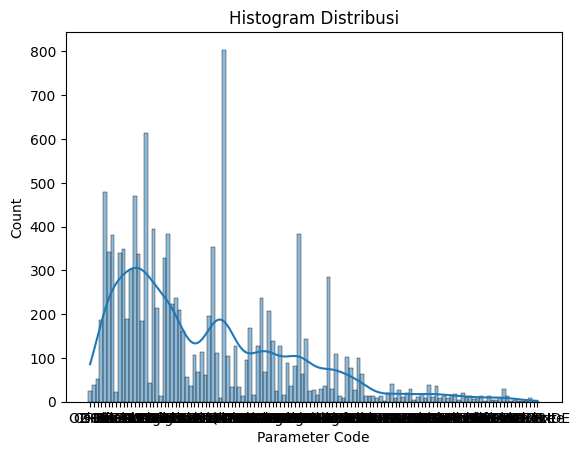

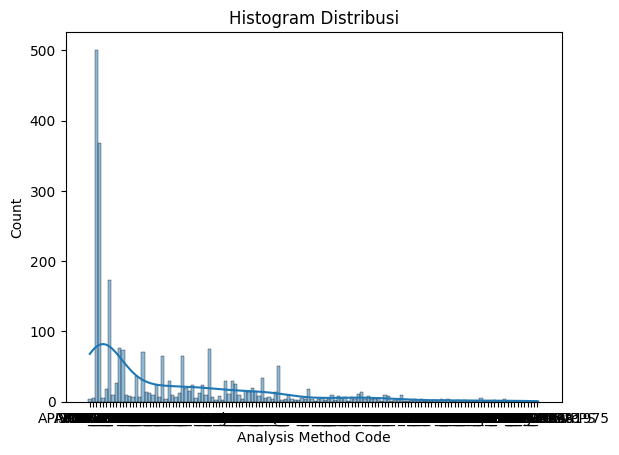

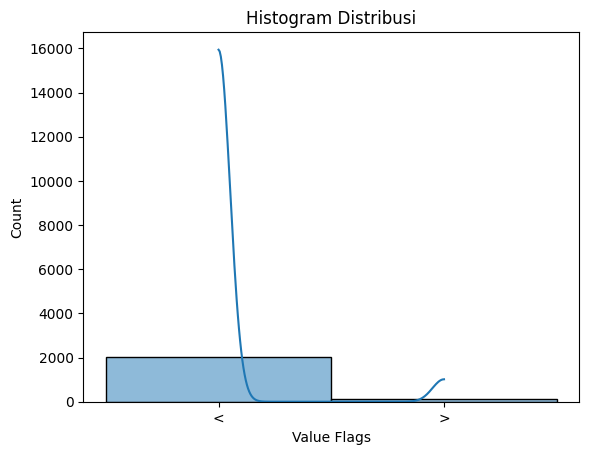

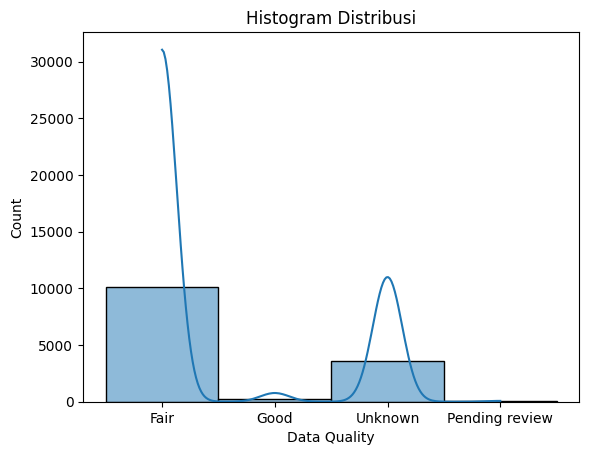

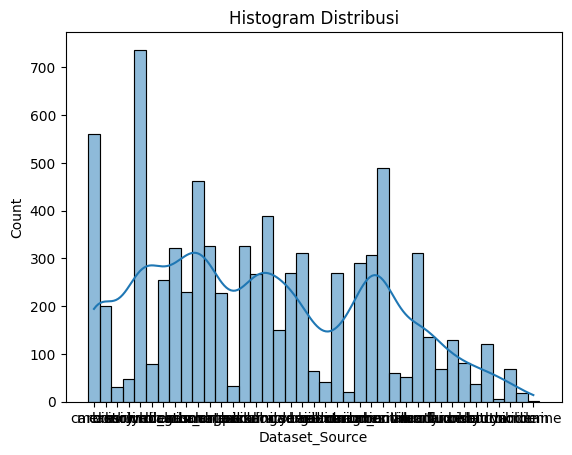

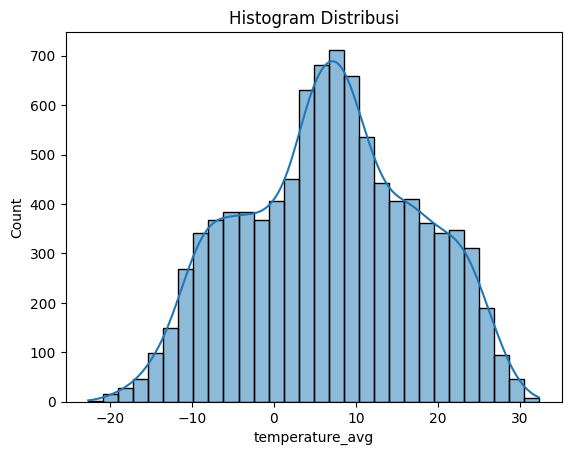

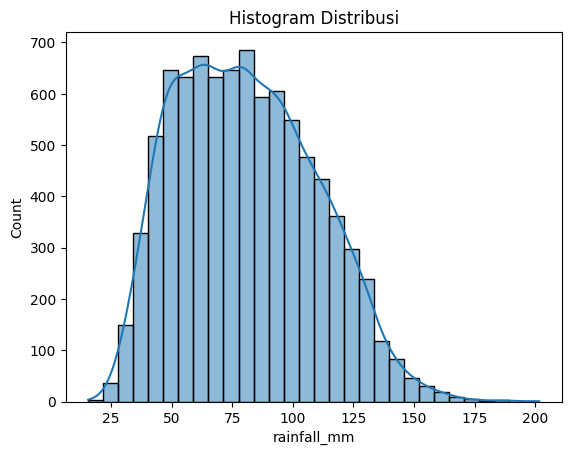

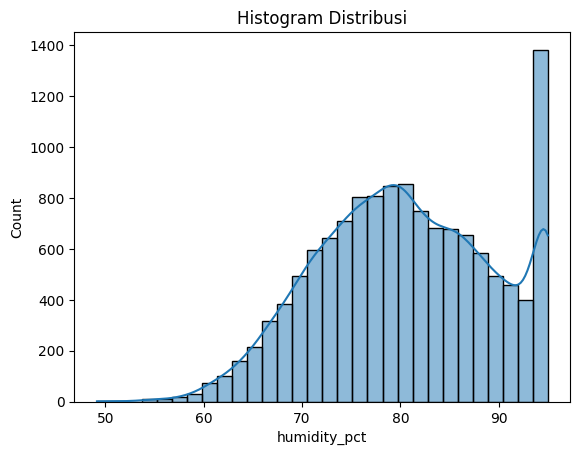

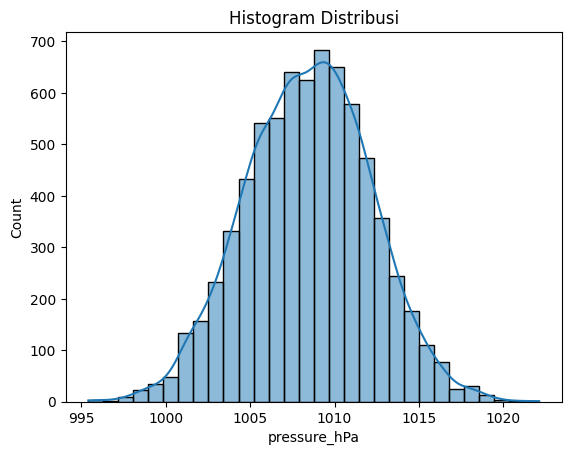

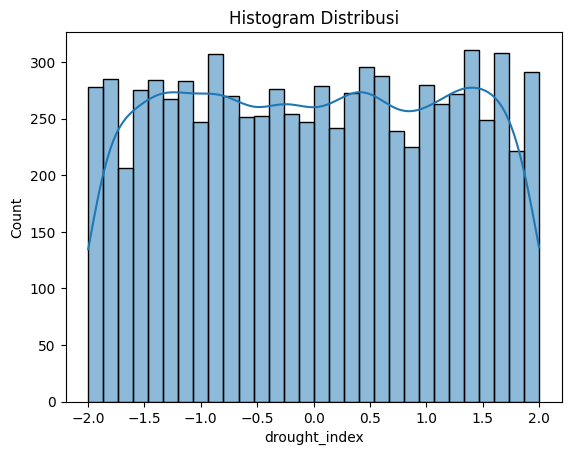

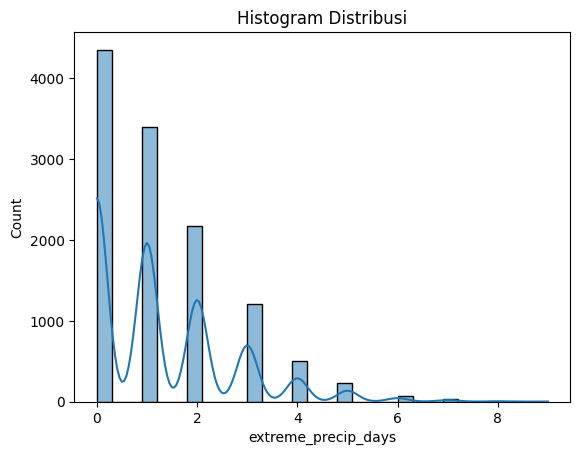

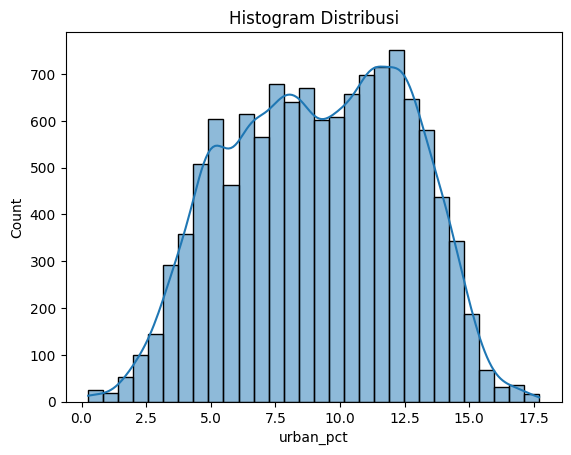

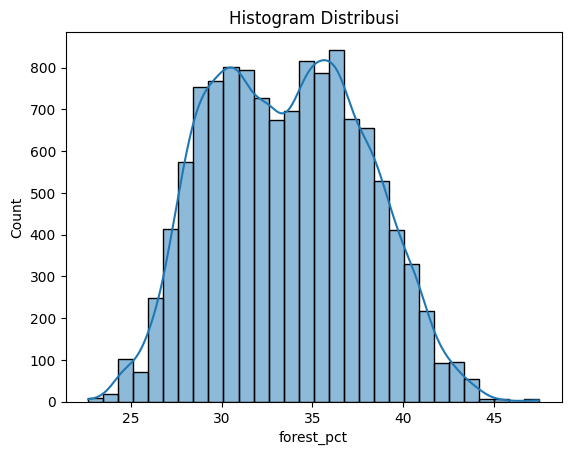

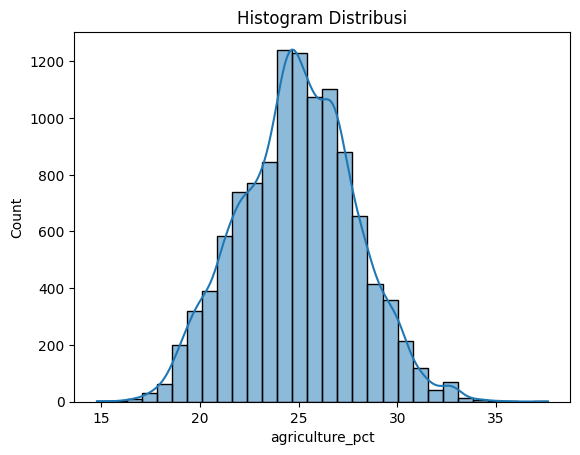

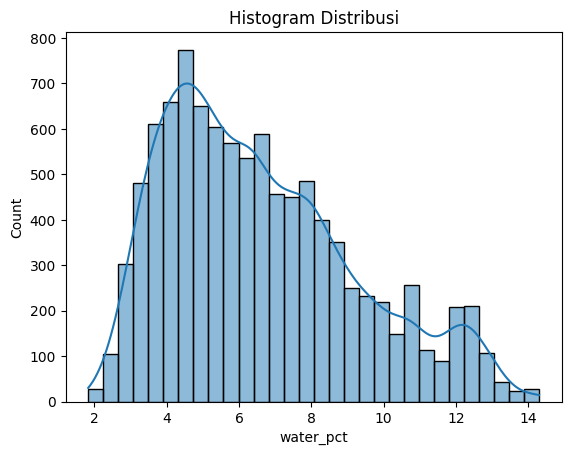

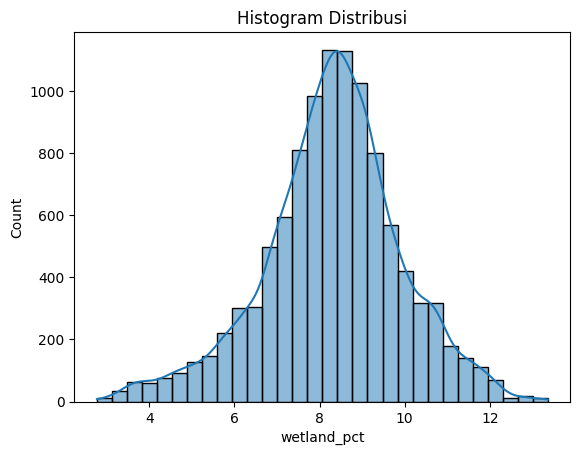

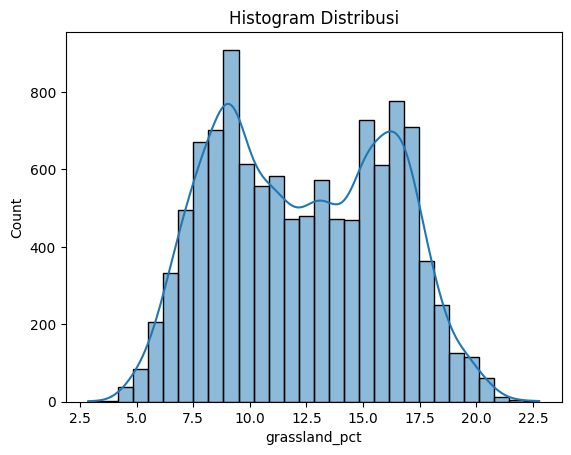

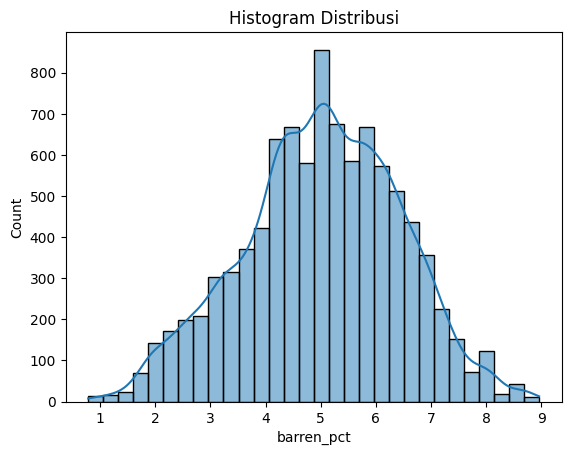

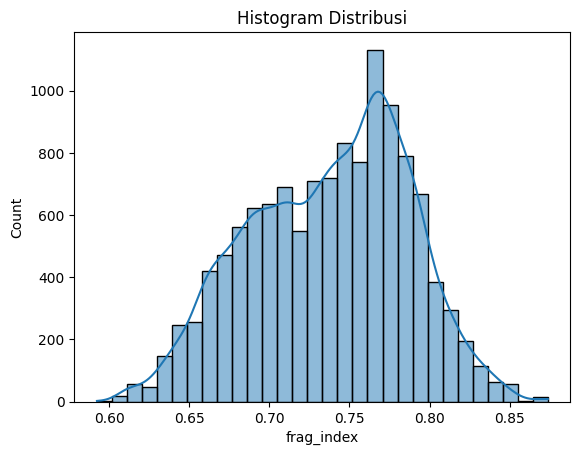

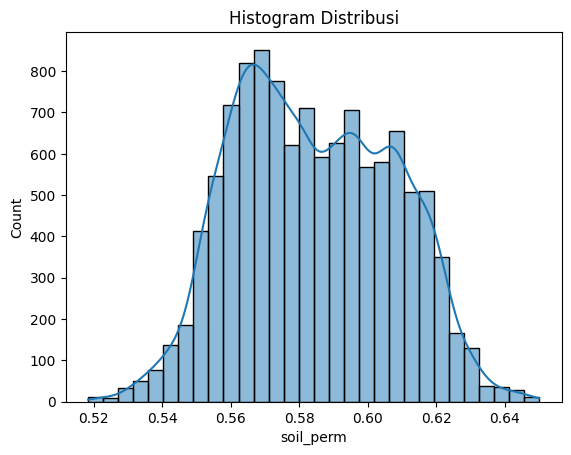

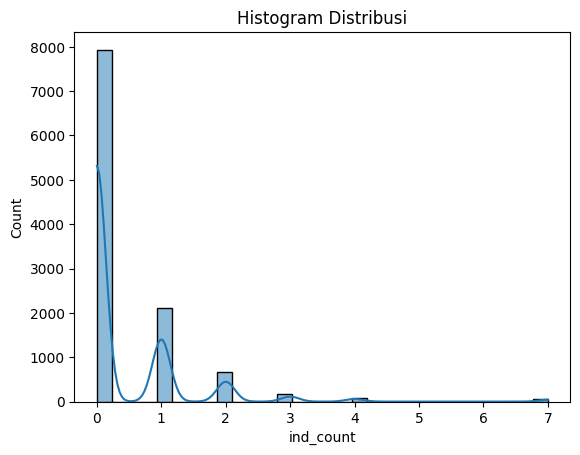

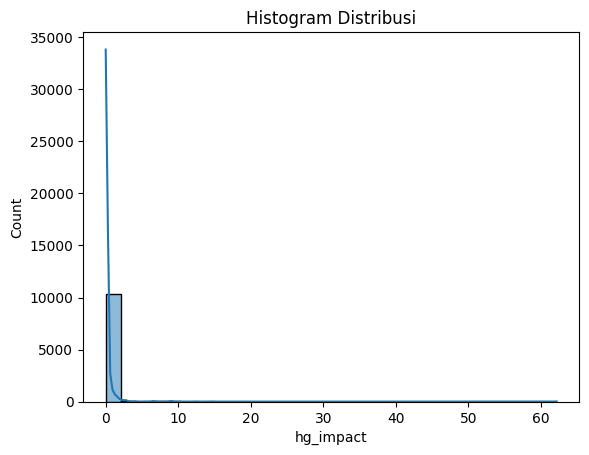

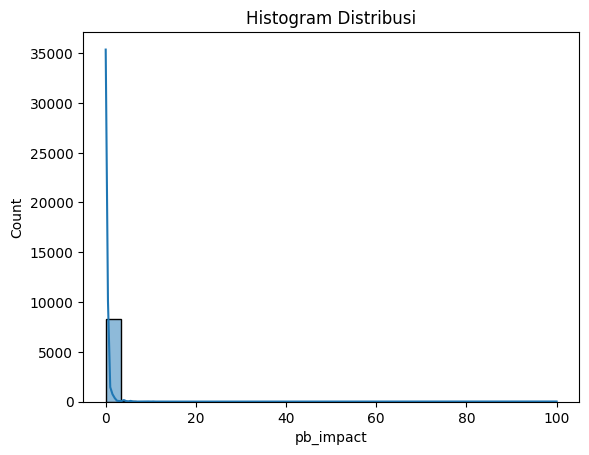

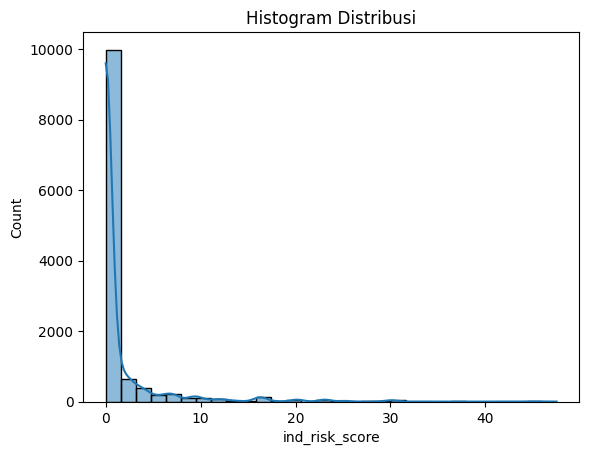

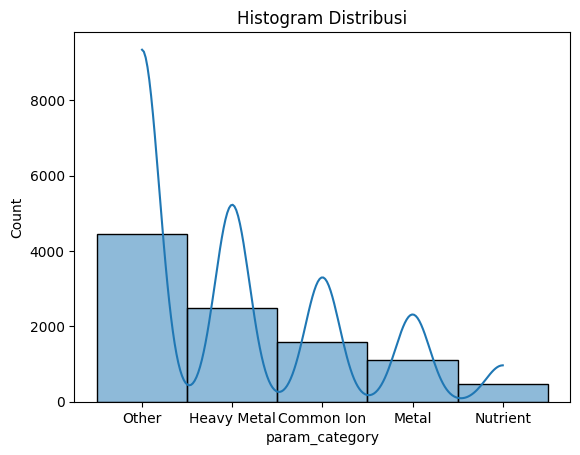

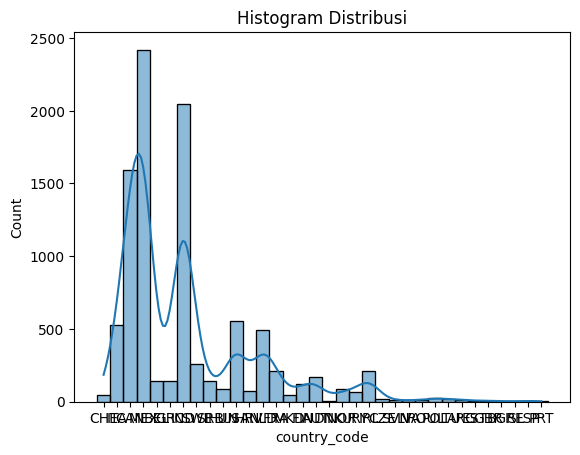

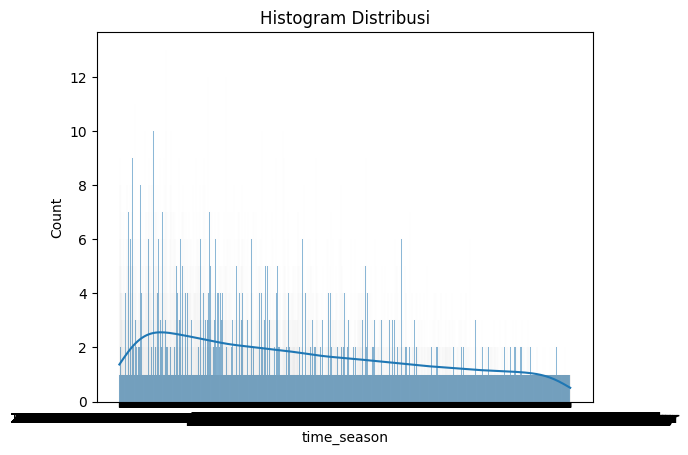

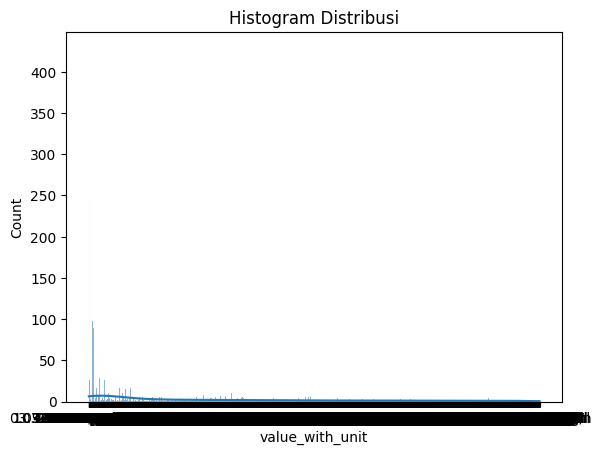

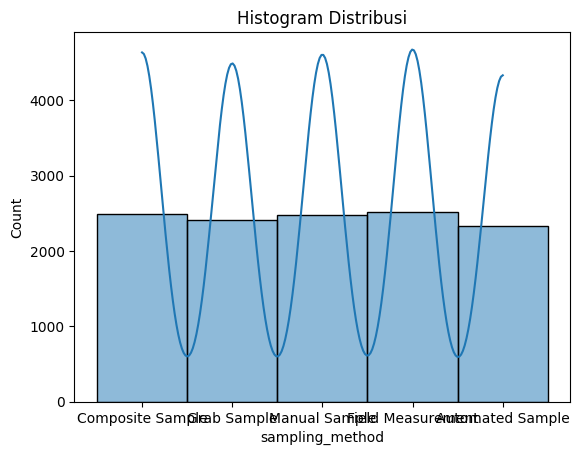

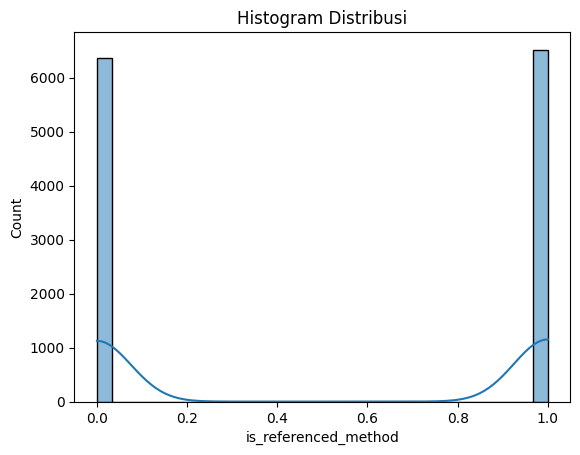

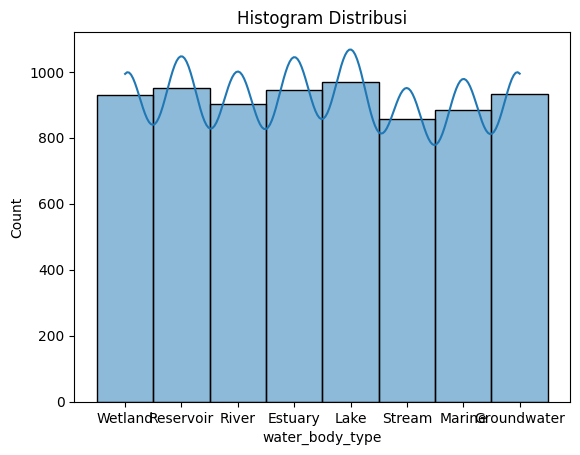

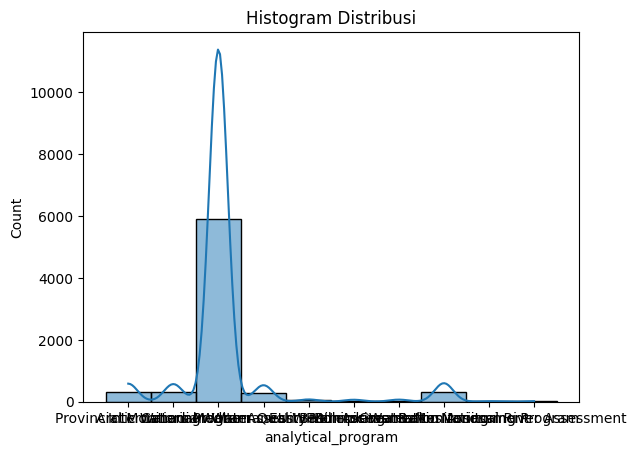

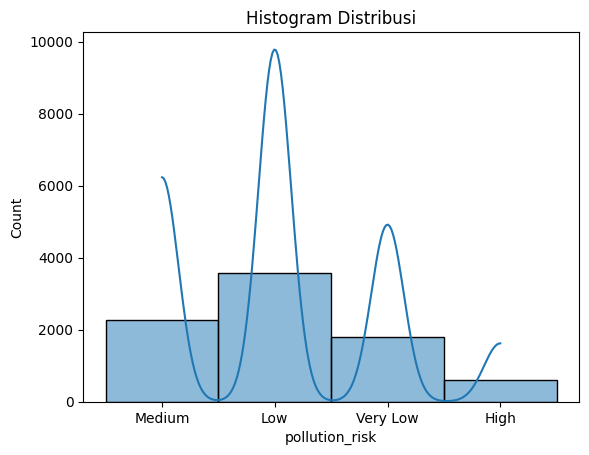

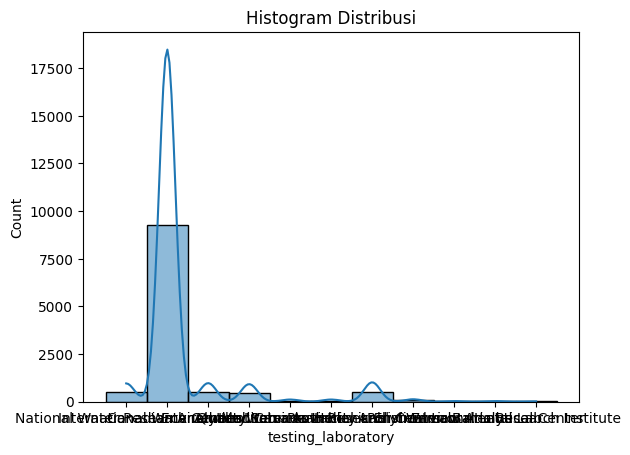

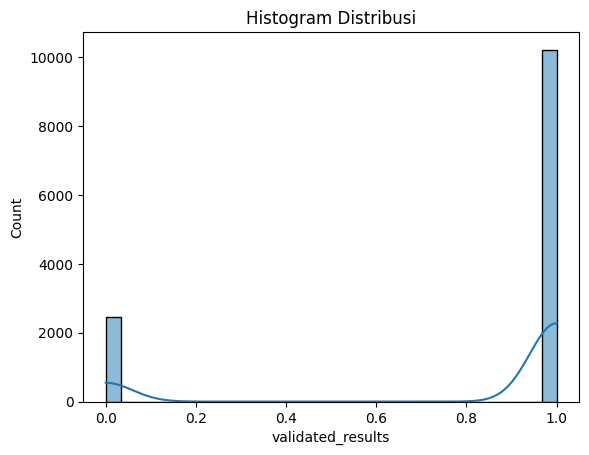

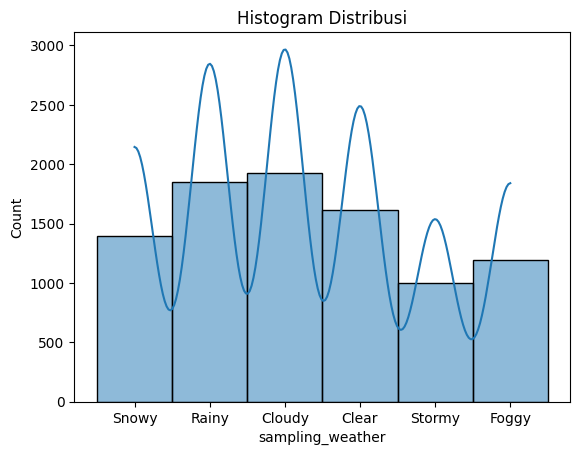

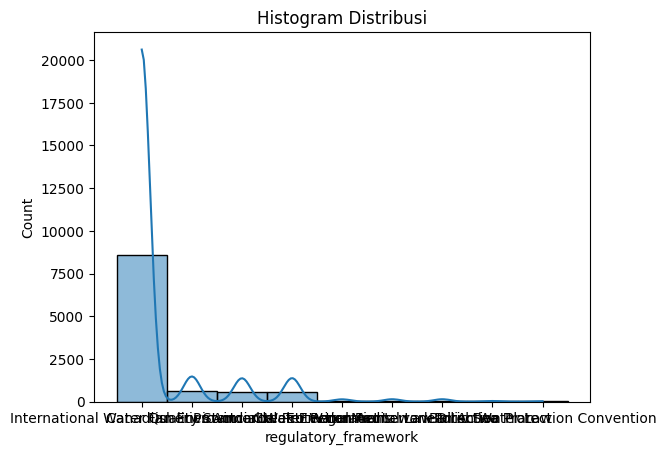

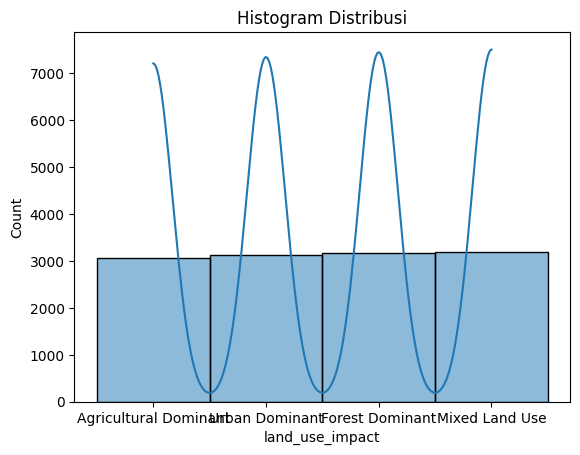

In [70]:
for i in train:
    sns.histplot(train[f'{i}'], kde=True, bins=30)
    plt.title('Histogram Distribusi')
    plt.show()

##### **Cek menggunakan boxplot**

Untuk mendeteksi sebaran data, outlier, dan simetri/skewness secara visual.

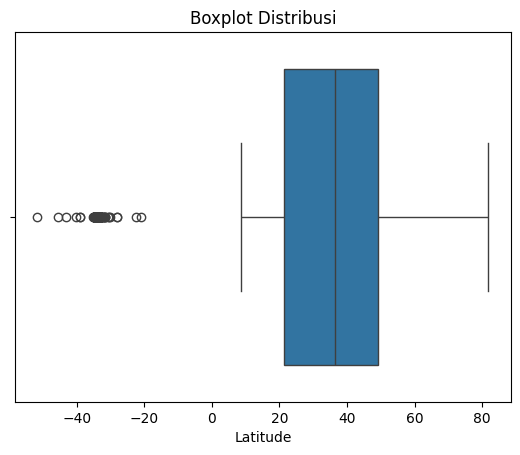

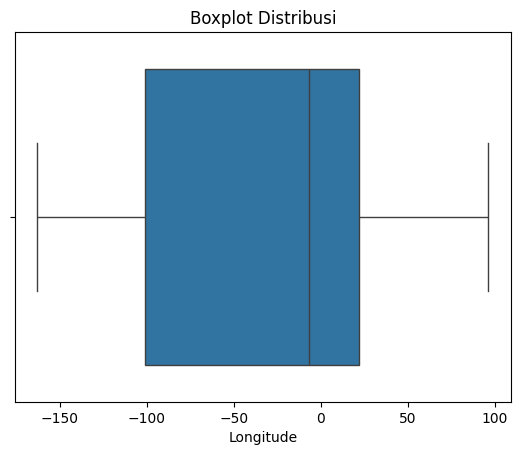

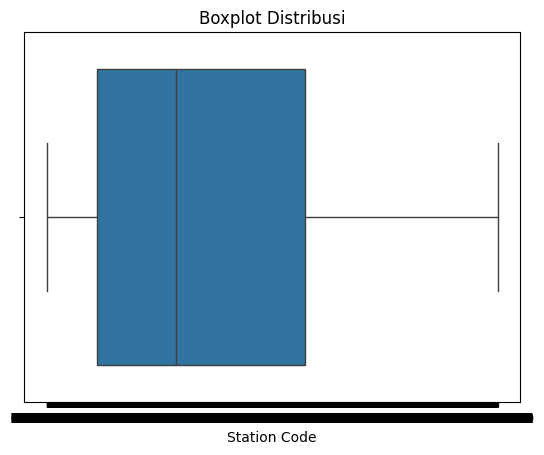

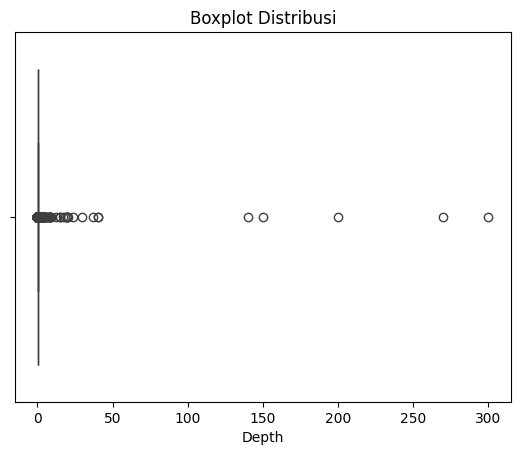

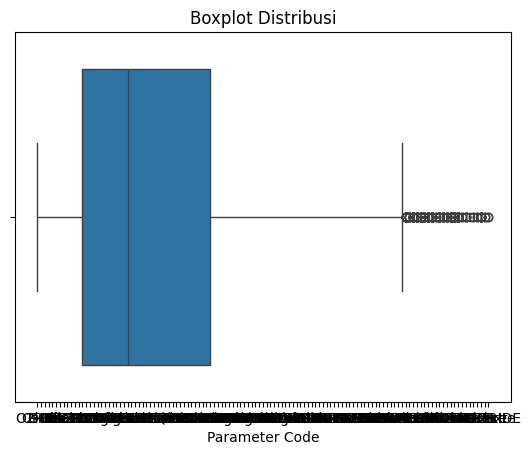

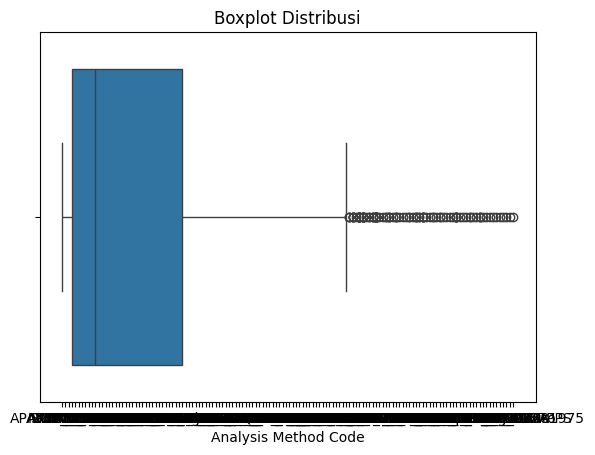

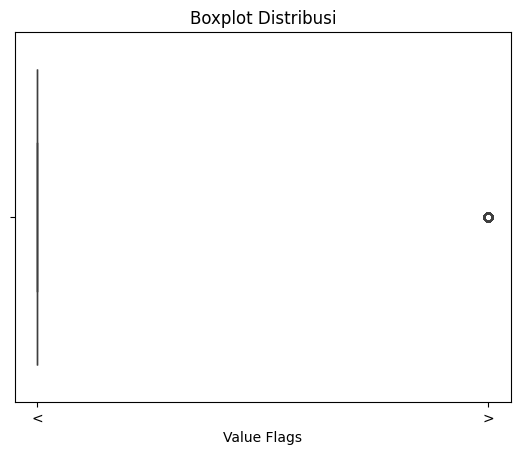

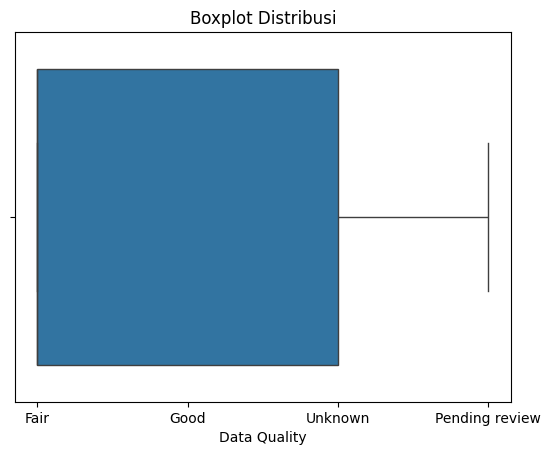

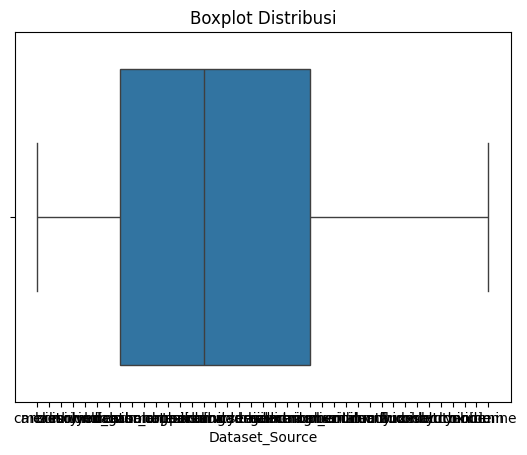

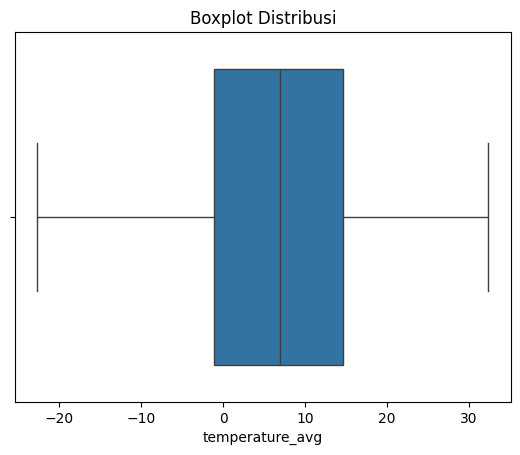

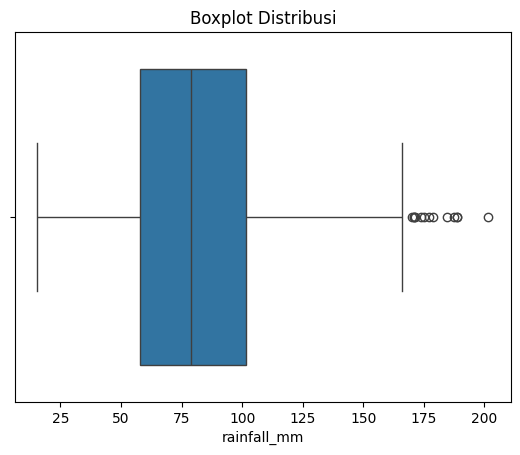

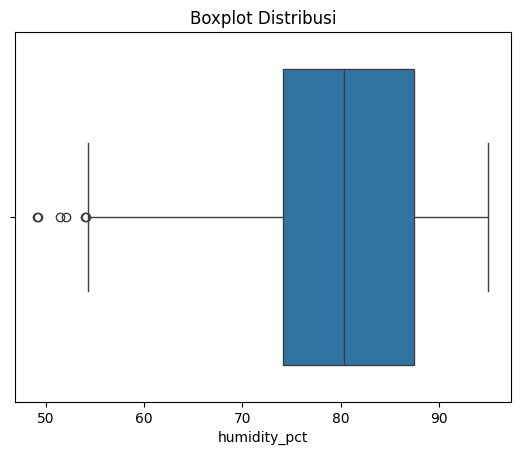

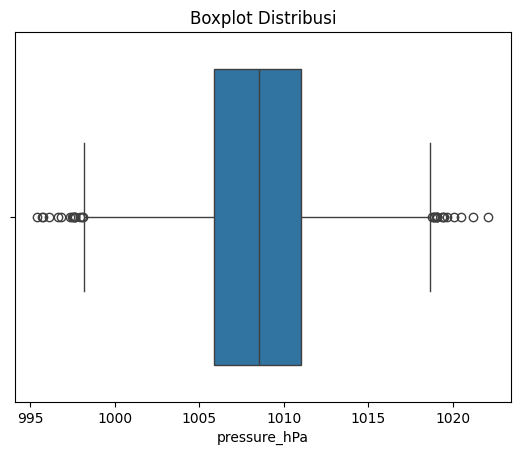

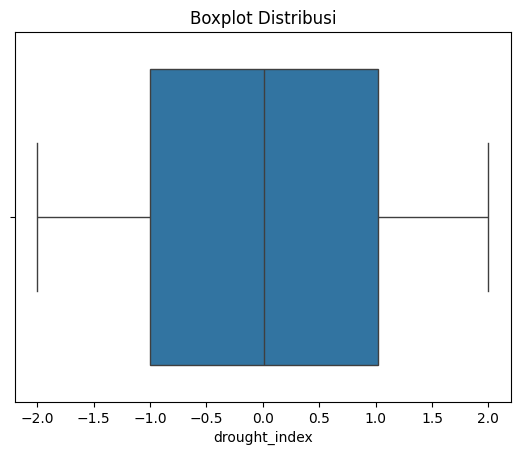

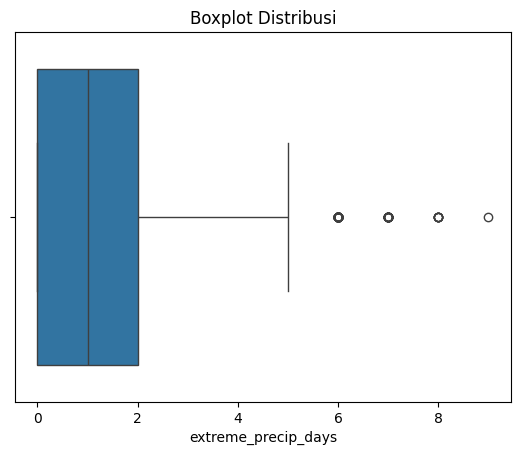

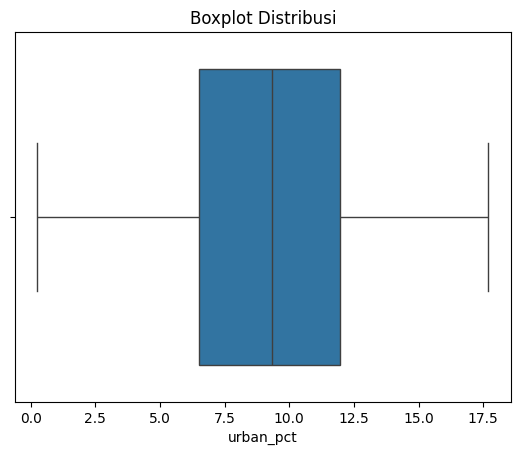

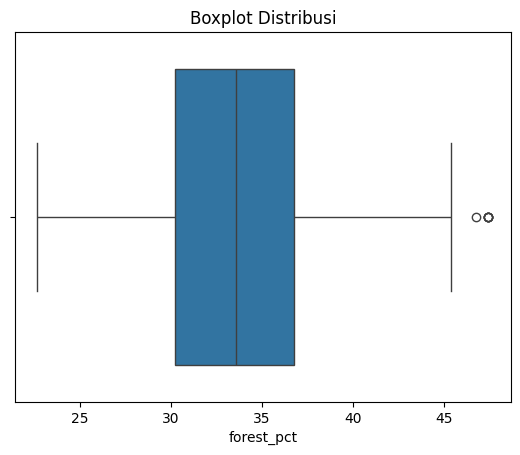

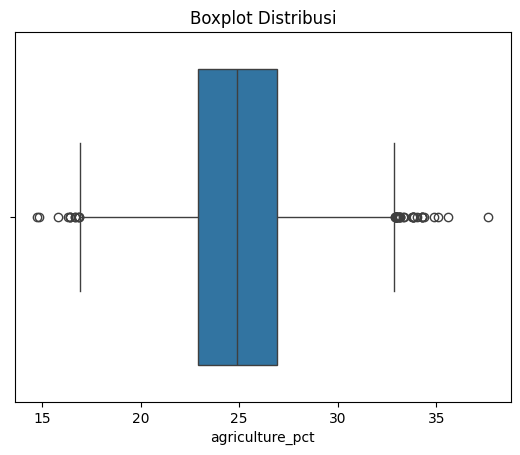

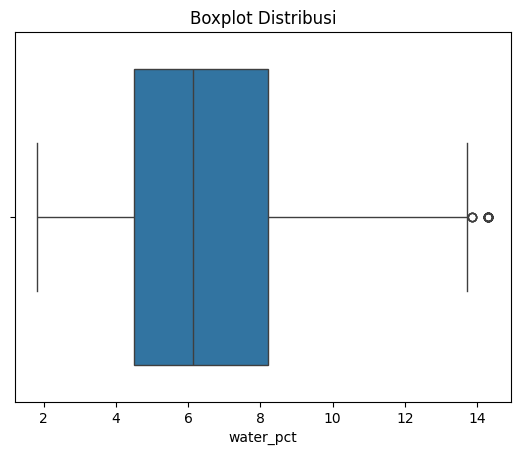

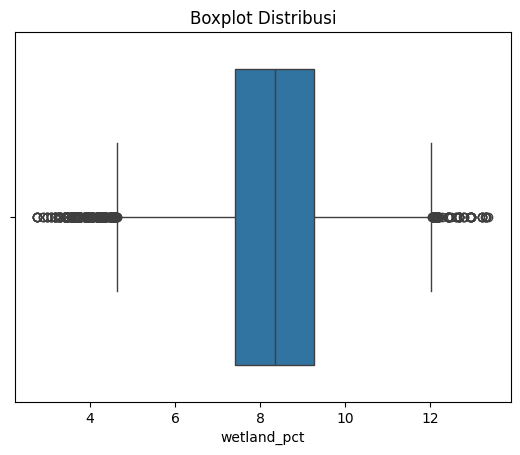

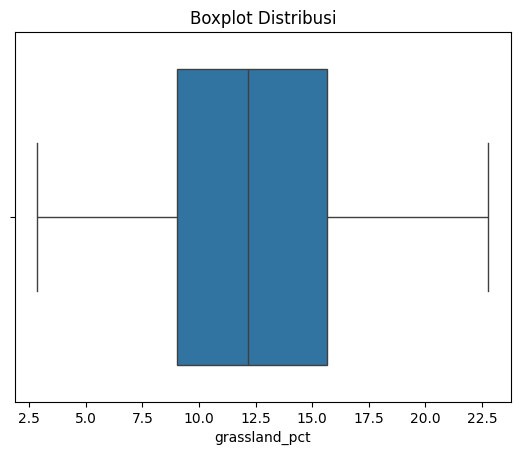

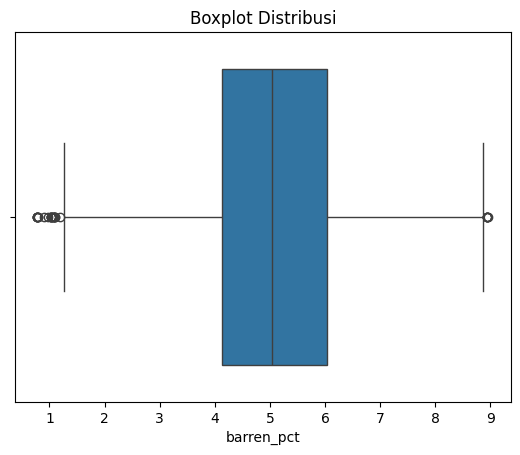

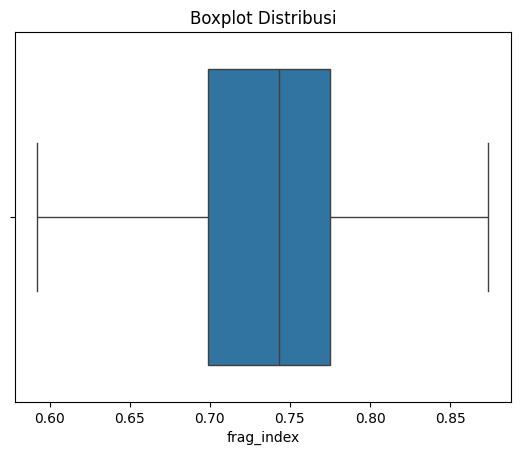

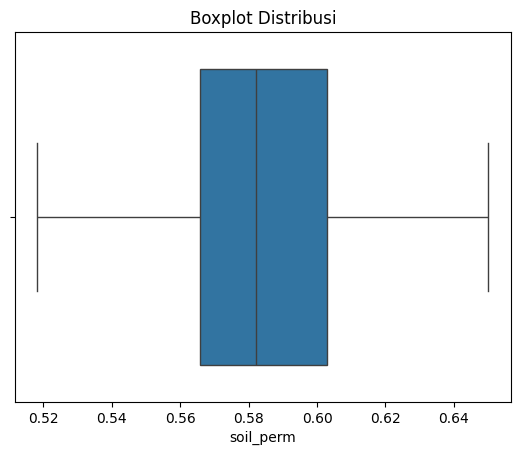

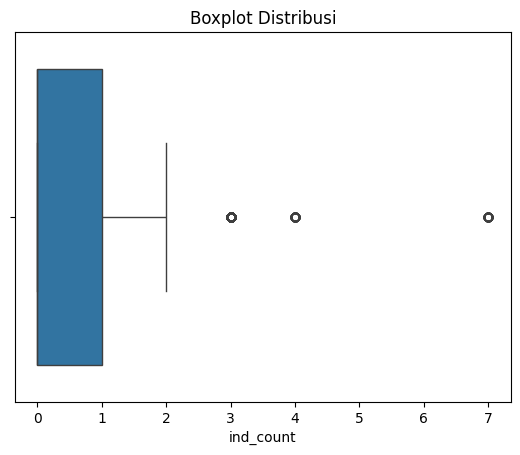

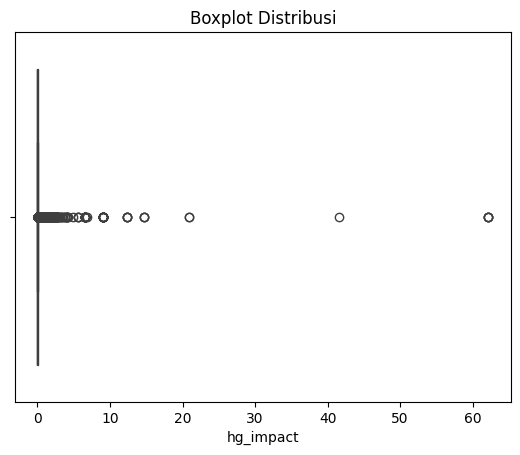

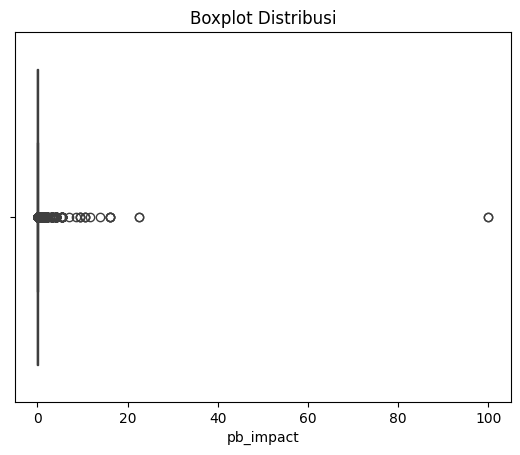

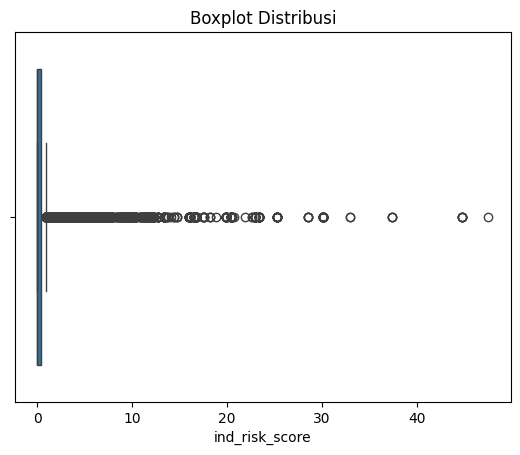

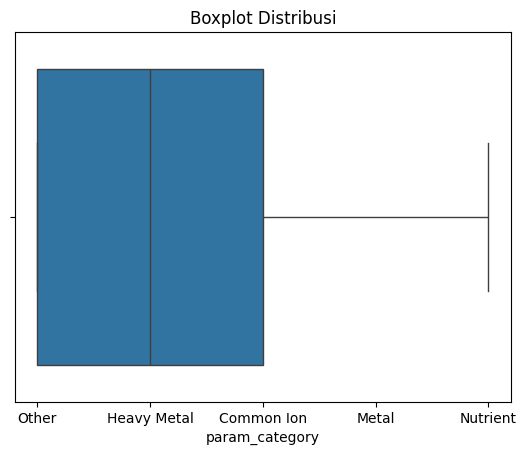

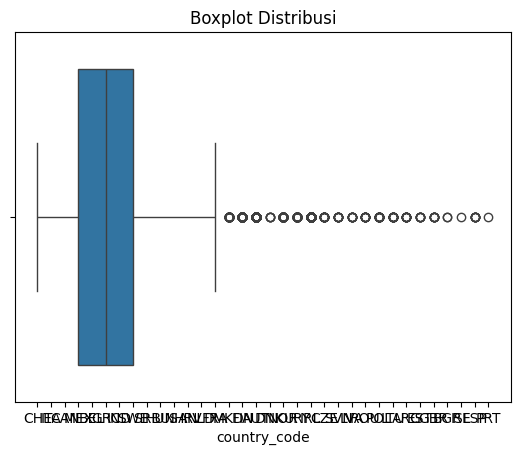

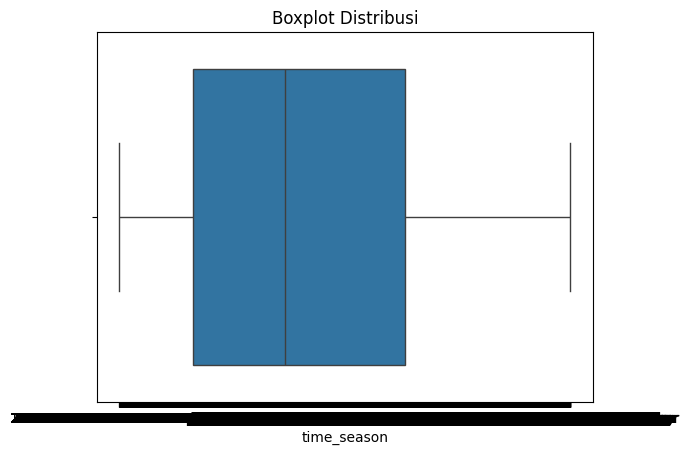

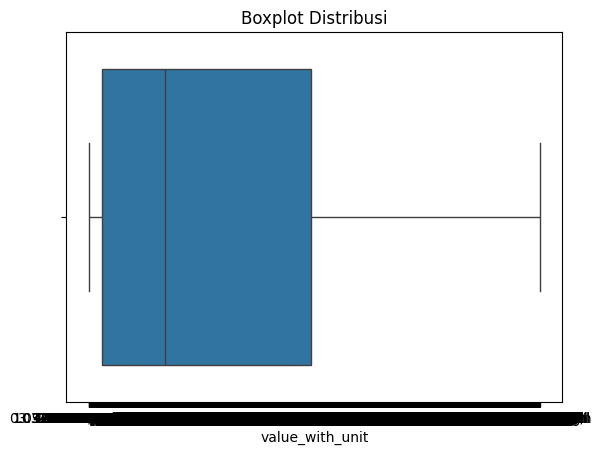

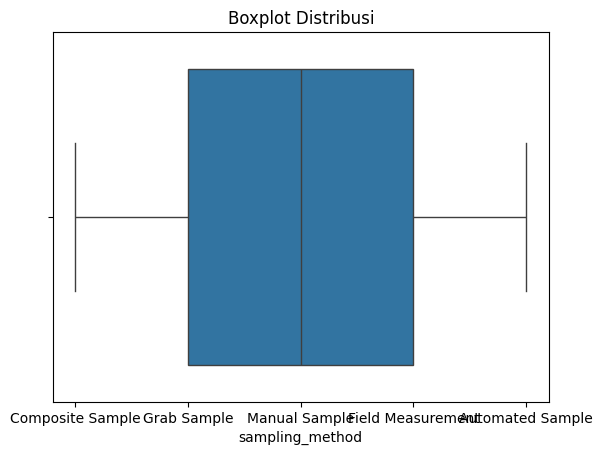

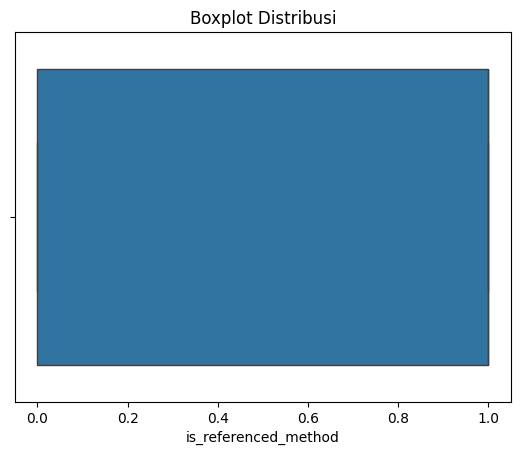

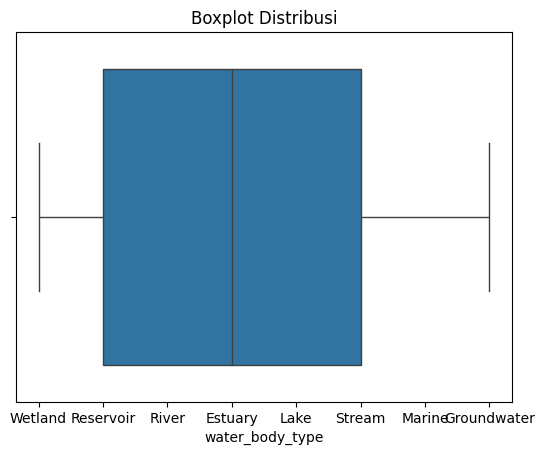

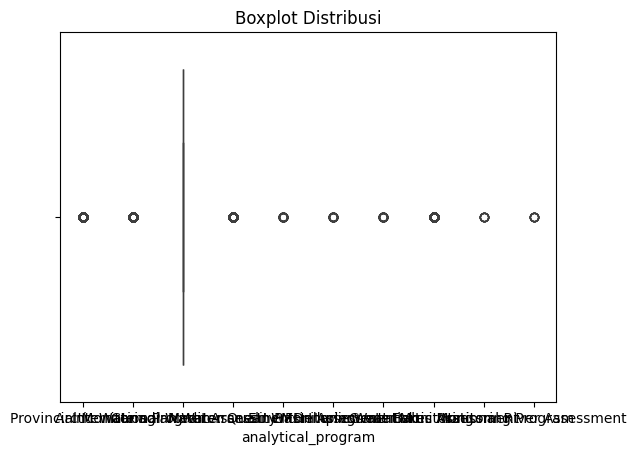

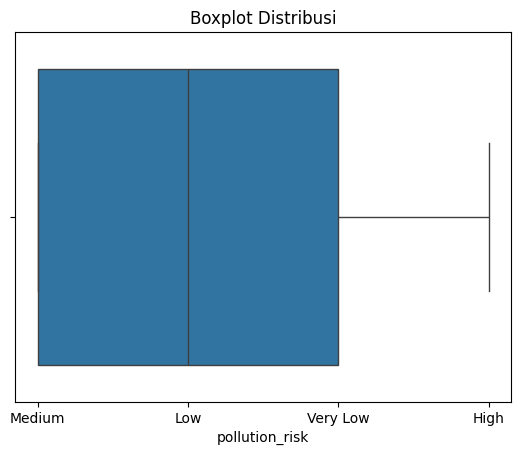

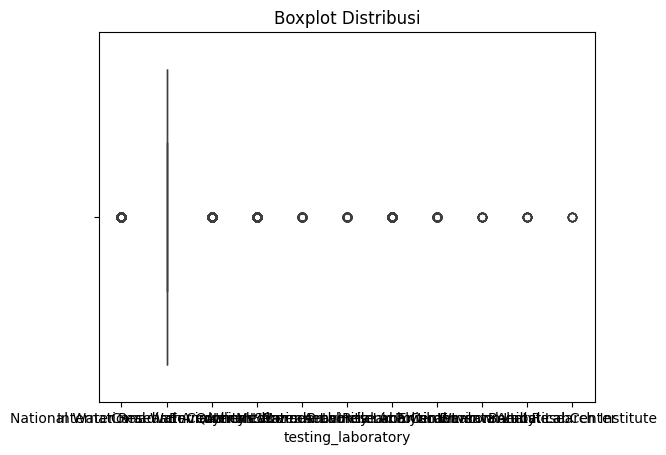

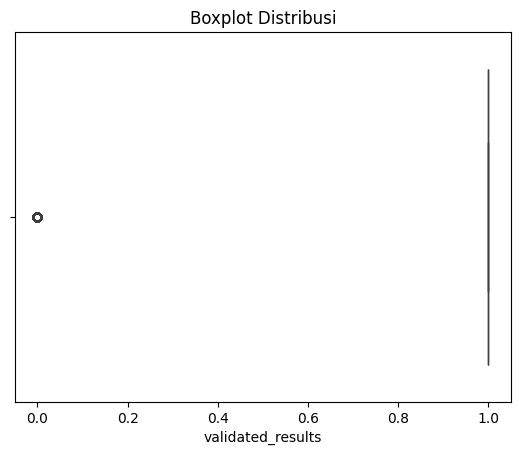

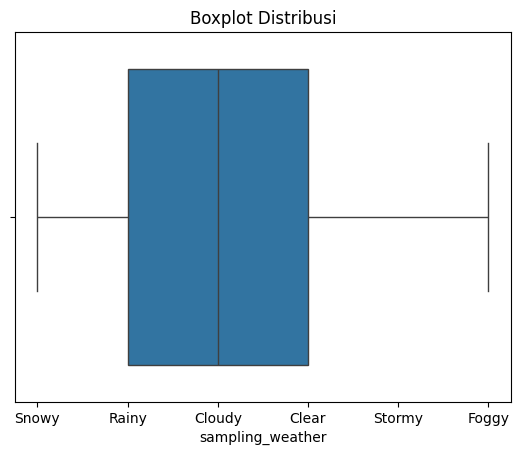

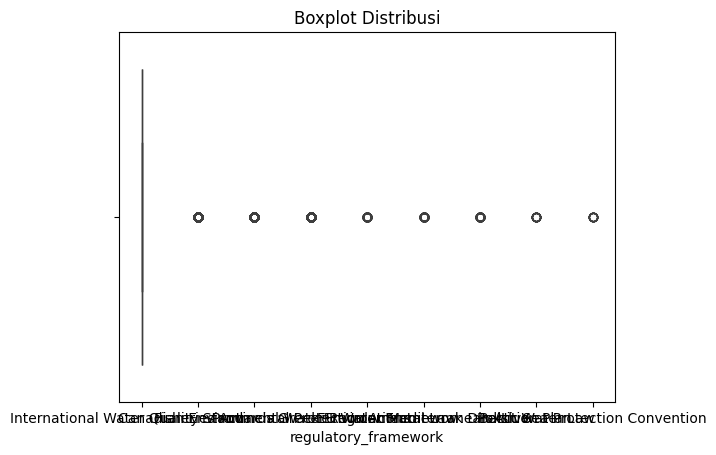

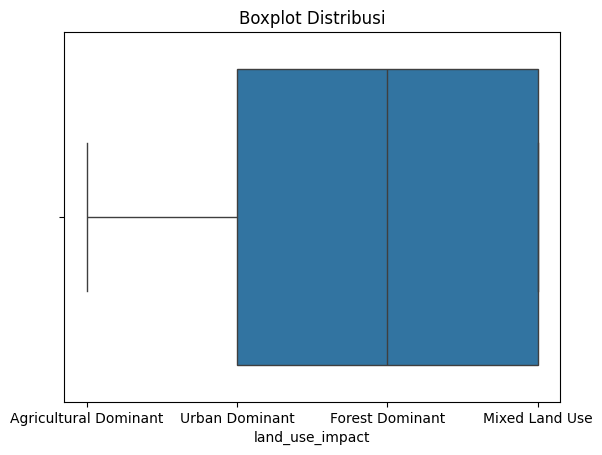

In [71]:
for i in train:
    sns.boxplot(x=train[f'{i}'])
    plt.title('Boxplot Distribusi')
    plt.show()

##### **Menggunakan QQ-Plot (Quantile-Quantile Plot)**

QQ-plot membandingkan distribusi data terhadap distribusi normal.

- Garis lurus sempurna → distribusi cocok
- Lengkung ke atas → data lebih "light-tailed" dari distribusi teoritis
- Lengkung ke bawah → data lebih "heavy-tailed"
- Titik menjauh di ujung → outlier atau ekor distribusi berbeda

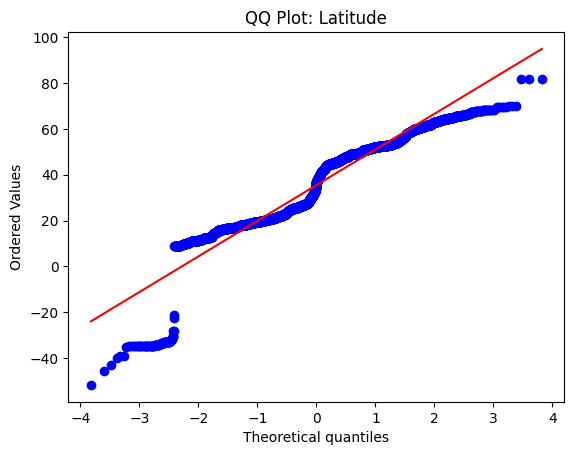

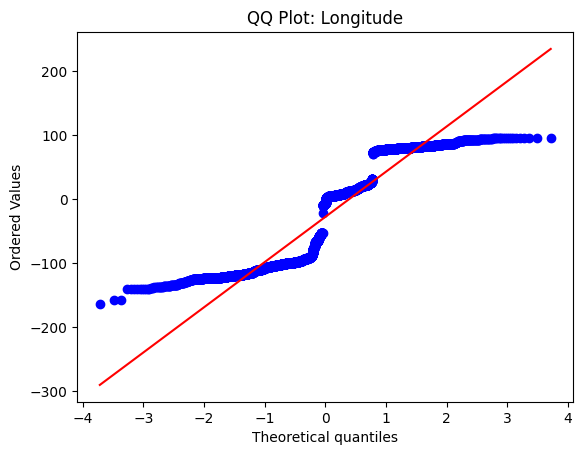

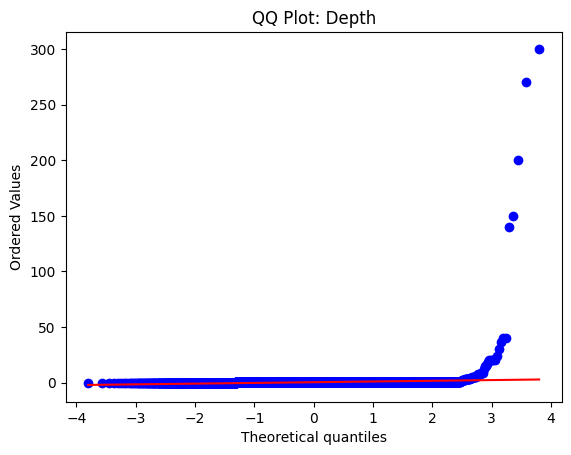

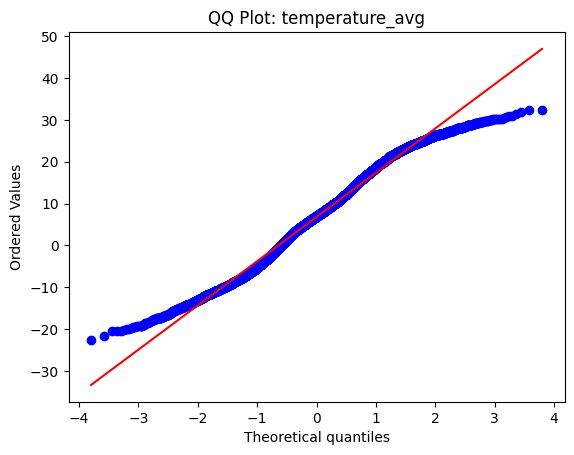

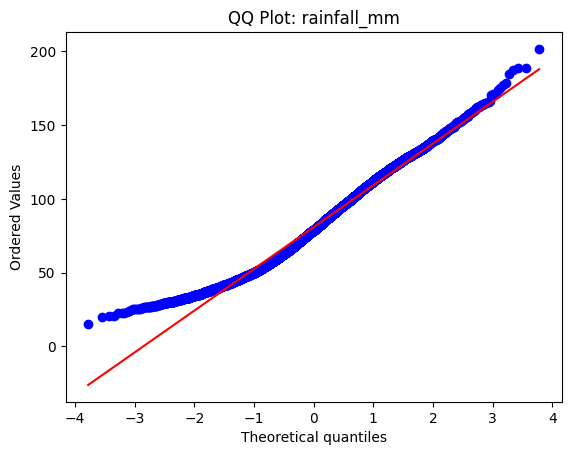

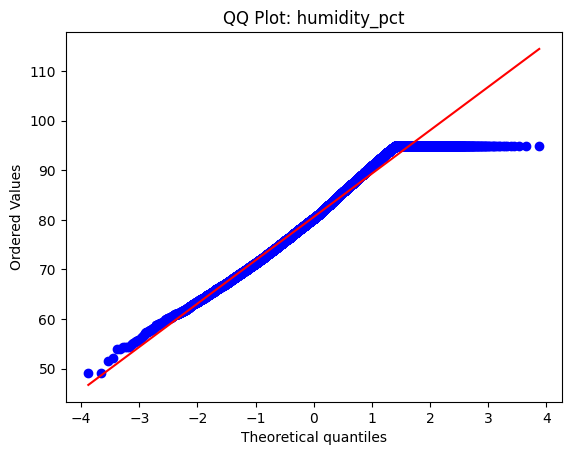

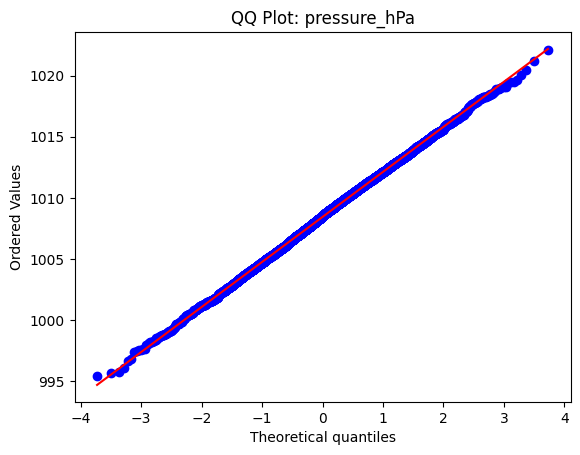

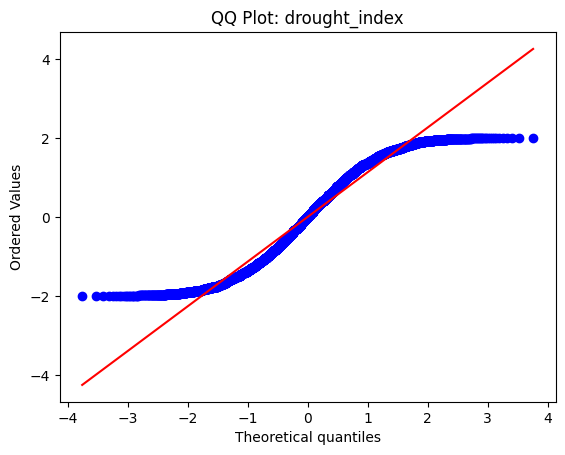

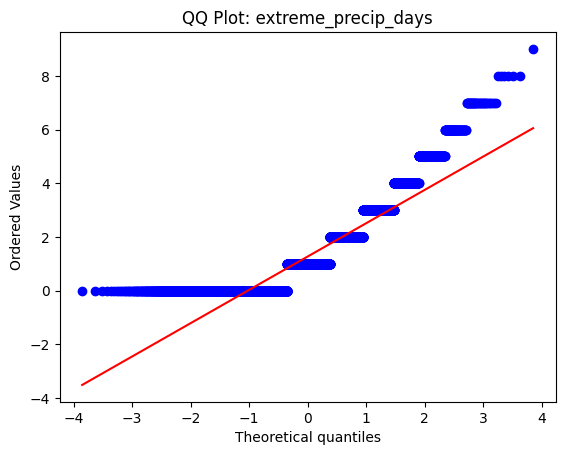

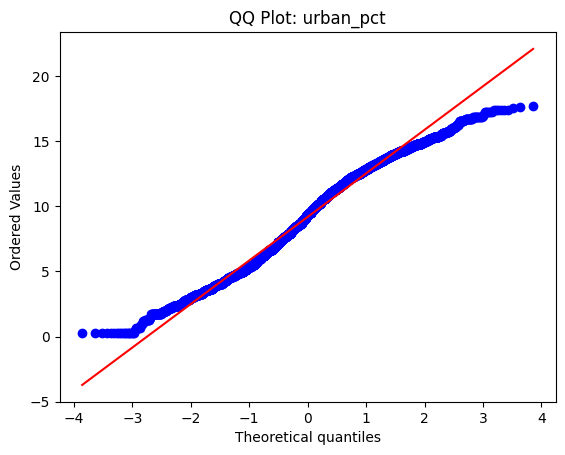

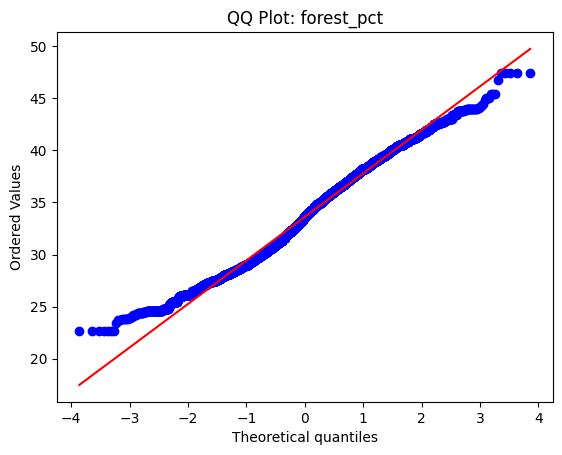

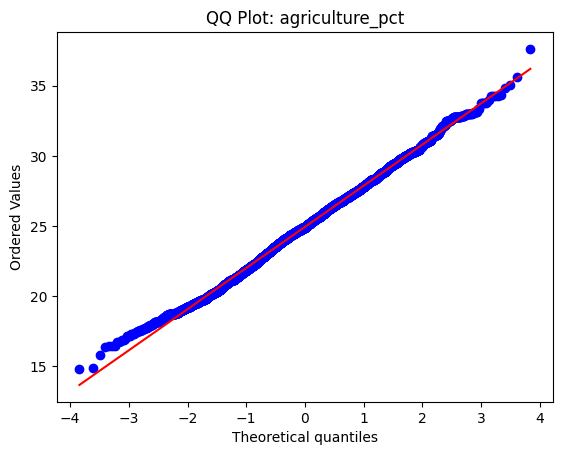

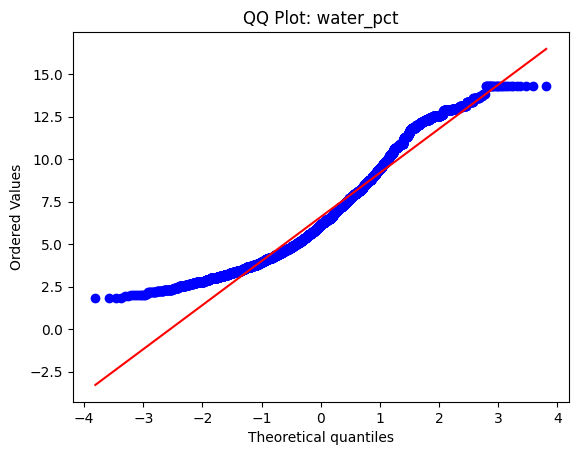

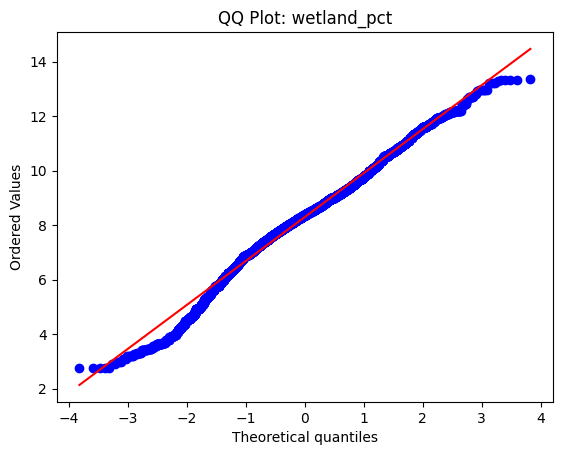

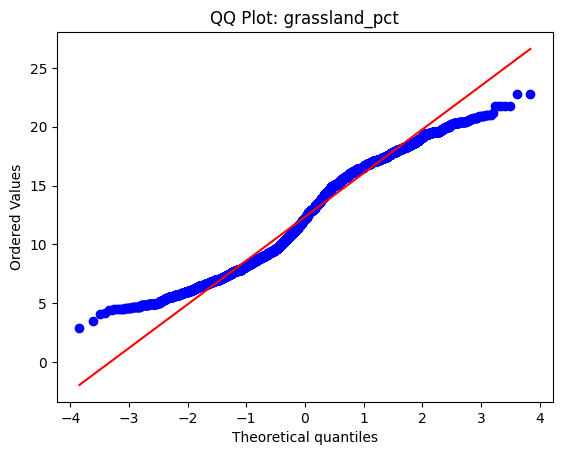

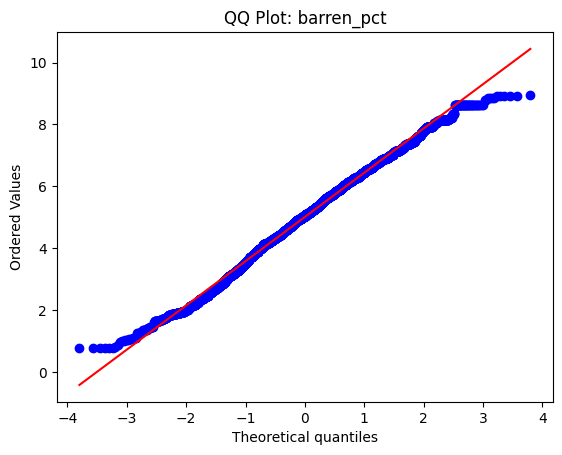

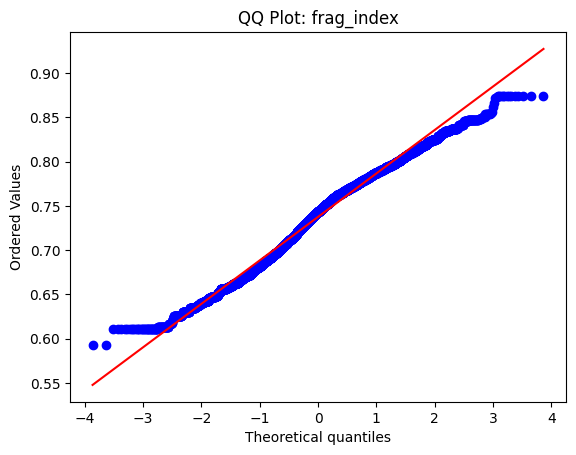

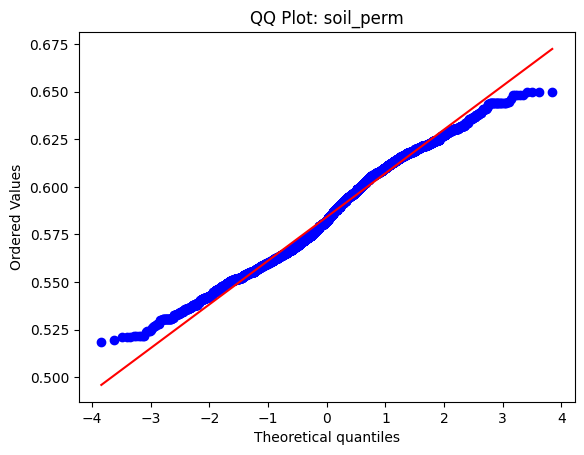

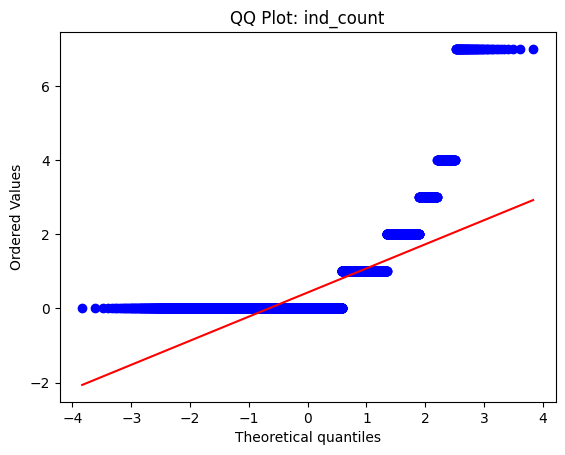

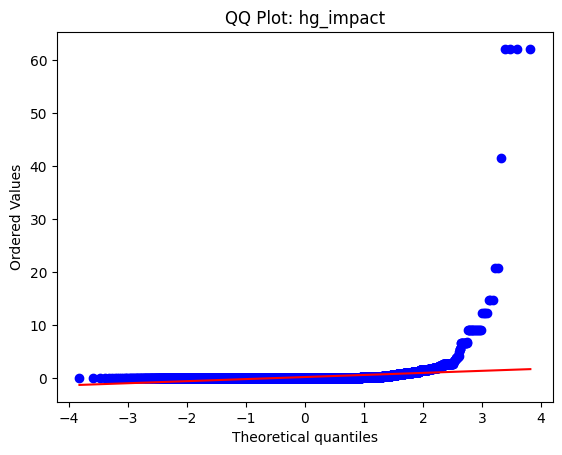

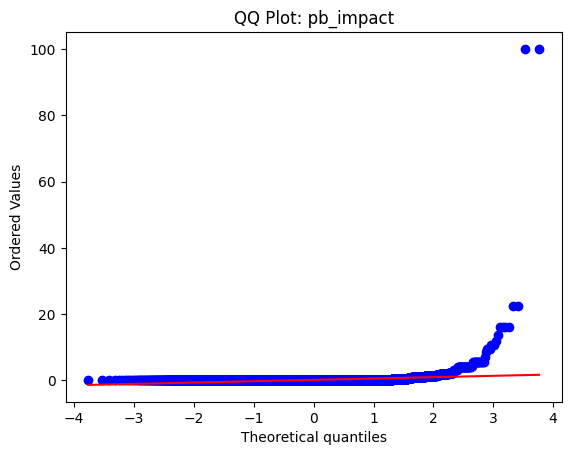

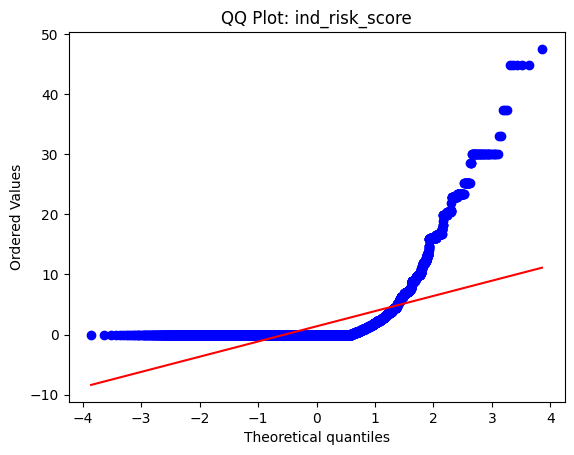

In [73]:
# Ambil hanya kolom numerik
numerik_cols = train.select_dtypes(include=['number']).columns

for col in numerik_cols:
    stats.probplot(train[col].dropna(), dist="norm", plot=plt)
    plt.title(f'QQ Plot: {col}')
    plt.show()


##### **Skewness dan Kurtosis**

- Skewness: menunjukkan kemiringan distribusi.
- Kurtosis: menunjukkan ketebalan ekor distribusi (outlier).

📊 Menampilkan distribusi kolom numerik:

Kolom: Latitude
  Skewness : -0.47
  Kurtosis : 0.94
----------------------------------------


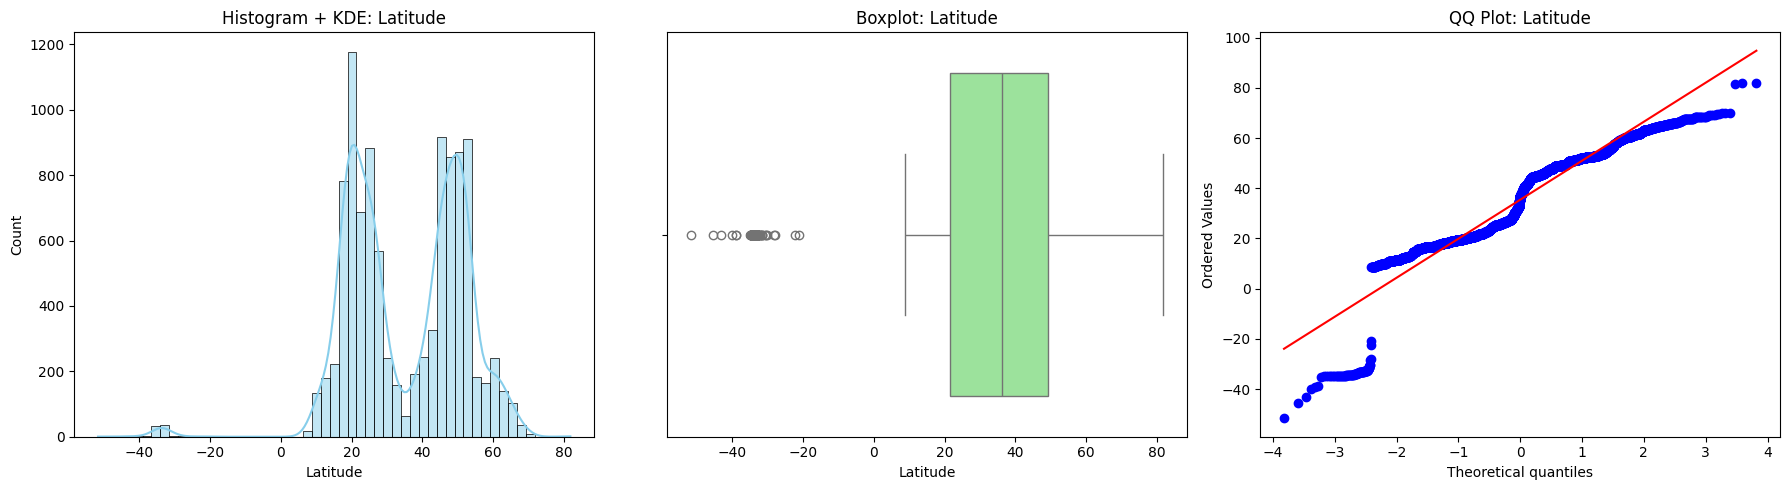

Kolom: Longitude
  Skewness : 0.18
  Kurtosis : -1.51
----------------------------------------


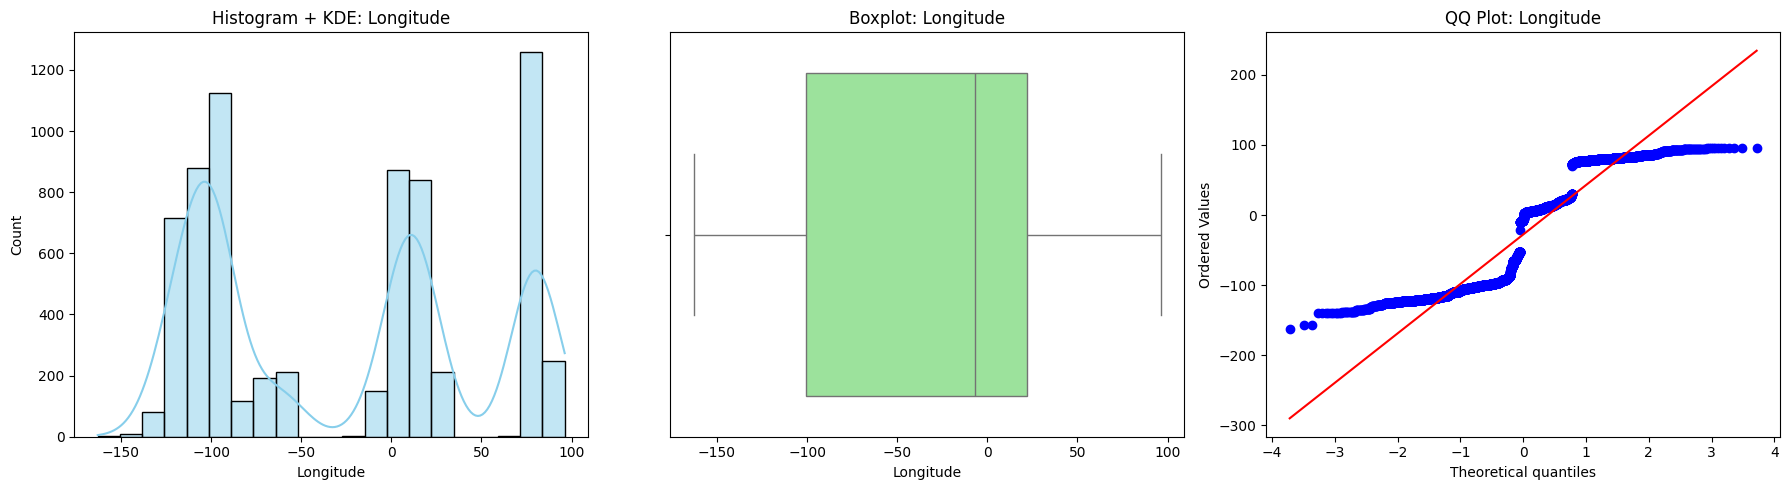

Kolom: Depth
  Skewness : 46.32
  Kurtosis : 2333.69
----------------------------------------


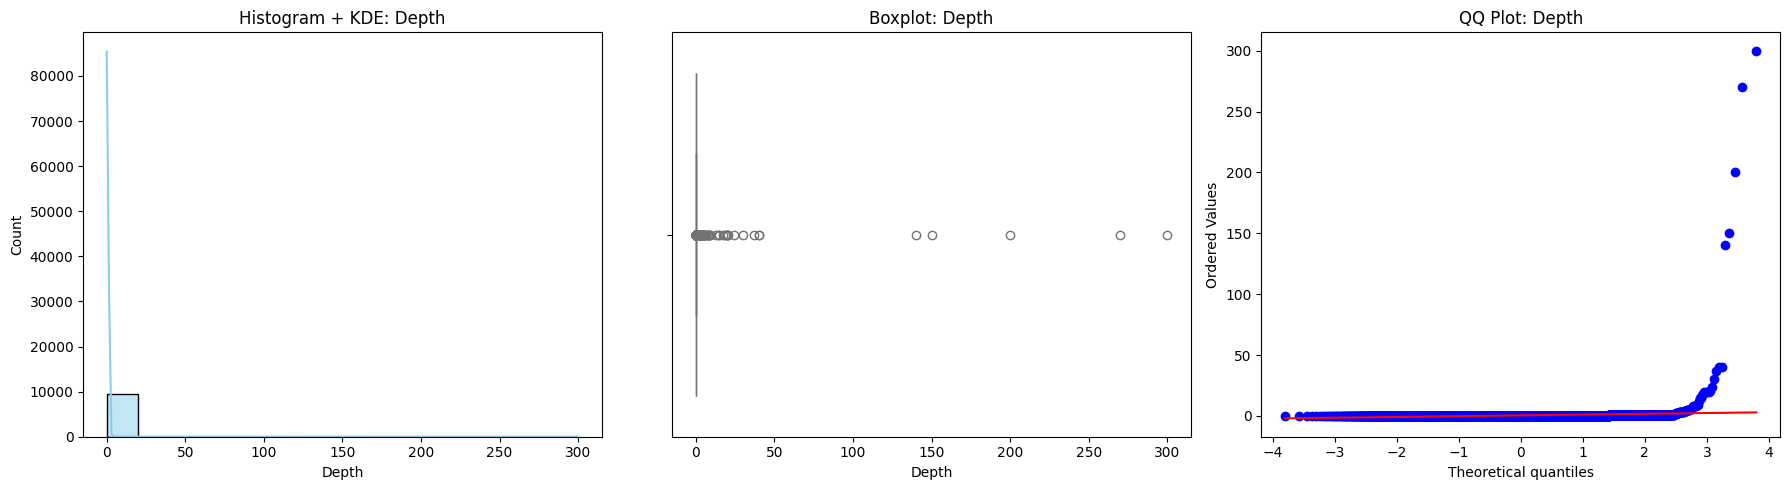

Kolom: temperature_avg
  Skewness : -0.05
  Kurtosis : -0.71
----------------------------------------


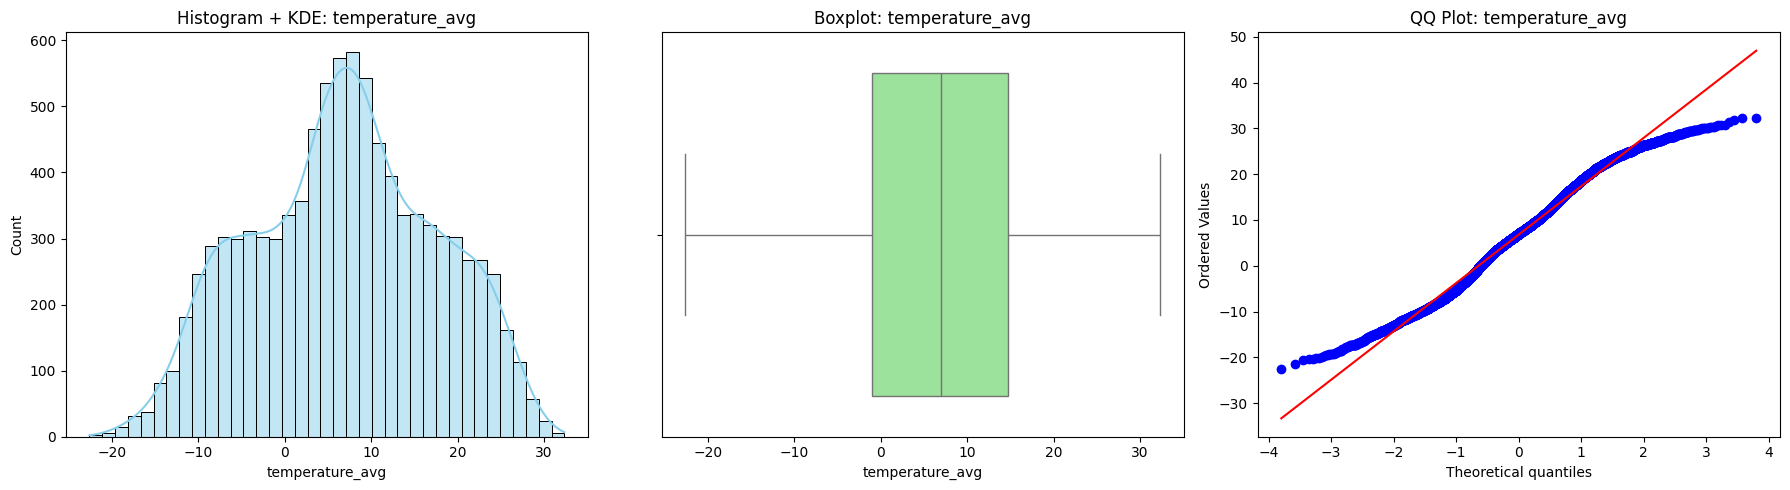

Kolom: rainfall_mm
  Skewness : 0.35
  Kurtosis : -0.48
----------------------------------------


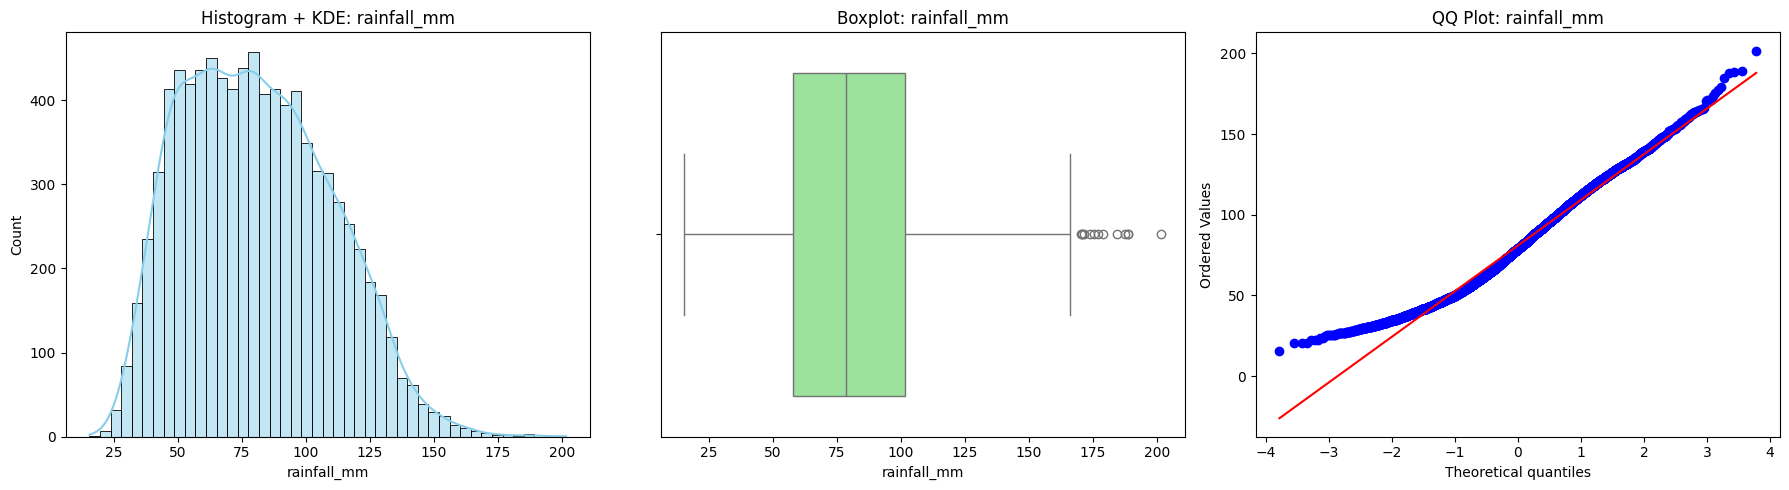

Kolom: humidity_pct
  Skewness : -0.10
  Kurtosis : -0.71
----------------------------------------


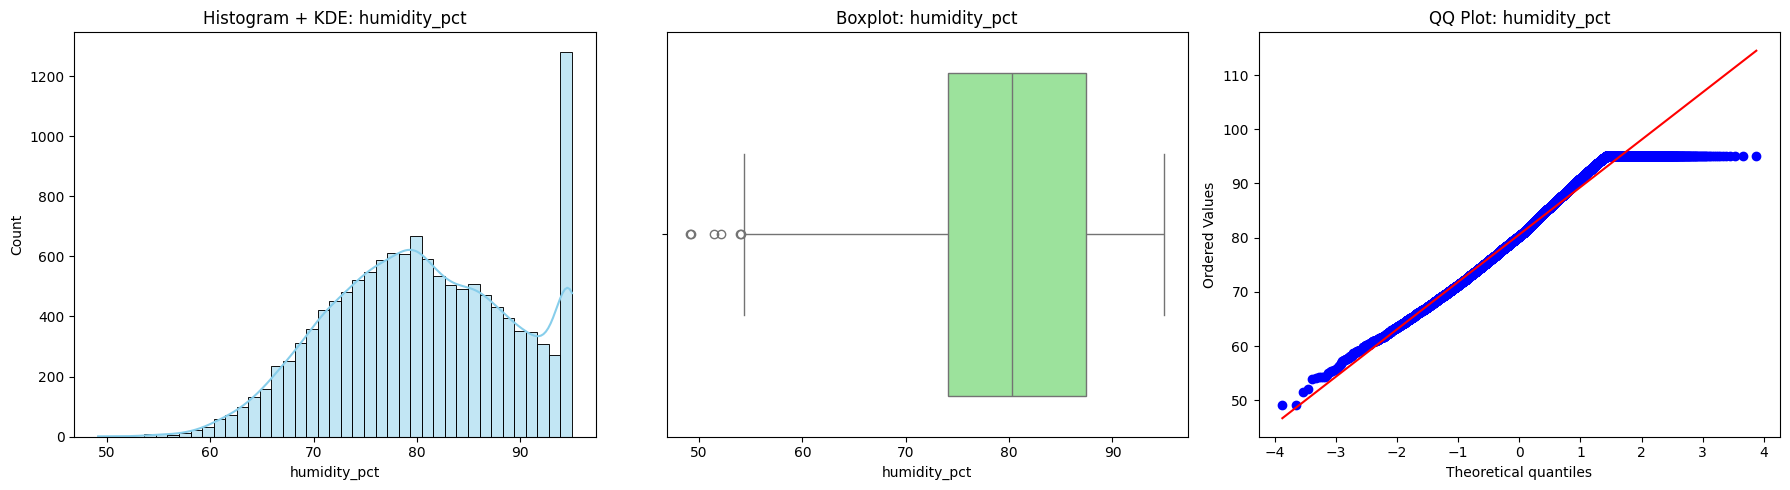

Kolom: pressure_hPa
  Skewness : -0.03
  Kurtosis : -0.11
----------------------------------------


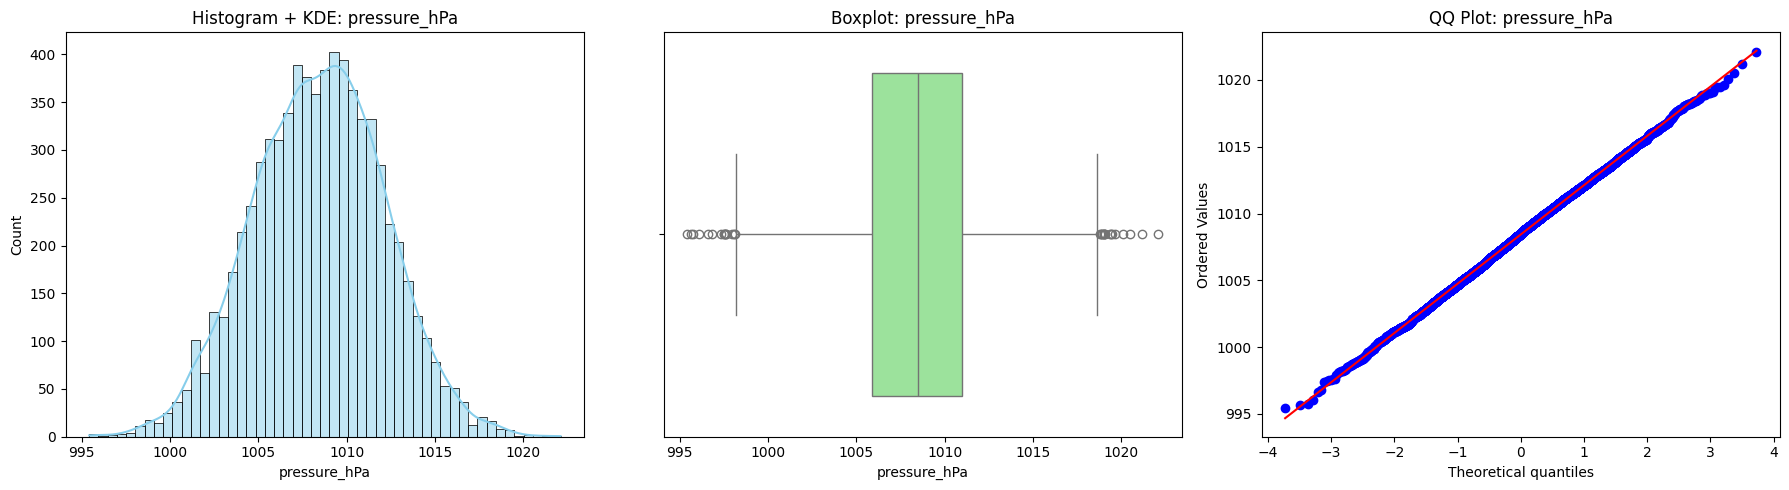

Kolom: drought_index
  Skewness : -0.00
  Kurtosis : -1.21
----------------------------------------


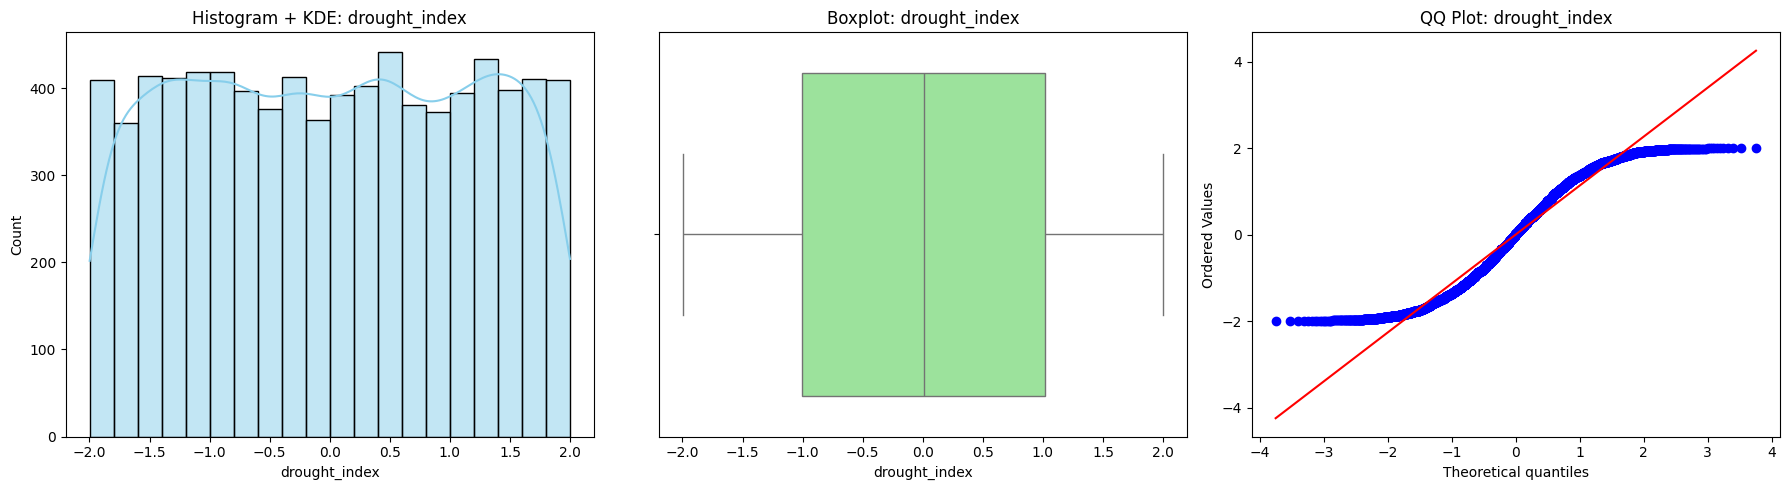

Kolom: extreme_precip_days
  Skewness : 1.21
  Kurtosis : 1.51
----------------------------------------


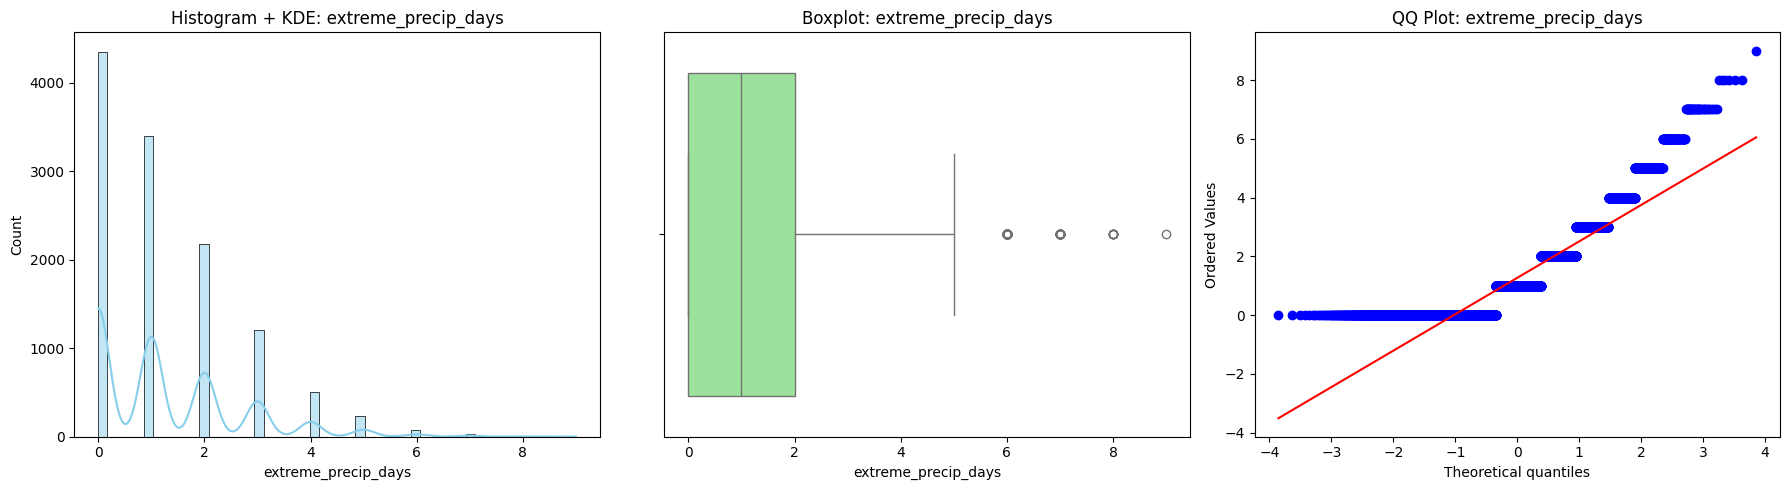

Kolom: urban_pct
  Skewness : -0.11
  Kurtosis : -0.86
----------------------------------------


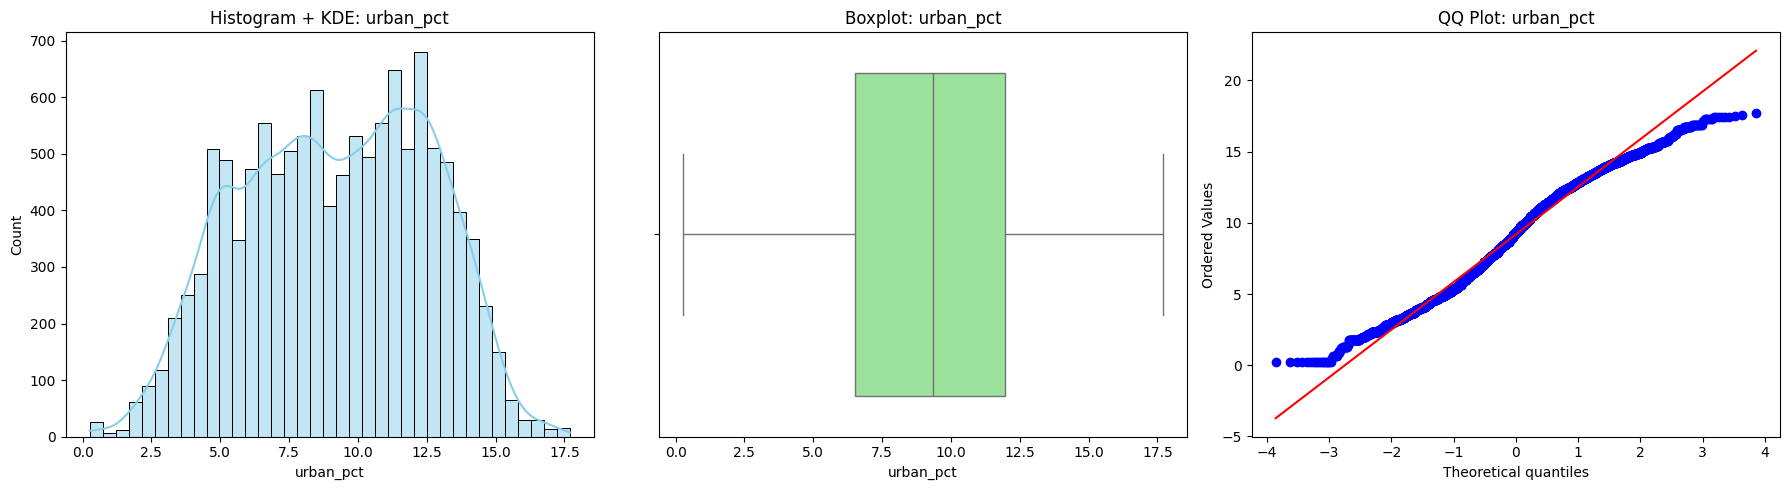

Kolom: forest_pct
  Skewness : 0.10
  Kurtosis : -0.73
----------------------------------------


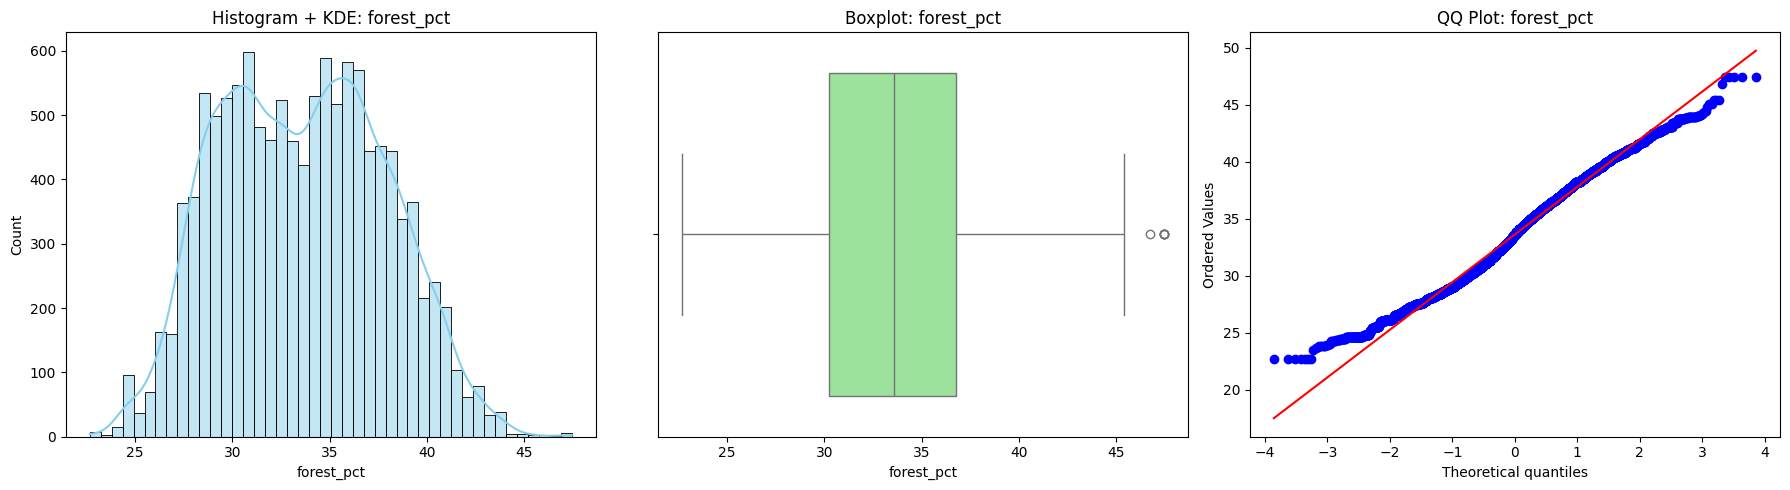

Kolom: agriculture_pct
  Skewness : 0.03
  Kurtosis : -0.15
----------------------------------------


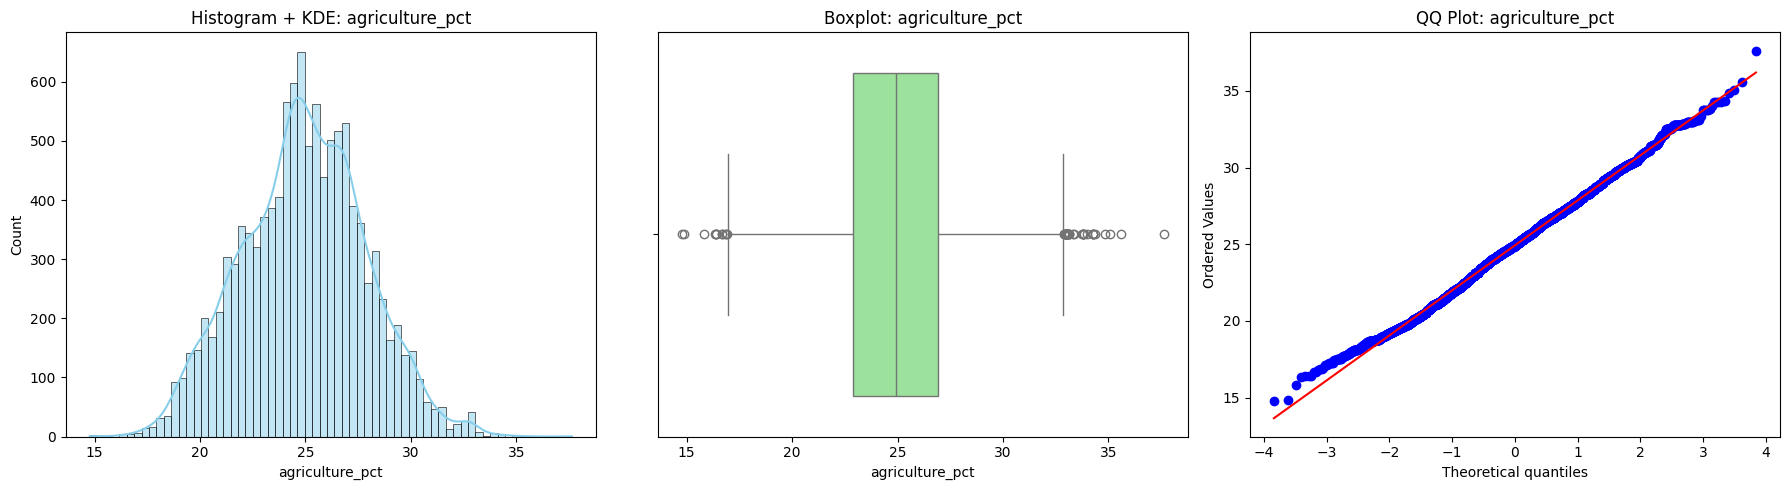

Kolom: water_pct
  Skewness : 0.68
  Kurtosis : -0.29
----------------------------------------


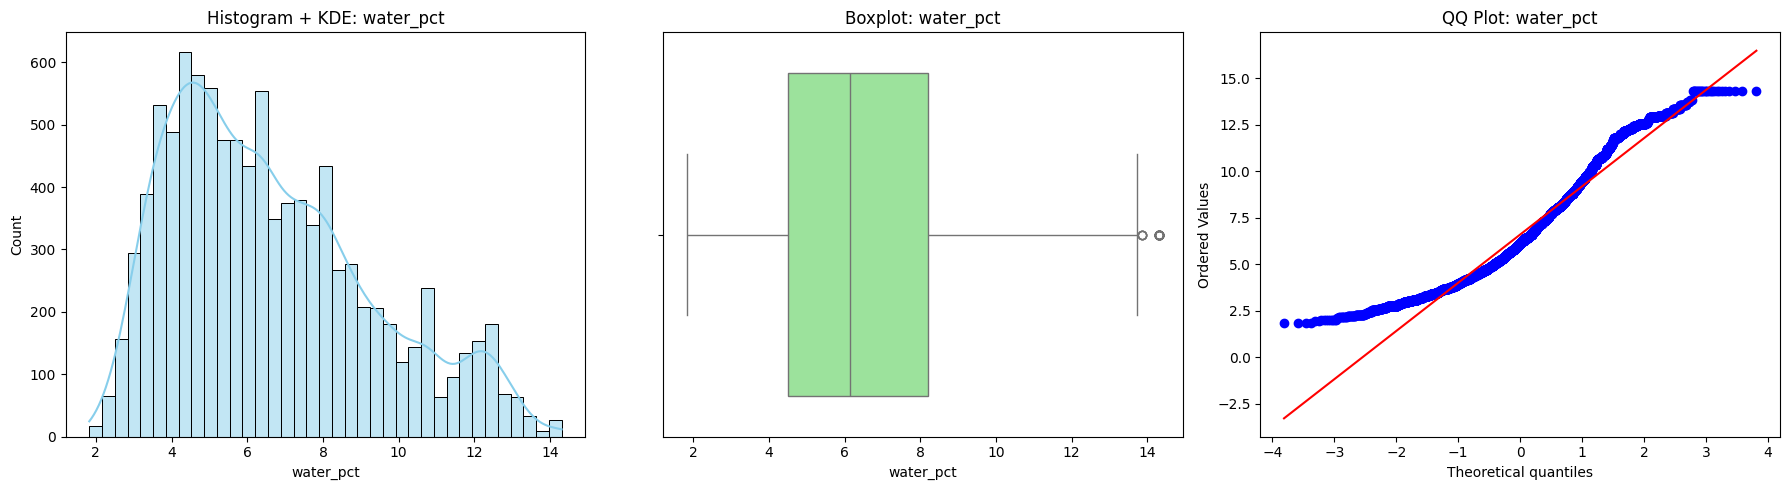

Kolom: wetland_pct
  Skewness : -0.30
  Kurtosis : 0.58
----------------------------------------


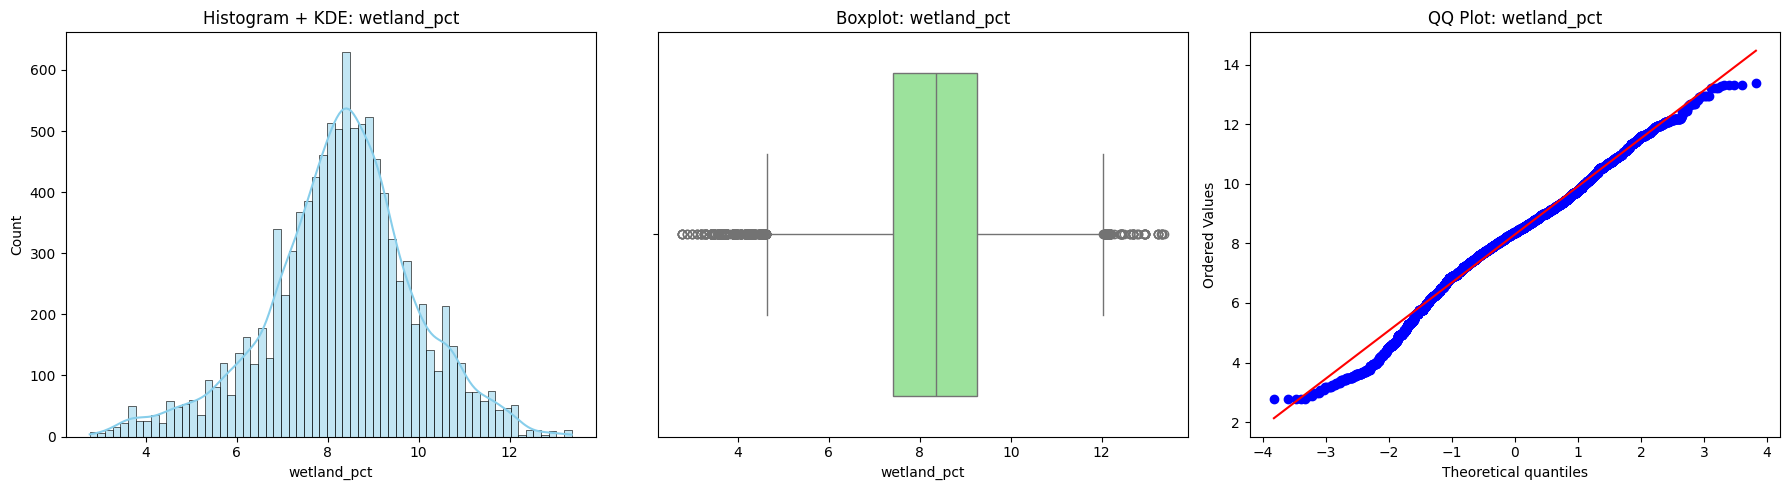

Kolom: grassland_pct
  Skewness : 0.07
  Kurtosis : -1.10
----------------------------------------


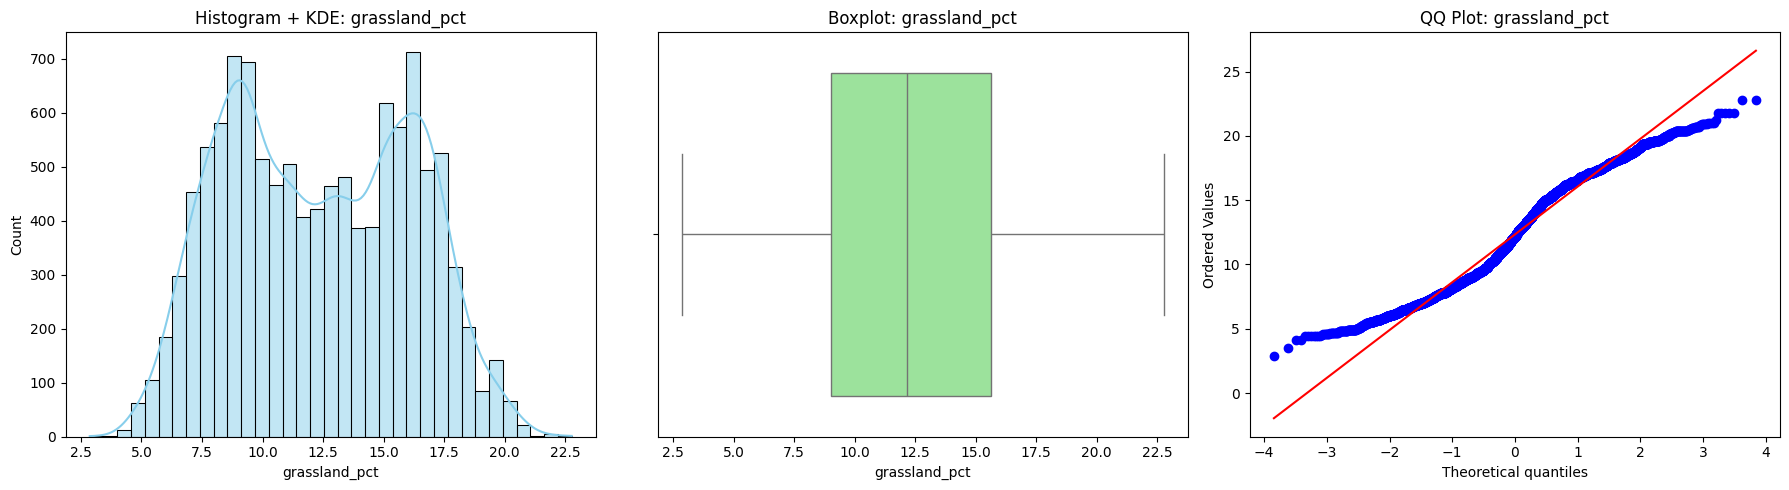

Kolom: barren_pct
  Skewness : -0.15
  Kurtosis : -0.27
----------------------------------------


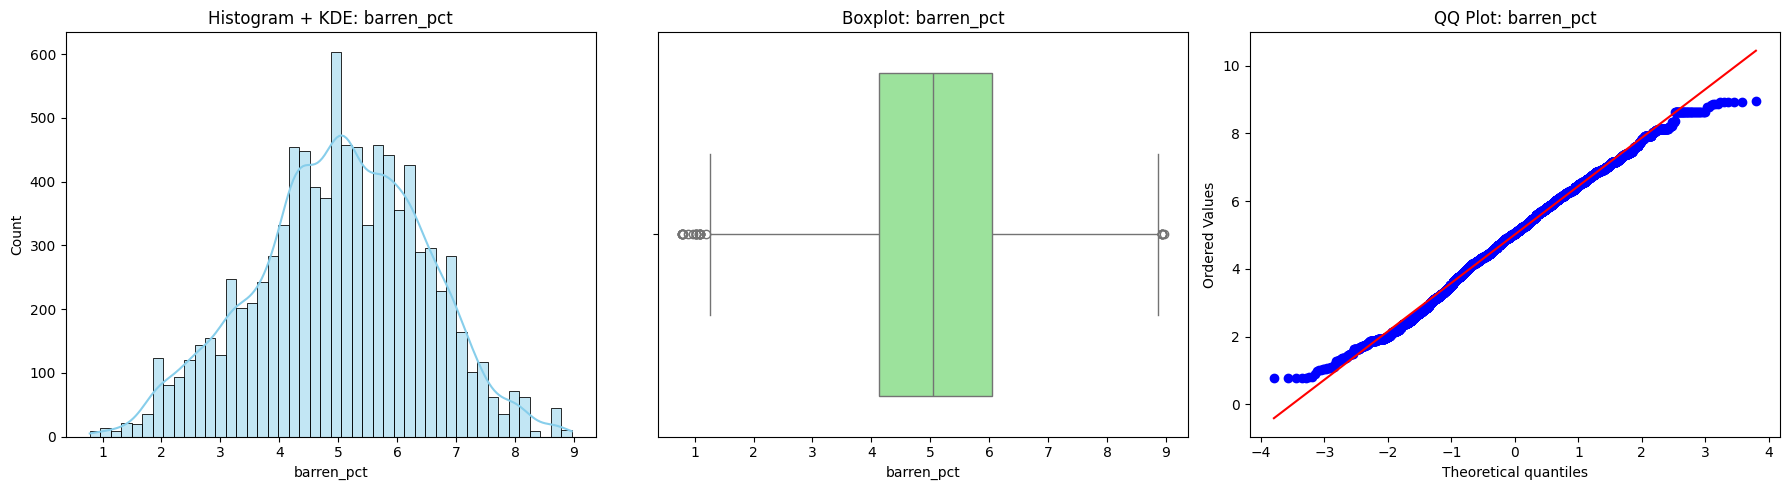

Kolom: frag_index
  Skewness : -0.21
  Kurtosis : -0.62
----------------------------------------


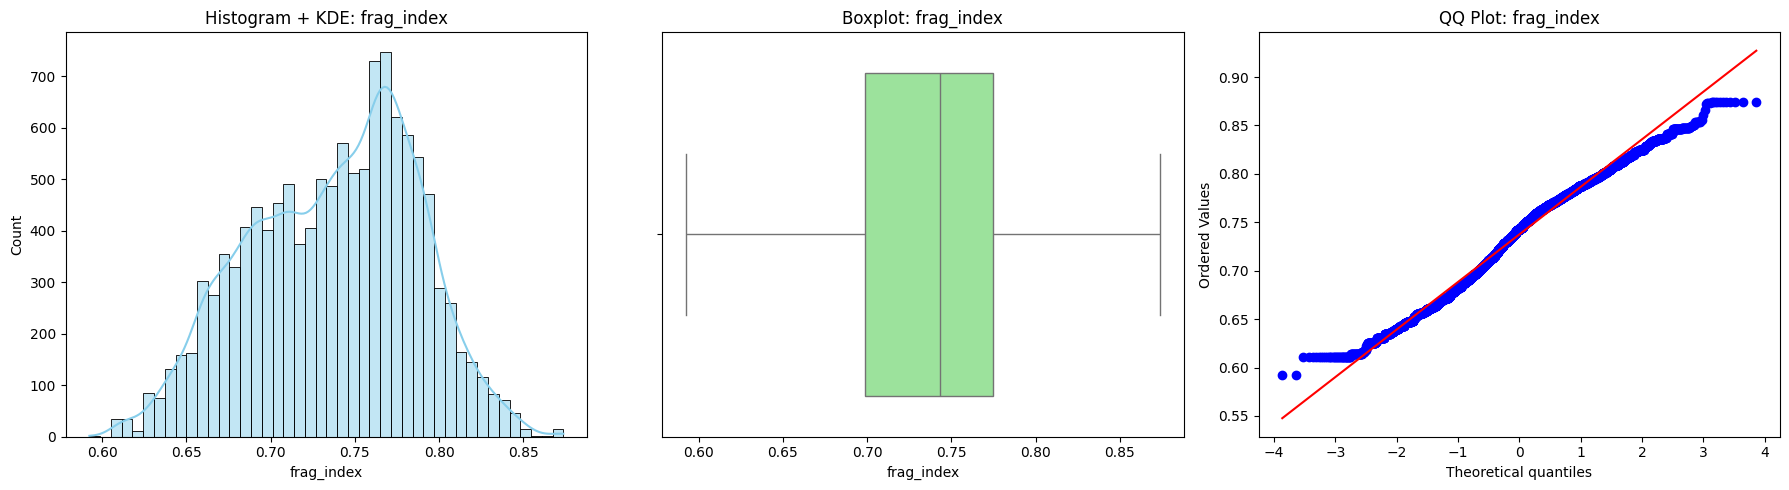

Kolom: soil_perm
  Skewness : 0.11
  Kurtosis : -0.75
----------------------------------------


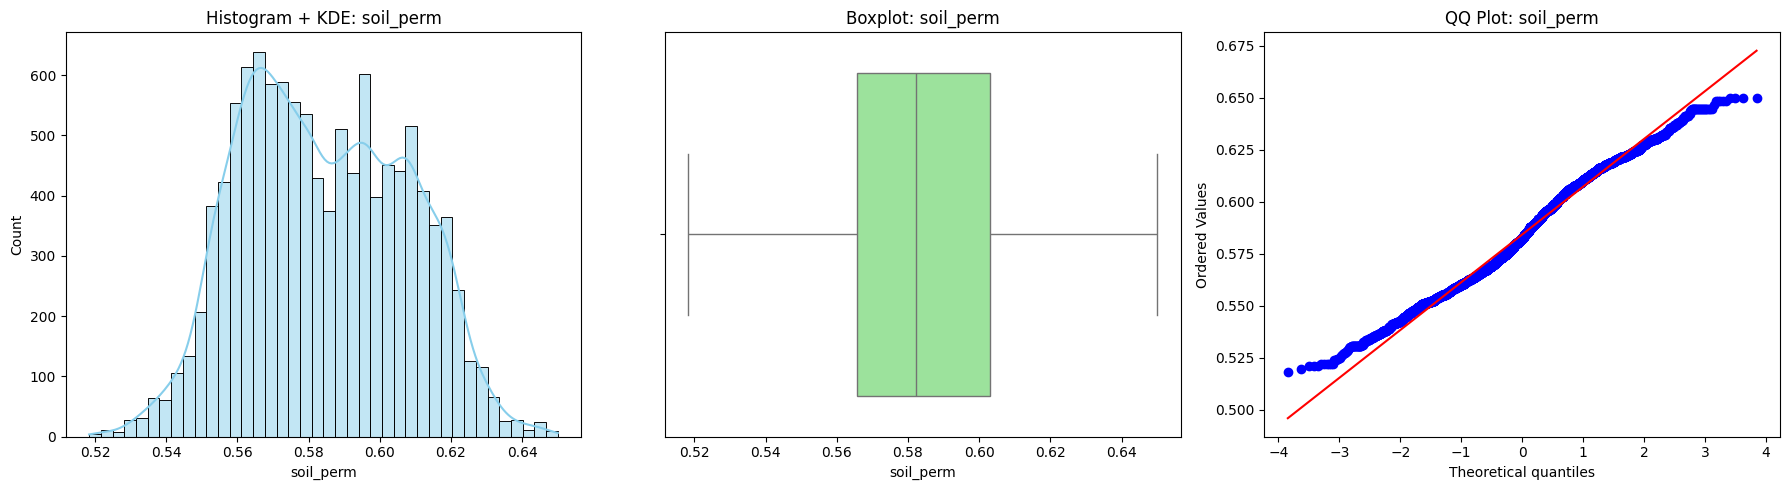

Kolom: ind_count
  Skewness : 3.50
  Kurtosis : 17.87
----------------------------------------


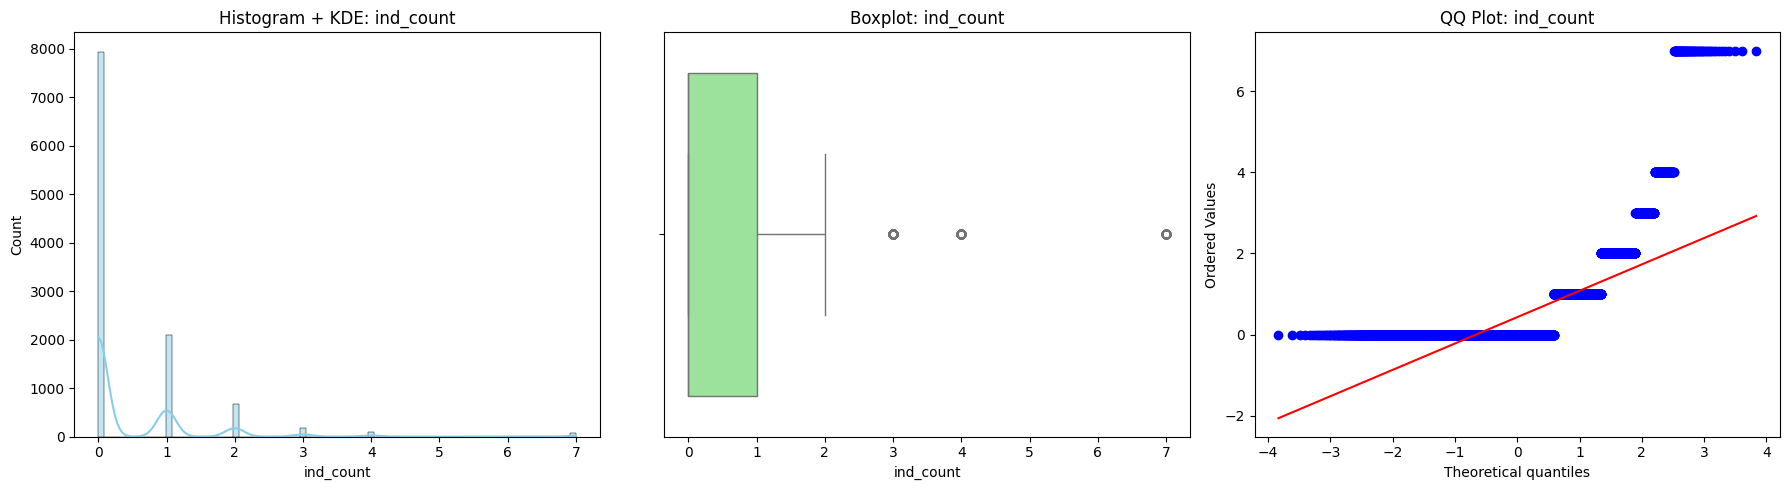

Kolom: hg_impact
  Skewness : 32.95
  Kurtosis : 1313.66
----------------------------------------


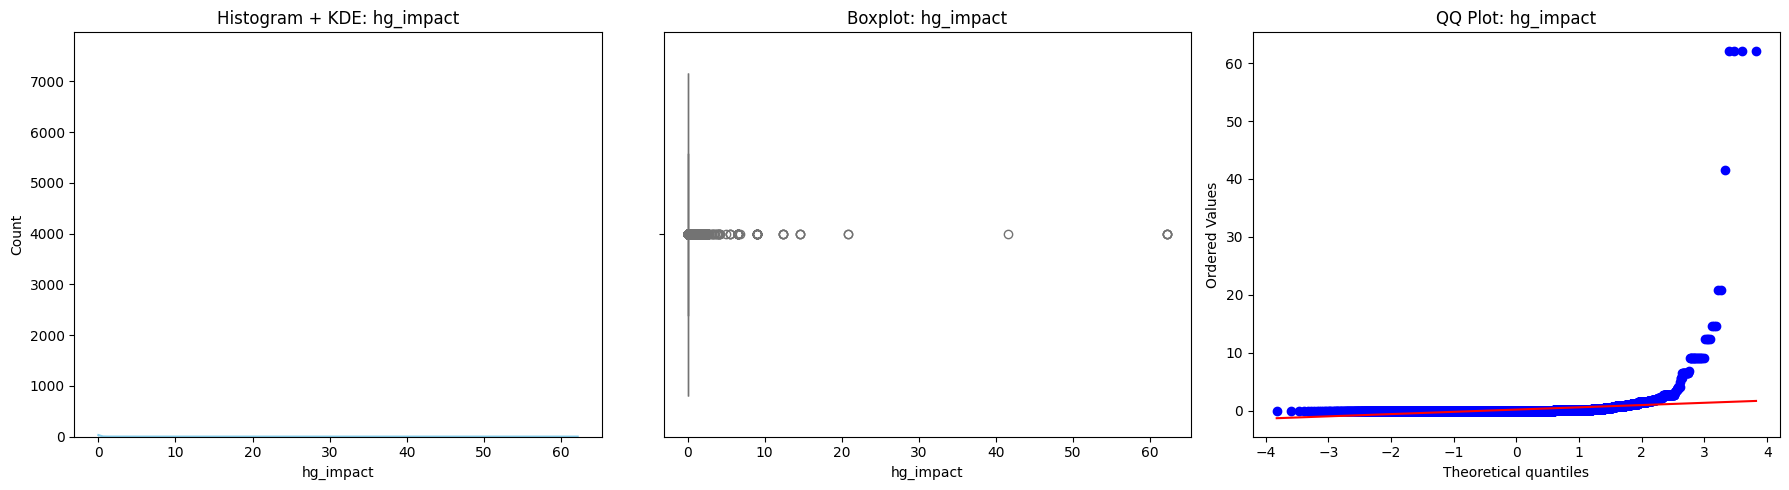

Kolom: pb_impact
  Skewness : 47.77
  Kurtosis : 2699.91
----------------------------------------


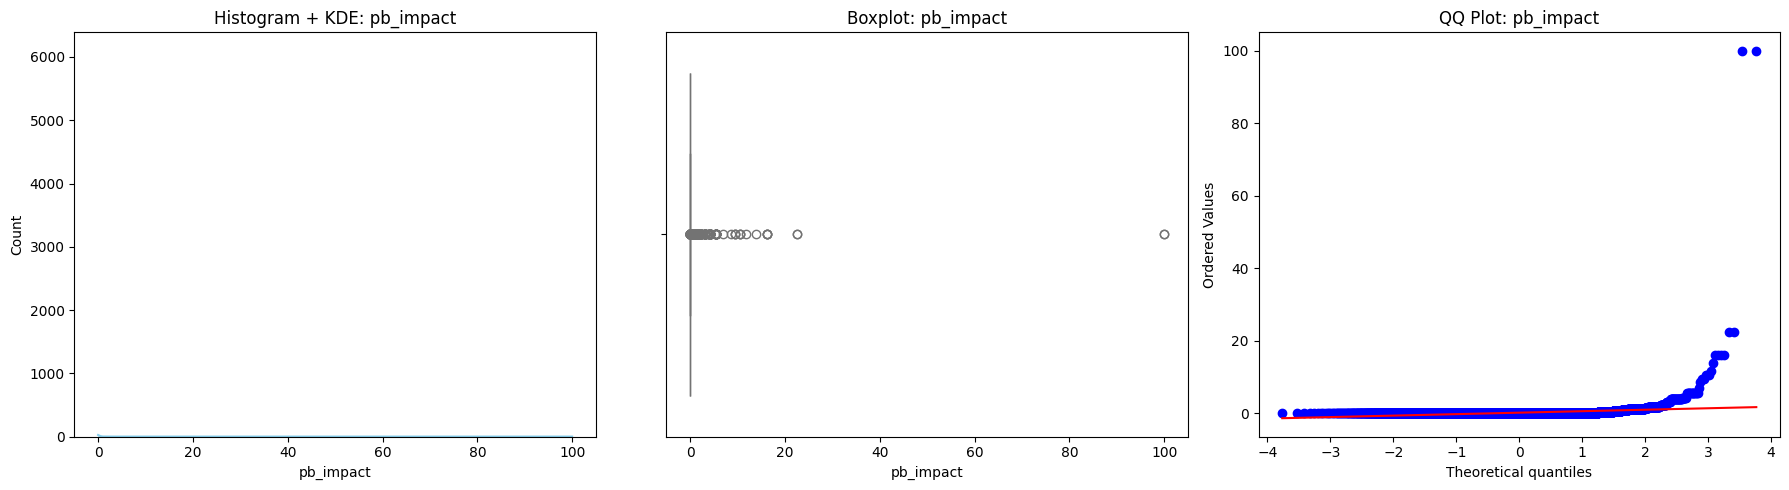

Kolom: ind_risk_score
  Skewness : 4.57
  Kurtosis : 25.59
----------------------------------------


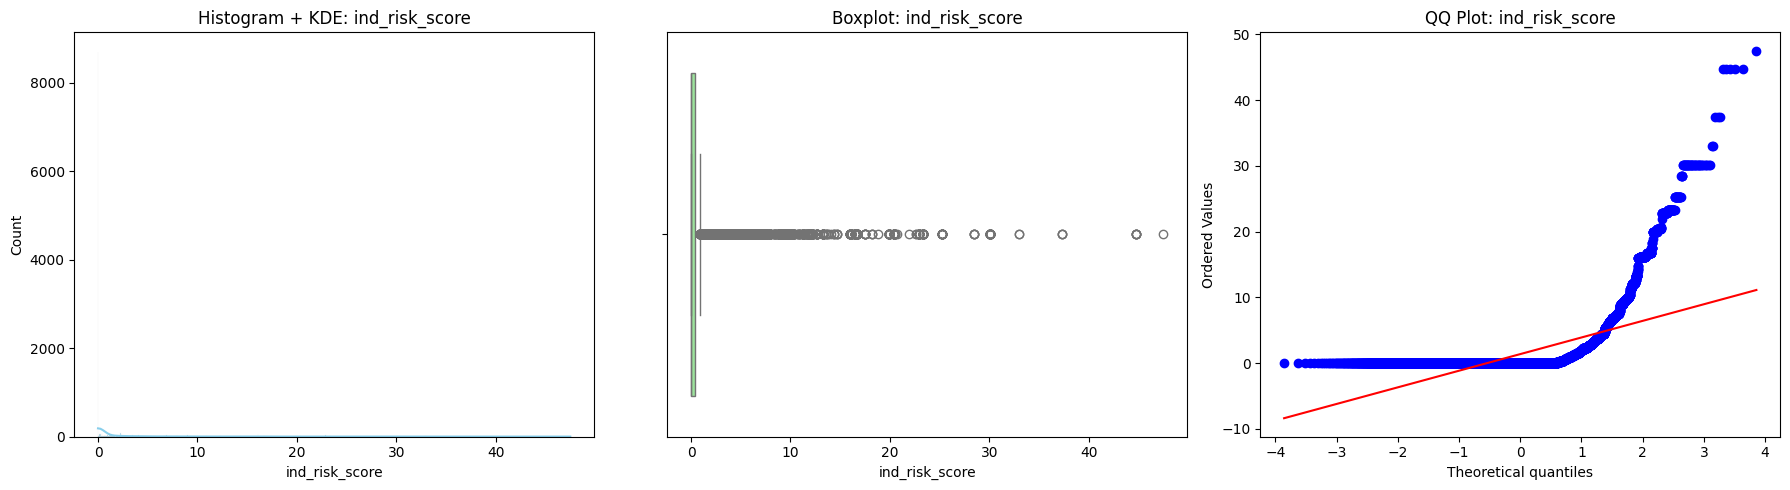

In [74]:
def cek_distribusi(df):
    # Ambil hanya kolom numerik
    df_numeric = df.select_dtypes(include='number')
    
    print("📊 Menampilkan distribusi kolom numerik:\n")
    
    for col in df_numeric.columns:
        print(f"Kolom: {col}")
        print(f"  Skewness : {df[col].skew():.2f}")
        print(f"  Kurtosis : {df[col].kurt():.2f}")
        print("-" * 40)

        # Buat subplot 1 baris 3 kolom
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Histogram + KDE
        sns.histplot(df[col].dropna(), kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title(f'Histogram + KDE: {col}')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
        axes[1].set_title(f'Boxplot: {col}')

        # QQ Plot
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title(f'QQ Plot: {col}')

        plt.tight_layout()
        plt.show()

cek_distribusi(train)

##### **Uji normalitas seluruh kolom numerik**

In [78]:
def uji_normalitas(df):
    numeric_cols = df.select_dtypes(include='number').columns

    print("🧪 Uji Normalitas (Shapiro-Wilk & Kolmogorov-Smirnov)\n")

    for col in numeric_cols:
        data = df[col].dropna()

        # Shapiro-Wilk Test (untuk data <= 5000 titik)
        if len(data) > 3:
            try:
                stat_shapiro, p_shapiro = shapiro(data)
                shapiro_status = "✅ Normal" if p_shapiro > 0.05 else "❌ Tidak Normal"
            except Exception as e:
                stat_shapiro, p_shapiro, shapiro_status = np.nan, np.nan, f"⚠️ Error: {e}"
        else:
            stat_shapiro, p_shapiro, shapiro_status = np.nan, np.nan, "❌ Data terlalu sedikit"

        # Kolmogorov–Smirnov Test (distribusi normal)
        try:
            # Ubah ke distribusi normal standar dulu (z-score)
            data_z = (data - data.mean()) / data.std()
            stat_ks, p_ks = kstest(data_z, 'norm')
            ks_status = "✅ Normal" if p_ks > 0.05 else "❌ Tidak Normal"
        except Exception as e:
            stat_ks, p_ks, ks_status = np.nan, np.nan, f"⚠️ Error: {e}"

        print(f"📌 Kolom: {col}")
        print(f"  Shapiro-Wilk     : stat = {stat_shapiro:.3f}, p = {p_shapiro:.3f} → {shapiro_status}")
        print(f"  Kolmogorov-Smirnov: stat = {stat_ks:.3f}, p = {p_ks:.3f} → {ks_status}")
        print("-" * 60)

uji_normalitas(train)

🧪 Uji Normalitas (Shapiro-Wilk & Kolmogorov-Smirnov)

📌 Kolom: Latitude
  Shapiro-Wilk     : stat = 0.918, p = 0.000 → ❌ Tidak Normal
  Kolmogorov-Smirnov: stat = 0.132, p = 0.000 → ❌ Tidak Normal
------------------------------------------------------------
📌 Kolom: Longitude
  Shapiro-Wilk     : stat = 0.866, p = 0.000 → ❌ Tidak Normal
  Kolmogorov-Smirnov: stat = 0.199, p = 0.000 → ❌ Tidak Normal
------------------------------------------------------------
📌 Kolom: Depth
  Shapiro-Wilk     : stat = 0.016, p = 0.000 → ❌ Tidak Normal
  Kolmogorov-Smirnov: stat = 0.478, p = 0.000 → ❌ Tidak Normal
------------------------------------------------------------
📌 Kolom: temperature_avg
  Shapiro-Wilk     : stat = 0.988, p = 0.000 → ❌ Tidak Normal
  Kolmogorov-Smirnov: stat = 0.032, p = 0.000 → ❌ Tidak Normal
------------------------------------------------------------
📌 Kolom: rainfall_mm
  Shapiro-Wilk     : stat = 0.981, p = 0.000 → ❌ Tidak Normal
  Kolmogorov-Smirnov: stat = 0.049, p = 0.

#### Cek korelasi data

##### **Cek korelasi menggunakan `.corr()` dan heatmap untuk fitur numerik**

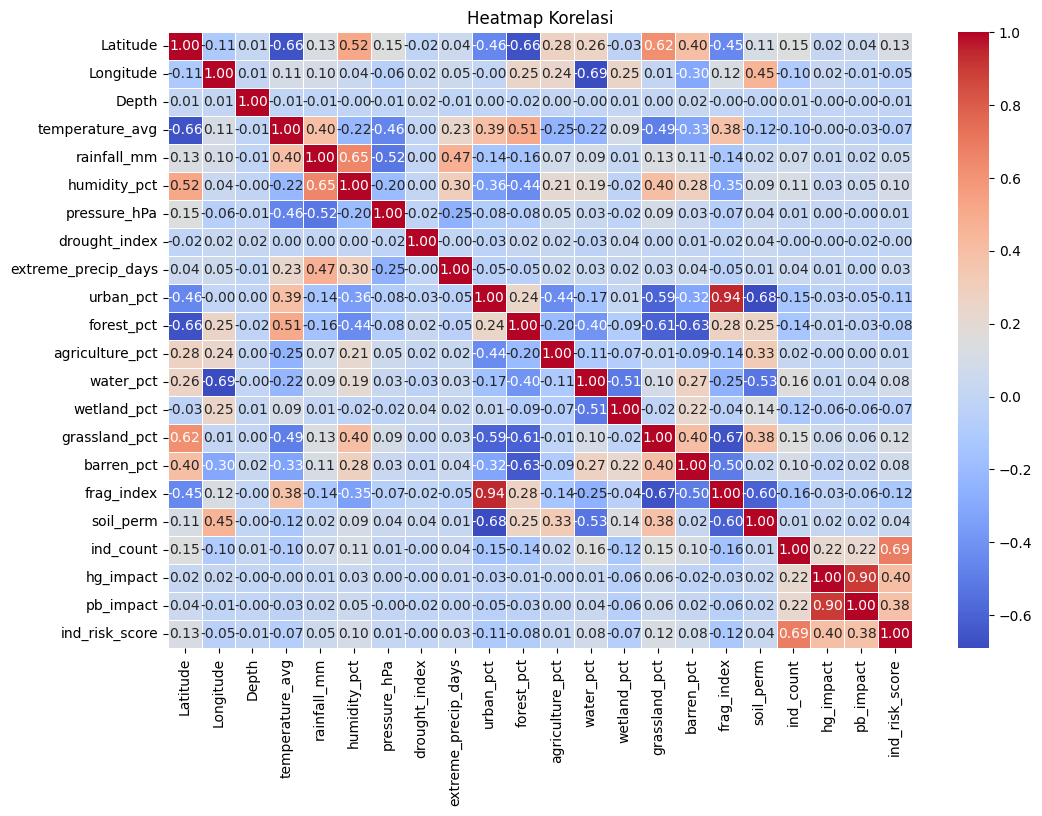

In [80]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()


##### **Menggunakan function `cek_korelasi` untuk fitur numerik menggunakan Spearman Rank Correlation**

**Spearman Rank Correlation (ρ)**

**Spearman’s Rank Correlation Coefficient** (simbol: ρ atau "rho") adalah ukuran korelasi **non-parametrik** yang mengevaluasi **hubungan monotonik** antara dua variabel. Metode ini tidak menggunakan nilai asli, tetapi menggunakan **peringkat (ranking)** dari nilai.

---

**Mengapa Menggunakan Spearman?**

**Spearman cocok digunakan dalam situasi berikut:**

| Kasus                                                                 | Alasan Memakai Spearman                                       |
|-----------------------------------------------------------------------|----------------------------------------------------------------|
| Hubungan antara variabel tidak linear                                 | Spearman mengukur hubungan monotonik                          |
| Data memiliki skala ordinal / ranking                                 | Spearman bekerja pada peringkat                               |
| Terdapat outlier ekstrem yang mengganggu korelasi Pearson             | Spearman lebih robust terhadap outlier                        |
| Data tidak memenuhi asumsi distribusi normal (non-parametrik)         | Spearman tidak perlu distribusi normal                        |

---

**Definisi Matematis Spearman Rank Correlation**

Untuk dua variabel \( X \) dan \( Y \) dengan \( n \) observasi:

1. Ubah nilai \( X \) dan \( Y \) menjadi peringkat \( R(X) \) dan \( R(Y) \)
2. Hitung selisih ranking:  
   $$
    d_i = R(X_i) - R(Y_i)
    $$


Jika tidak ada nilai yang sama (no ties), gunakan rumus:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Jika terdapat nilai yang sama (ties), gunakan rumus berdasarkan Pearson pada ranking:

$$
\rho = \frac{\text{cov}(R_X, R_Y)}{\sigma_{R_X} \cdot \sigma_{R_Y}}
$$

> Di mana \( R_X \) dan \( R_Y \) adalah ranking dari \( X \) dan \( Y \).

---

**Kelebihan Spearman**:

- Tidak perlu asumsi normalitas
- Tahan terhadap outlier
- Cocok untuk data ordinal atau ranking
- Menangkap pola naik atau turun meski bentuknya tidak lurus (non-linear)


📊 Korelasi Spearman antar fitur numerik (hubungan monotonik):

                     Latitude  Longitude  Depth  temperature_avg  rainfall_mm  \
Latitude                 1.00      -0.18  -0.22            -0.69         0.12   
Longitude               -0.18       1.00  -0.16             0.16         0.06   
Depth                   -0.22      -0.16   1.00             0.15        -0.08   
temperature_avg         -0.69       0.16   0.15             1.00         0.42   
rainfall_mm              0.12       0.06  -0.08             0.42         1.00   
humidity_pct             0.54      -0.03  -0.18            -0.22         0.64   
pressure_hPa             0.16      -0.05  -0.00            -0.46        -0.52   
drought_index           -0.01       0.02  -0.01             0.00         0.00   
extreme_precip_days      0.05       0.04  -0.02             0.24         0.53   
urban_pct               -0.53       0.15   0.13             0.40        -0.14   
forest_pct              -0.67       0.26   0.2

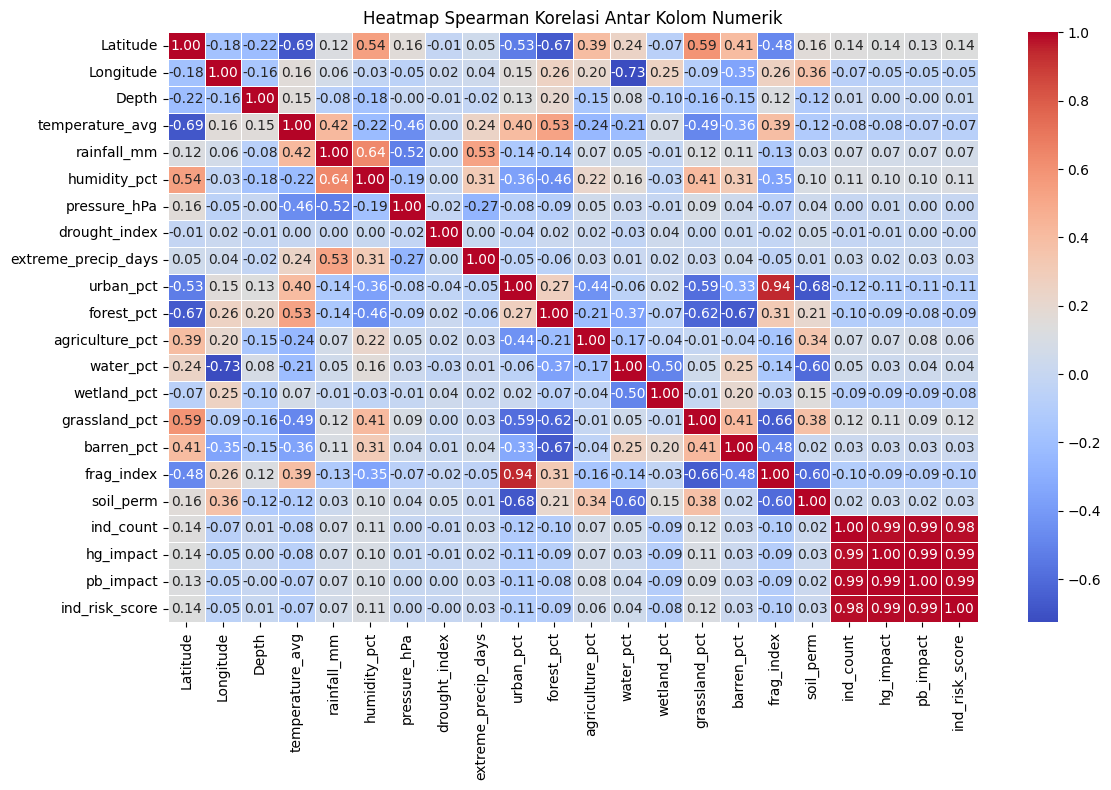

📌 Pasangan fitur dengan korelasi Spearman ≥ 0.8:

            Fitur 1         Fitur 2  Korelasi
439       pb_impact       hg_impact  0.993819
418       hg_impact       pb_impact  0.993819
397       ind_count       pb_impact  0.987711
438       pb_impact       ind_count  0.987711
440       pb_impact  ind_risk_score  0.987422
461  ind_risk_score       pb_impact  0.987422
460  ind_risk_score       hg_impact  0.987003
419       hg_impact  ind_risk_score  0.987003
396       ind_count       hg_impact  0.985676
417       hg_impact       ind_count  0.985676
398       ind_count  ind_risk_score  0.984710
459  ind_risk_score       ind_count  0.984710
204       urban_pct      frag_index  0.943540
345      frag_index       urban_pct  0.943540


In [88]:
def cek_korelasi(df, threshold=0.8):
    print("📊 Korelasi Spearman antar fitur numerik (hubungan monotonik):\n")

    # Hitung korelasi Spearman
    corr_matrix = df.corr(method='spearman', numeric_only=True)

    # Tampilkan tabel korelasi
    print(corr_matrix.round(2))
    print("\n")

    # Visualisasi Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title("Heatmap Spearman Korelasi Antar Kolom Numerik")
    plt.tight_layout()
    plt.show()

    # Ambil pasangan fitur dengan korelasi tinggi (tanpa diagonal)
    mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
    high_corr = corr_matrix.where(mask).stack().reset_index()
    high_corr.columns = ['Fitur 1', 'Fitur 2', 'Korelasi']
    high_corr_filtered = high_corr[abs(high_corr['Korelasi']) >= threshold]

    # Tampilkan pasangan korelasi tinggi
    if not high_corr_filtered.empty:
        print(f"📌 Pasangan fitur dengan korelasi Spearman ≥ {threshold}:\n")
        print(high_corr_filtered.sort_values(by='Korelasi', ascending=False))
    else:
        print(f"✅ Tidak ditemukan korelasi antar fitur ≥ {threshold}")

cek_korelasi(train, threshold=0.8)

##### **Cek korelasi untuk fitur kategorikal (Cramer’s V, ANOVA, Point Biserial)**

**Cramér's V: Korelasi untuk Data Kategorikal**

Cramér's V adalah ukuran **asosiasi antara dua variabel kategorikal**, berbasis pada **uji Chi-Square**. Metode ini digunakan ketika **Pearson** atau **Spearman** tidak dapat diterapkan karena datanya bukan numerik, melainkan **kategori** (misalnya: provinsi, status, jenis kelamin, dll).

---

**Kapan Menggunakan Cramér's V?**

Gunakan Cramér’s V ketika:
- Kedua kolom merupakan **kategori (object/categorical)**
- Ingin mengetahui kekuatan **hubungan antar label/kategori**
- Tidak bisa menggunakan Pearson/Spearman

---

**Rumus Cramér's V**

Diberikan tabel kontingensi dari dua variabel kategorikal:

$$
V = \sqrt{ \frac{\chi^2}{n \cdot \min(k - 1, r - 1)} }
$$

Dimana:
- ( X^2 ) = nilai statistik chi-square
- \( n \) = jumlah total observasi
- \( k \) = jumlah kolom kategori
- \( r \) = jumlah baris kategori

---

**Interpretasi Nilai Cramér's V**

| Nilai V | Interpretasi Umum         |
|---------|----------------------------|
| 0       | Tidak ada asosiasi         |
| 0.1–0.3 | Lemah                      |
| 0.3–0.5 | Sedang                     |
| > 0.5   | Kuat                       |
| 1       | Asosiasi sempurna          |

---

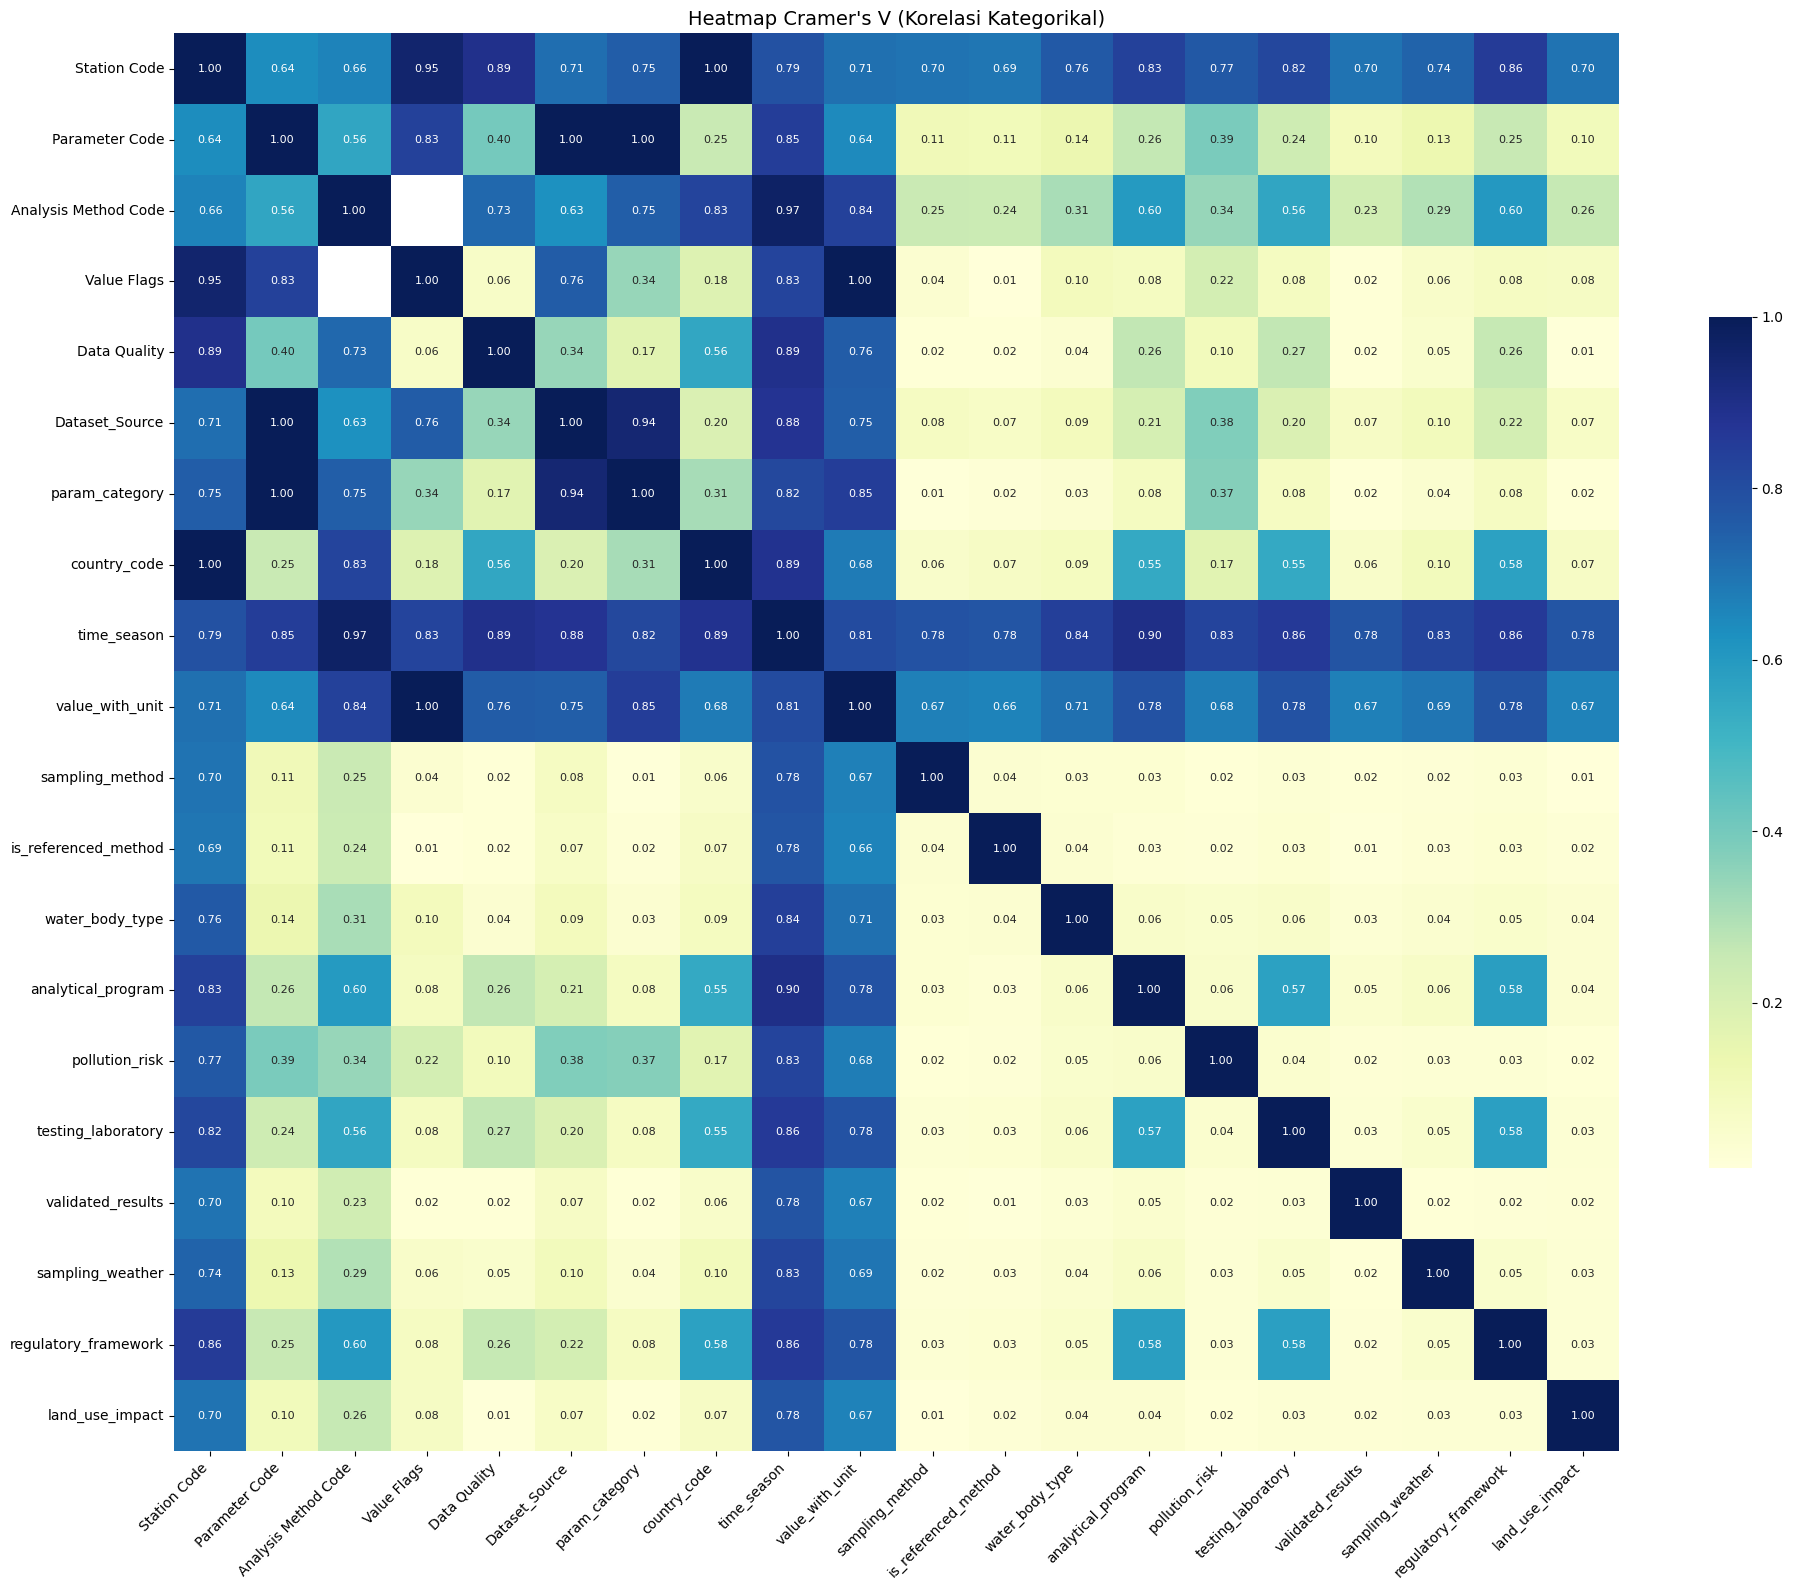

In [86]:
def cramers_v_matrix(df):
    cat_cols = df.select_dtypes(include='object').columns
    result = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                          index=cat_cols, columns=cat_cols)

    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 != col2:
                table = pd.crosstab(df[col1], df[col2])
                chi2 = chi2_contingency(table)[0]
                n = table.sum().sum()
                phi2 = chi2 / n
                r, k = table.shape
                v = np.sqrt(phi2 / min(k - 1, r - 1))
                result.loc[col1, col2] = v
            else:
                result.loc[col1, col2] = 1.0
    return result

def plot_cramers_heatmap(corr_matrix):
    plt.figure(figsize=(20, 16))  # Ubah ukuran heatmap (lebar x tinggi)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGnBu',
                annot_kws={"size": 8},  # Ukuran teks angka
                cbar_kws={"shrink": 0.6})  # Ukuran colorbar
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Font & rotasi label x
    plt.yticks(fontsize=10)  # Font label y
    plt.title("Heatmap Cramer's V (Korelasi Kategorikal)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualisasi
cramer_corr = cramers_v_matrix(train)
plot_cramers_heatmap(cramer_corr)

##### **Cek korelasi antar semua kolom (Numerik dan kategorikal)**

**Korelasi Gabungan dengan `mixed_correlation_matrix(df)`**

Fungsi ini digunakan untuk menghitung **matriks korelasi antar semua kolom** dalam sebuah dataset, baik itu kolom **numerik**, **kategorikal**, maupun **biner**, menggunakan metode korelasi yang **disesuaikan dengan jenis data**.

---

**Metode Korelasi Berdasarkan Kombinasi Tipe Kolom**

| Kombinasi Kolom               | Metode yang Digunakan     | Penjelasan |
|-------------------------------|----------------------------|------------|
| Numerik vs Numerik            | `Spearman`                | Mengukur hubungan monotonik (naik/turun) menggunakan peringkat |
| Kategorikal vs Kategorikal    | `Cramér’s V`              | Mengukur asosiasi antar dua variabel kategorikal |
| Kategorikal vs Numerik        | Approximate via `Chi-Square` | Membagi numerik ke kuantil (`qcut`) lalu diuji dengan chi-square |
| Biner (0/1) vs Numerik        | `Point-Biserial`          | Versi Pearson khusus untuk variabel biner dan numerik |
| Kasus lain                    | `np.nan`                  | Diberi nilai NaN karena tidak relevan |

---

**Kenapa Menggunakan Spearman untuk Numerik?**

- **Spearman** lebih cocok untuk menangani hubungan **non-linear tapi monotonik**.
- Lebih **tahan terhadap outlier** dibanding Pearson.
- Cocok saat data tidak berdistribusi normal atau mengandung nilai ekstrem.


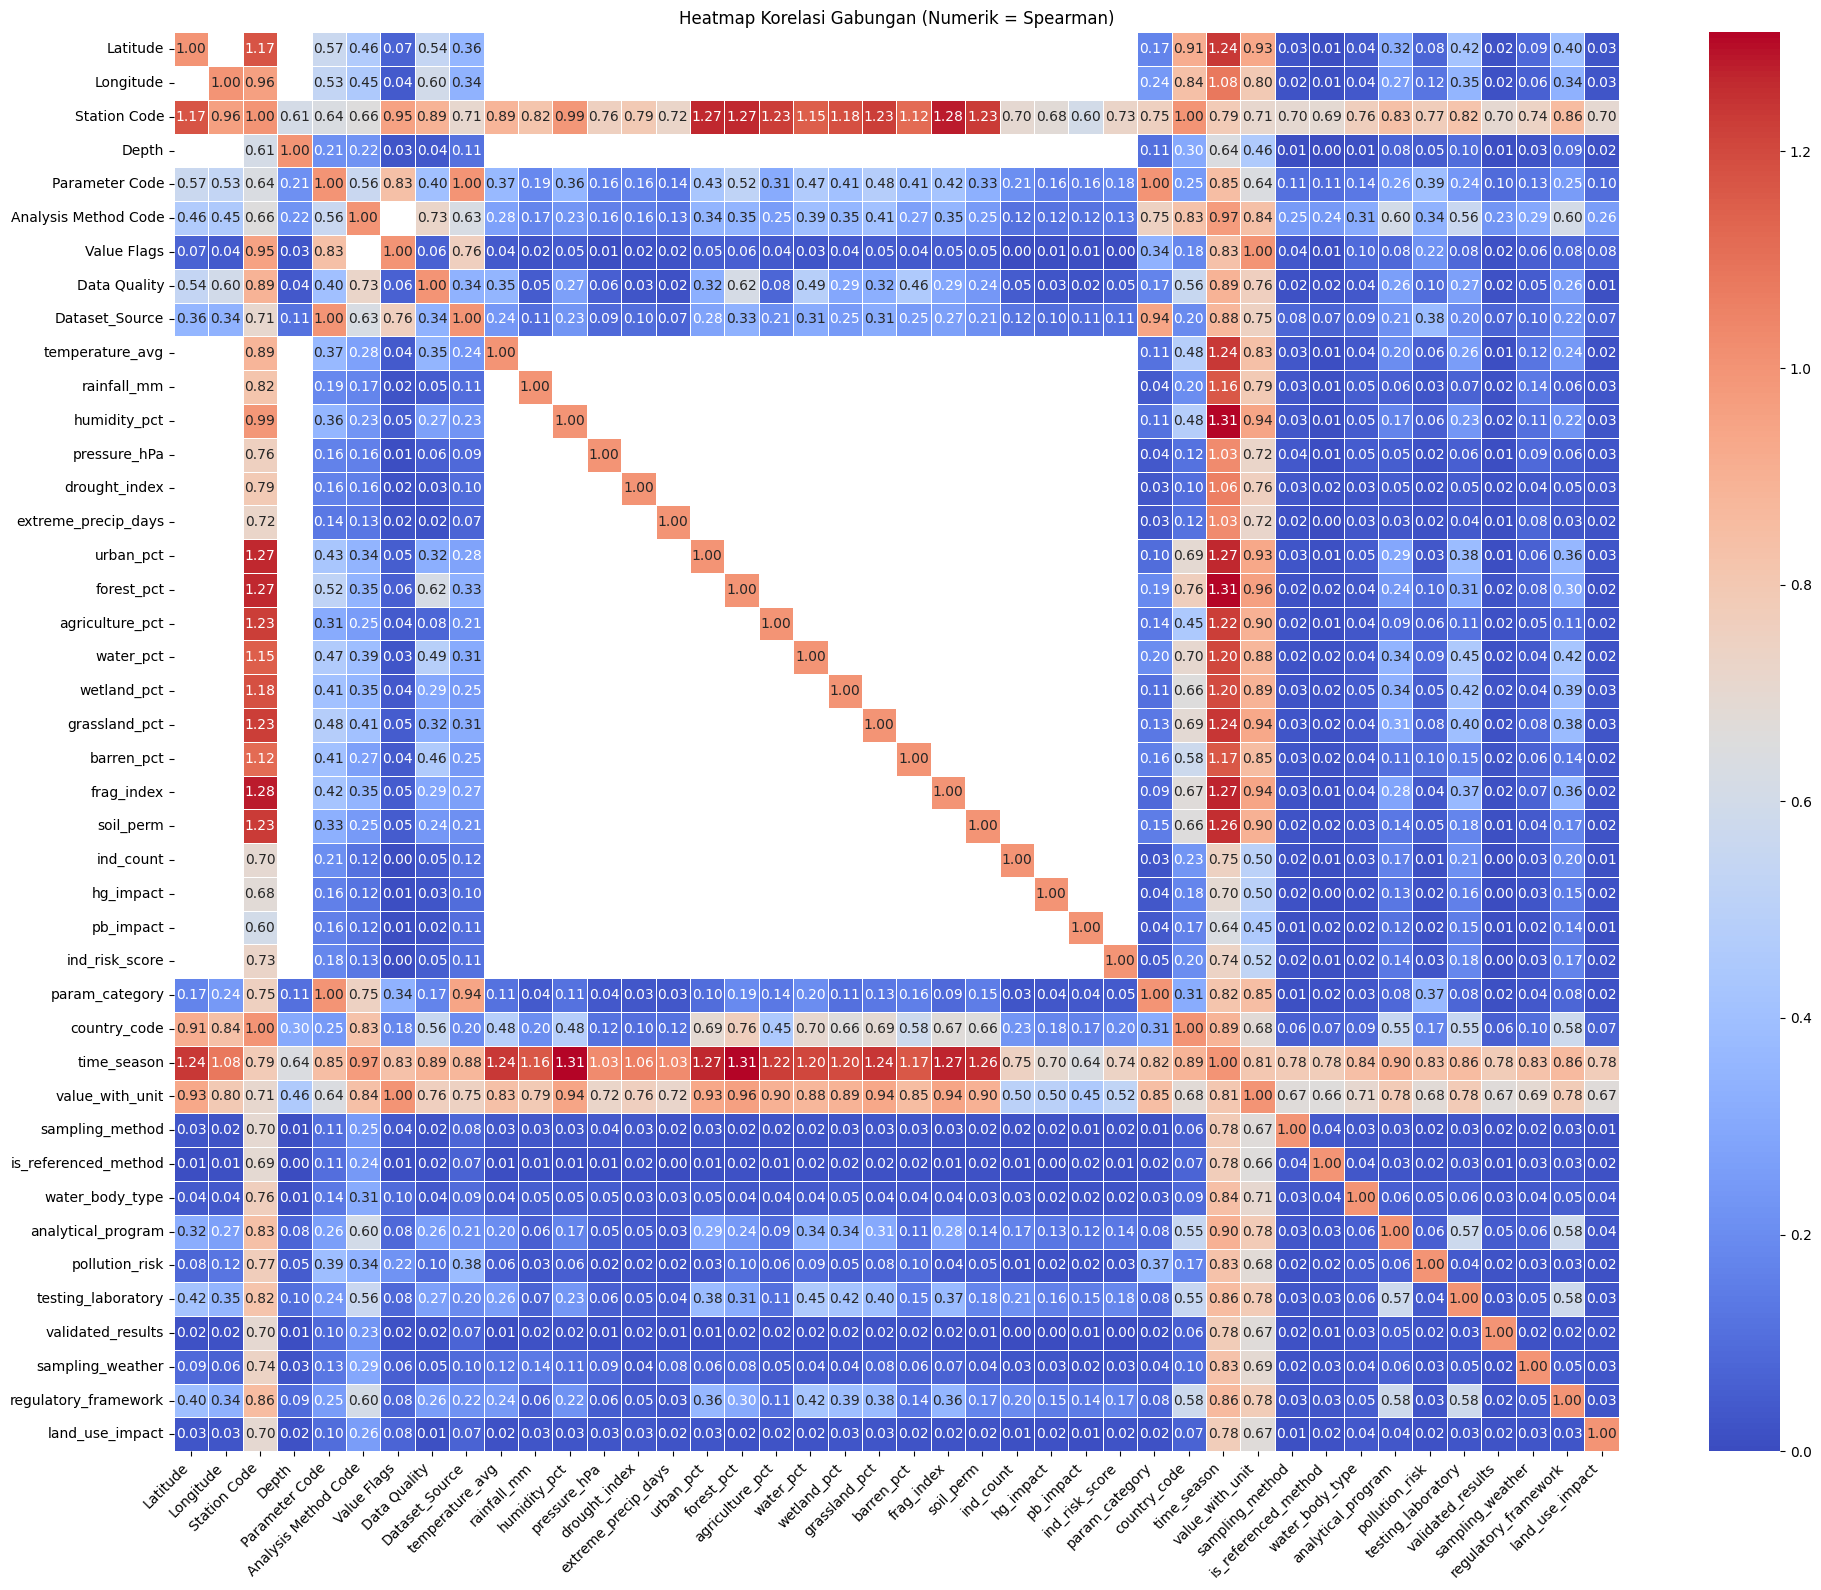

In [124]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1)) if min(k, r) > 1 else np.nan

def mixed_correlation_matrix(df):
    cols = df.columns
    result = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

    for i in cols:
        for j in cols:
            if i == j:
                result.loc[i, j] = 1.0
                continue

            xi, xj = df[i], df[j]

            try:
                # Numerik vs numerik (gunakan Spearman)
                if np.issubdtype(xi.dtype, np.number) and np.issubdtype(xj.dtype, np.number):
                    result.loc[i, j] = spearmanr(xi.dropna(), xj.dropna())[0]

                # Kategorikal vs kategorikal
                elif xi.dtype == 'object' and xj.dtype == 'object':
                    result.loc[i, j] = cramers_v(xi, xj)

                # Kategorikal vs numerik
                elif xi.dtype == 'object' and np.issubdtype(xj.dtype, np.number):
                    result.loc[i, j] = np.sqrt(chi2_contingency(pd.crosstab(xi, pd.qcut(xj, q=4, duplicates='drop')))[0] / len(xi))

                elif xj.dtype == 'object' and np.issubdtype(xi.dtype, np.number):
                    result.loc[i, j] = np.sqrt(chi2_contingency(pd.crosstab(xj, pd.qcut(xi, q=4, duplicates='drop')))[0] / len(xj))

                # Boolean/biner vs numerik
                elif set(xi.dropna().unique()).issubset({0, 1}) and np.issubdtype(xj.dtype, np.number):
                    result.loc[i, j] = pointbiserialr(xi, xj)[0]

                elif set(xj.dropna().unique()).issubset({0, 1}) and np.issubdtype(xi.dtype, np.number):
                    result.loc[i, j] = pointbiserialr(xj, xi)[0]

                else:
                    result.loc[i, j] = np.nan

            except:
                result.loc[i, j] = np.nan

    return result

corr_all = mixed_correlation_matrix(train)

plt.figure(figsize=(20, 16))
sns.heatmap(corr_all, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Gabungan (Numerik = Spearman)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Cek Outlier

##### **Cek outlier menggunakan Boxplot**

**Analisis Outlier dengan Boxplot**

Pada tahap ini, kita akan melakukan **deteksi outlier** pada semua **kolom numerik** dalam dataset menggunakan **visualisasi boxplot**. Tujuannya adalah untuk:

- Mengetahui sebaran nilai tiap fitur numerik
- Mengidentifikasi **nilai-nilai ekstrem (outlier)** yang berada di luar rentang normal

---

**Langkah-langkah:**

**1. Seleksi Kolom Numerik**
Kita hanya mengambil kolom dengan tipe data numerik:

```python
numeric_cols = train.select_dtypes(include='number')
```

---

**2. Menentukan Layout Visualisasi**
Untuk menampilkan banyak plot sekaligus, kita atur layout grid:

```python
n_cols = 3
n_rows = -(-len(numeric_cols.columns) // n_cols)  # ceiling division
```

---

**3. Visualisasi Boxplot**
Kita membuat subplot dan boxplot untuk setiap kolom numerik:

```python
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, col in enumerate(numeric_cols.columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.boxplot(x=numeric_cols[col])
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Boxplot untuk Deteksi Outlier Tiap Fitur Numerik", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
```

---

**Cara Membaca Boxplot:**

- **Garis tengah kotak** = median (Q2)
- **Tepi kotak** = kuartil bawah (Q1) dan atas (Q3)
- **Whisker** = rentang data normal (Q1 - 1.5×IQR s.d. Q3 + 1.5×IQR)
- **Titik di luar whisker** = **outlier**

---

**Kesimpulan**

Boxplot membantu kita mengenali kolom mana yang:
- Memiliki nilai ekstrem (misalnya Depth, Rainfall, dll)
- Perlu ditangani lebih lanjut sebelum modeling (imputasi, scaling, trimming)

Langkah ini sangat penting dalam tahap **EDA (Exploratory Data Analysis)** untuk memastikan kualitas dan integritas data sebelum modeling.

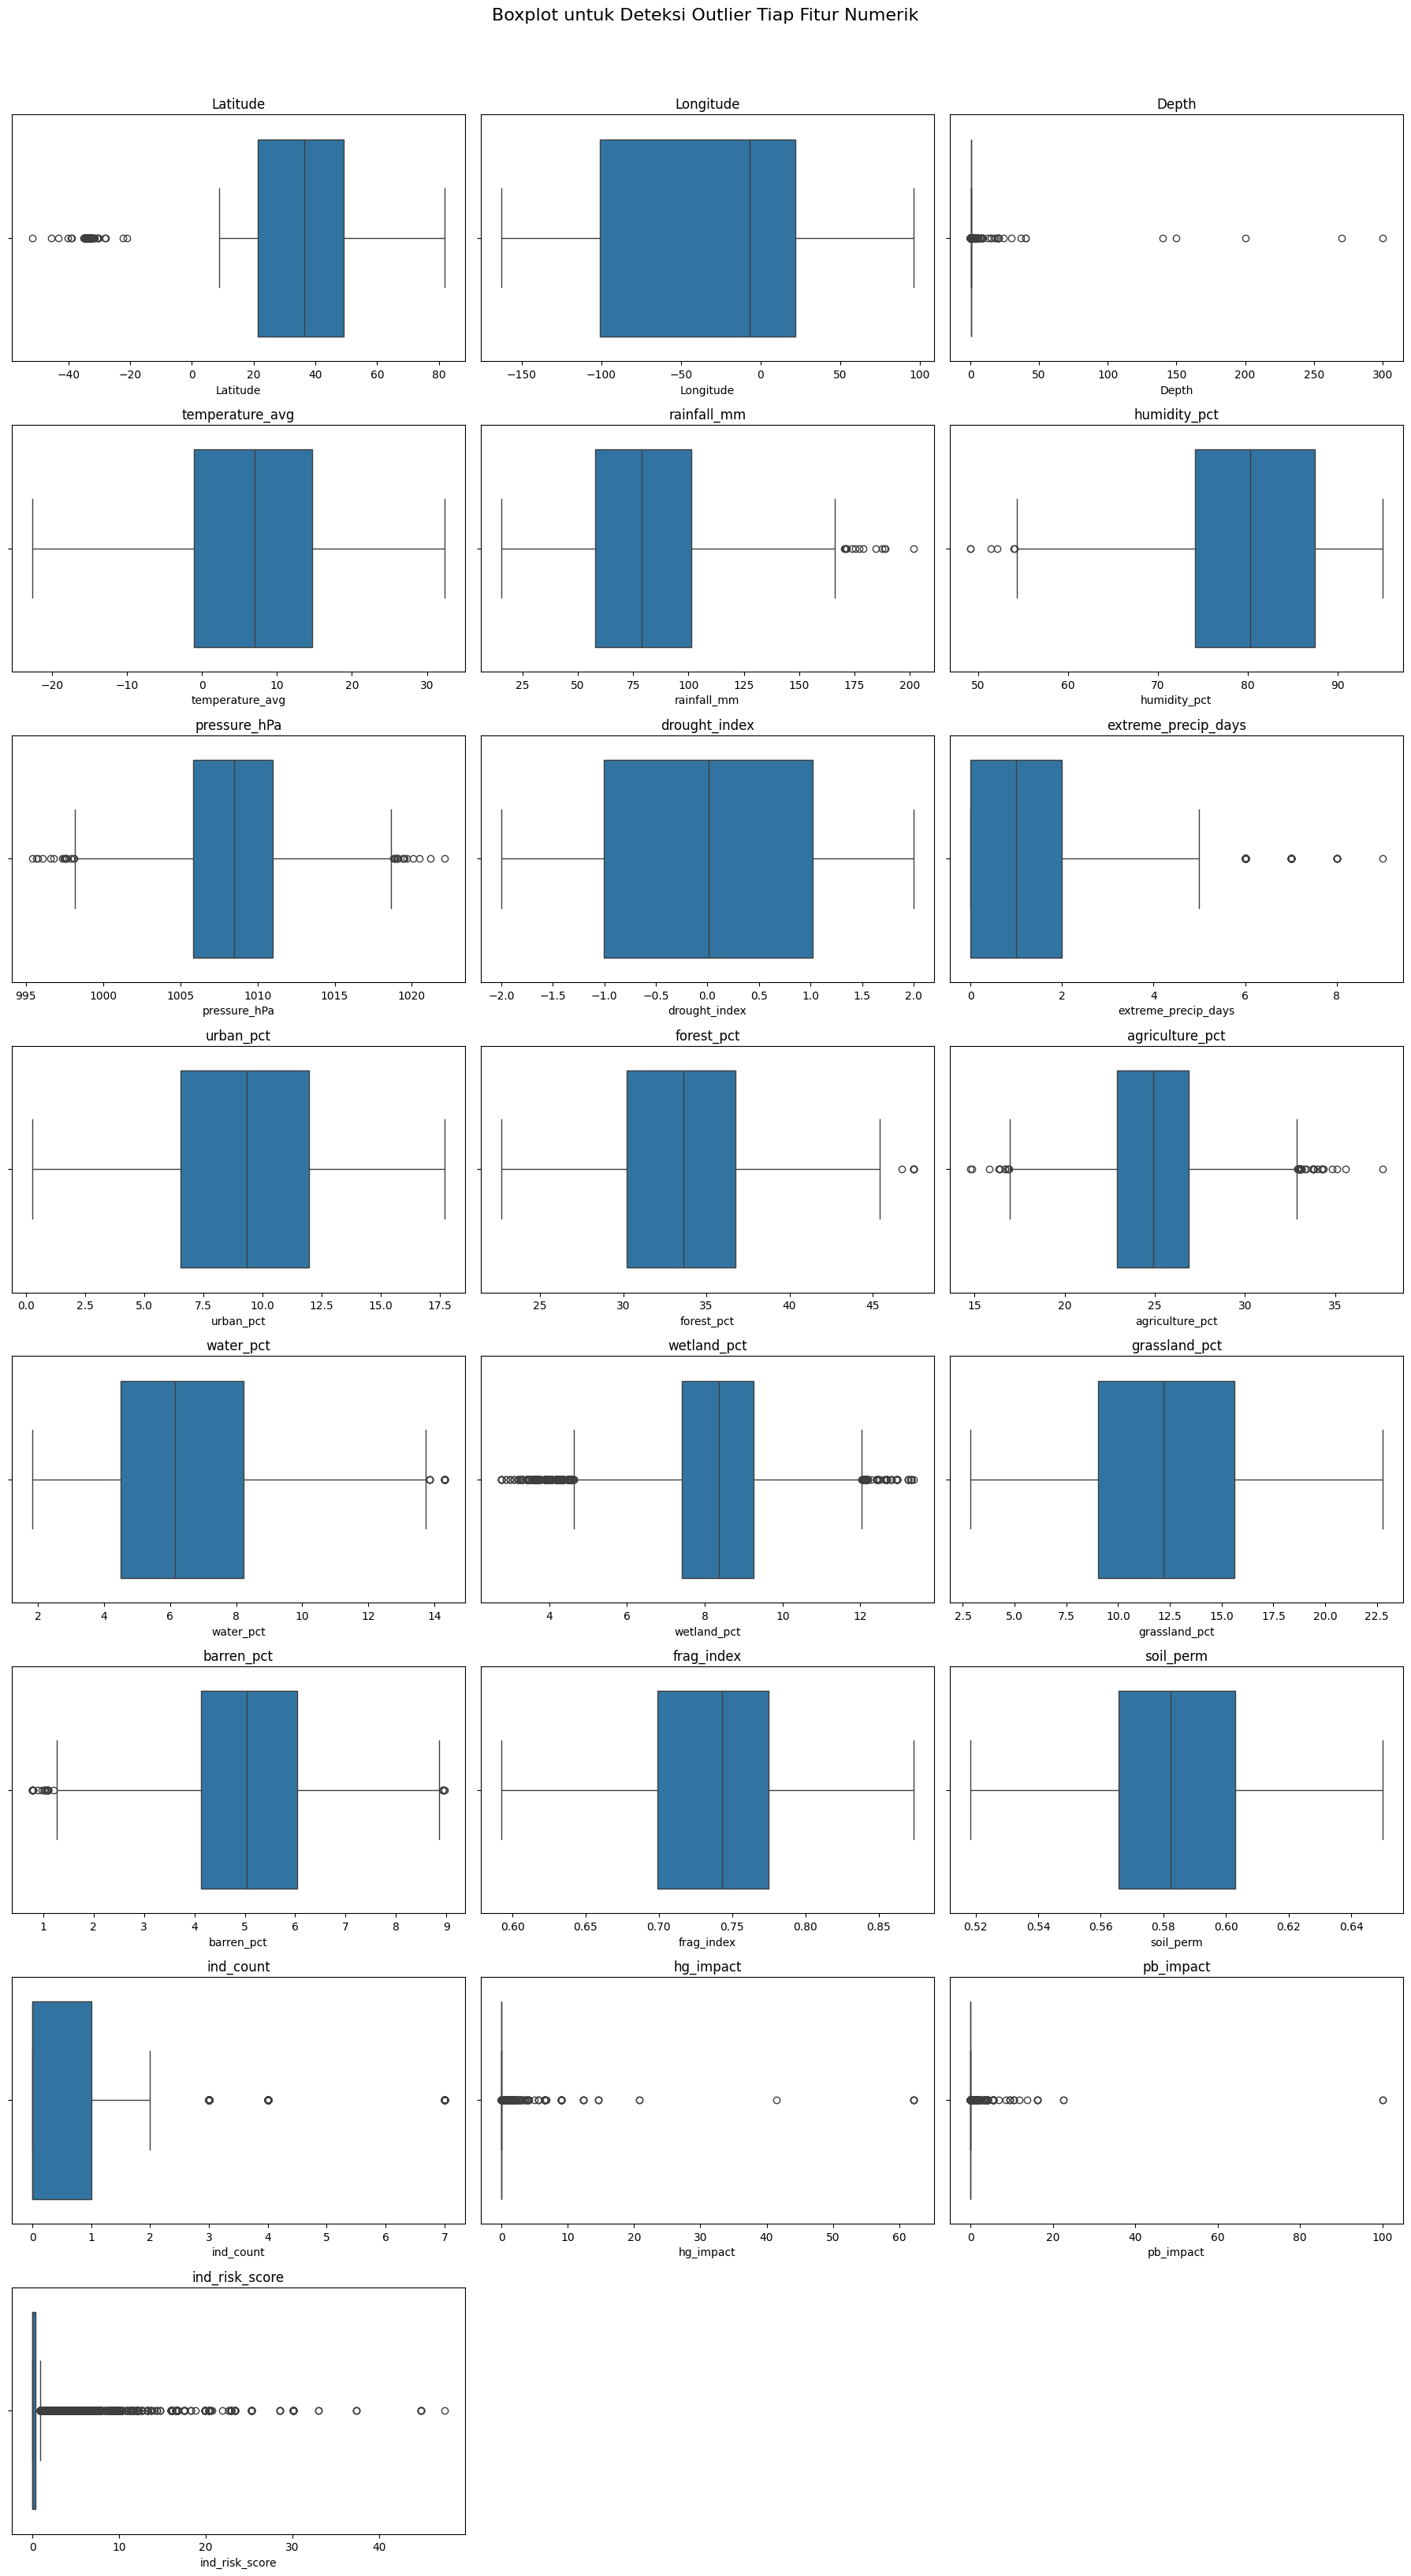

In [6]:

# Ambil hanya kolom numerik dari dataset
numeric_cols = train.select_dtypes(include='number')

# Buat plot boxplot untuk semua kolom numerik
n_cols = 3
n_rows = -(-len(numeric_cols.columns) // n_cols)  # Ceiling division

plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, col in enumerate(numeric_cols.columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.boxplot(x=numeric_cols[col])
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Boxplot untuk Deteksi Outlier Tiap Fitur Numerik", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#### Cek variansi data minor pada setiap kolom

##### **Cek variansi data minor pada fitur numerik menggunakan `VarianceThreshold`**

**Deteksi Fitur Numerik dengan Variansi Rendah**

Pada bagian ini, kita akan melakukan analisis untuk mendeteksi **fitur numerik yang memiliki variansi sangat rendah**. Fitur semacam ini dianggap **tidak informatif** karena nilainya tidak berubah banyak antar baris, sehingga tidak berkontribusi signifikan dalam model machine learning.

---

**Tujuan**

- Menemukan kolom dengan **sebaran nilai kecil** atau hampir konstan.
- Menghapus fitur yang tidak memiliki variasi untuk **mengurangi kompleksitas model**.

---

**Konsep Variansi**

Variansi mengukur **seberapa jauh nilai-nilai dalam data tersebar dari rata-rata**. Secara matematis:

$$
Var(X) = \frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2
$$

di mana:
- \( x_i \): nilai ke-i
- \( \mu \): rata-rata dari seluruh nilai
- \( n \): jumlah sampel

Semakin kecil variansi, semakin kecil penyebaran data.

---

**Metode: VarianceThreshold (Sklearn)**

`VarianceThreshold` adalah metode dari `sklearn.feature_selection` yang secara otomatis:
- Menghapus fitur dengan variansi di bawah ambang batas
- Default ambang batas: 0.0 (fitur konstan)
- Kita gunakan ambang **0.01** untuk mendeteksi fitur yang nyaris konstan

---

In [4]:
# 1. Ambil kolom numerik
numeric_cols = train.select_dtypes(include='number')

# 2. Hapus missing values (sementara, hanya untuk kebutuhan VarianceThreshold)
numeric_clean = numeric_cols.dropna()

# 3. Terapkan VarianceThreshold (dengan ambang batas 0.01)
selector = VarianceThreshold(threshold=0.01)
selector.fit(numeric_clean)

# 4. Ambil fitur yang variansinya rendah
low_var_cols = numeric_clean.columns[~selector.get_support()]
low_variance_report = pd.DataFrame({
    'Fitur': low_var_cols,
    'Variansi': numeric_clean[low_var_cols].var().values
}).sort_values(by='Variansi')

# 5. Tampilkan hasil
print("📉 Fitur dengan Variansi Rendah (< 0.01):\n")
display(low_variance_report)

📉 Fitur dengan Variansi Rendah (< 0.01):



Fitur  Variansi
1   soil_perm  0.000969
0  frag_index  0.005240

##### **Cek variansi data minor untuk kategorikal menggunakan `Top Ratio Kategorikal`**

**Analisis Top Ratio pada Kolom Kategorikal**

Pada analisis ini, kita mengevaluasi **tingkat dominasi kategori tertinggi** (Top Ratio) pada setiap kolom kategorikal dalam dataset. Tujuannya adalah untuk mendeteksi **fitur yang tidak bervariasi**, yang mungkin tidak memberikan informasi penting dalam proses pemodelan.

---

**Langkah Analisis**

**1. Ambil Semua Kolom Kategorikal**
Gunakan `select_dtypes(include='object')` untuk menyeleksi kolom bertipe kategorikal dari dataset.

**2. Hitung Rasio Frekuensi Kategori Tertinggi (Top Ratio)**

Untuk setiap kolom:
- Hitung proporsi kemunculan masing-masing nilai dengan `value_counts(normalize=True)`
- Ambil nilai proporsi tertinggi sebagai **Top Ratio**

---

**Definisi Top Ratio**

Secara matematis:

$$
\text{TopRatio}(X) = \max_{x_i \in X} \left( \frac{\text{count}(x_i)}{\sum_{j} \text{count}(x_j)} \right)
$$

Di mana:
- \( x_i \) adalah kategori ke-\( i \) dalam kolom \( X \)
- \( \text{count}(x_i) \) adalah jumlah kemunculan kategori \( x_i \)

---

**Interpretasi Top Ratio**

| Nilai Top Ratio | Interpretasi                          |
|------------------|----------------------------------------|
| > 0.95           | Kategori sangat dominan, fitur tidak bervariasi |
| 0.80 – 0.95      | Perlu perhatian, dominasi tinggi    |
| < 0.50           | Distribusi kategori cukup merata    |

---

**Kegunaan**

- Menemukan fitur dengan **informasi rendah**
- Menyaring kolom yang bisa dihapus atau disederhanakan (misalnya, digabung jadi "Lainnya")
- Membantu memahami **keseimbangan kategori** sebelum melakukan encoding

---

**Contoh Aplikasi**

Jika kolom `provinsi` memiliki distribusi:

| Provinsi     | Jumlah |
|--------------|--------|
| Jawa Timur   | 9800   |
| Lainnya      | 200    |

Maka:

$$
\text{TopRatio}(\text{provinsi}) = \frac{9800}{9800 + 200} = 0.98
$$

→ Artinya, fitur ini sangat tidak bervariasi.

---

In [6]:
# 1. Ambil semua kolom kategorikal
cat_cols = train.select_dtypes(include='object').columns

# 2. Hitung rasio frekuensi tertinggi (Top Ratio) untuk tiap kolom
top_ratios = []

for col in cat_cols:
    freqs = train[col].value_counts(normalize=True, dropna=False)
    top_ratio = freqs.iloc[0] if not freqs.empty else None
    top_ratios.append((col, top_ratio))

# 3. Buat DataFrame dari hasil
top_ratio_df = pd.DataFrame(top_ratios, columns=["Kolom", "Top Ratio (Dominasi Terbesar)"])
top_ratio_df = top_ratio_df.sort_values(by="Top Ratio (Dominasi Terbesar)", ascending=False)

# 4. Tampilkan hasil
print("📊 Rasio Dominasi Tertinggi untuk Setiap Kolom Kategorikal:\n")
display(top_ratio_df)

📊 Rasio Dominasi Tertinggi untuk Setiap Kolom Kategorikal:



Kolom  Top Ratio (Dominasi Terbesar)
3            Value Flags                       0.844978
2   Analysis Method Code                       0.828475
16     validated_results                       0.729247
4           Data Quality                       0.723889
15    testing_laboratory                       0.663380
18  regulatory_framework                       0.612087
13    analytical_program                       0.484998
12       water_body_type                       0.473925
11  is_referenced_method                       0.465567
5         Dataset_Source                       0.443778
14        pollution_risk                       0.414202
0           Station Code                       0.382912
17      sampling_weather                       0.358265
9        value_with_unit                       0.321403
6         param_category                       0.317831
7           country_code                       0.316617
19       land_use_impact                       0.227533
10       sampling_method                       0.179311
1         Parameter Code                       0.121232
8            time_season                       0.070010

## Data Preprocessing (train.csv)

#### Handle data type

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13998 entries, 0 to 13997
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Latitude              10388 non-null  float64
 1   Longitude             6925 non-null   float64
 2   Station Code          8638 non-null   object 
 3   Depth                 9553 non-null   float64
 4   Parameter Code        12301 non-null  object 
 5   Analysis Method Code  2401 non-null   object 
 6   Value Flags           2170 non-null   object 
 7   Data Quality          13998 non-null  object 
 8   Dataset_Source        7786 non-null   object 
 9   temperature_avg       9481 non-null   float64
 10  rainfall_mm           8824 non-null   float64
 11  humidity_pct          13149 non-null  float64
 12  pressure_hPa          7184 non-null   float64
 13  drought_index         8019 non-null   float64
 14  extreme_precip_days   11975 non-null  float64
 15  urban_pct          

In [93]:
train.dtypes.value_counts()

float64    22
object     20
Name: count, dtype: int64

**Diubah menjadi tipe boolean untuk column `is_referenced_method` dan `validated_results`**

In [94]:
train['is_referenced_method'] = train['is_referenced_method'].astype('boolean')
train['validated_results'] = train['validated_results'].astype('boolean')

**Mengubah kolom `value_with_unit` menjadi kolom baru yang mana nilai satuan nya sama semua berupa `mg/L` dan memisahkan antara satuan dengan numerik supaya tabelnya bisa berupa `float`**

In [95]:
# Salin dan bersihkan kolom 'value_with_unit'
value_series = train['value_with_unit'].astype(str)

# Tangani format seperti "<0.1 mg/l" → hilangkan simbol dan spasi aneh
value_series = value_series.str.replace(r'[<>=]', '', regex=True)

# Ekstraksi angka dan satuan ke kolom baru
extracted = value_series.str.extract(r'([\d\.]+)\s*([^\d\s]+(?:/\w+)?|%)?')
extracted.columns = ['value_numeric', 'value_unit']

# Konversi angka ke float
extracted['value_numeric'] = pd.to_numeric(extracted['value_numeric'], errors='coerce')

# Tambahkan ke DataFrame utama
train['value_numeric'] = extracted['value_numeric']
train['value_unit'] = extracted['value_unit']

# Konversi semua nilai ke satuan standar mg/L
train['value_mg_per_l'] = np.nan

for i, row in train.iterrows():
    value = row['value_numeric']
    unit = row['value_unit']

    if pd.isna(value) or pd.isna(unit):
        continue
    unit = unit.lower().strip()

    if unit in ['µg/l', 'ug/l']:
        train.at[i, 'value_mg_per_l'] = value / 1000
    elif unit == 'ng/l':
        train.at[i, 'value_mg_per_l'] = value / 1_000_000
    elif unit == 'mg/l':
        train.at[i, 'value_mg_per_l'] = value
    elif unit == '%':
        train.at[i, 'value_mg_per_l'] = value / 100
    else:
        continue

# Drop kolom - kolom yang sekiranya tidak digunakan
train.drop(columns=['value_with_unit', 'value_numeric', 'value_unit'], inplace=True)

display(train[['value_mg_per_l']].head(20))

value_mg_per_l
0           0.0000
1              NaN
2           0.0001
3              NaN
4           0.0017
5           0.1400
6              NaN
7           0.0115
8              NaN
9              NaN
10          1.0330
11          0.1000
12             NaN
13             NaN
14          0.0000
15             NaN
16         96.2400
17             NaN
18             NaN
19         88.6519

#### Handle missing value

 **Cek missing value pada masing masing kolom di data train**

In [96]:
missing_percentage = train.isnull().mean() * 100
dtypes = train.dtypes

# Gabungkan keduanya dalam satu DataFrame
missing_info = pd.DataFrame({
    'Data Type': dtypes,
    'Missing (%)': missing_percentage
})

# Urutkan dari yang paling banyak missing value
missing_info = missing_info.sort_values(by='Missing (%)', ascending=False)

print(missing_info)

                     Data Type  Missing (%)
Value Flags             object    84.497785
Analysis Method Code    object    82.847550
Longitude              float64    50.528647
pressure_hPa           float64    48.678383
analytical_program      object    48.499786
water_body_type         object    47.392485
Dataset_Source          object    44.377768
drought_index          float64    42.713245
pollution_risk          object    41.420203
value_mg_per_l         float64    41.041577
pb_impact              float64    40.484355
Station Code            object    38.291184
rainfall_mm            float64    36.962423
sampling_weather        object    35.826547
barren_pct             float64    32.561795
temperature_avg        float64    32.268896
Depth                  float64    31.754536
country_code            object    31.661666
water_pct              float64    28.696957
param_category          object    28.032576
Latitude               float64    25.789398
hg_impact              float64  

**Melakukan drop column untuk kolom dengan missing value > 60%**

In [97]:
drop_cols = ['Analysis Method Code', 'Value Flags']
train.drop(columns=drop_cols, inplace=True)

**KNN Imputer untuk 6 Kolom Terpilih**

Pada 6 kolom berikut dipilih metode imputasi menggunakan **KNNImputer**, karena alasan:

- Bertipe **numerik**
- Memiliki **missing value** antara **5%–40%**
- Saling **berkaitan secara logis** (terutama topik cuaca dan lingkungan)
- Memiliki **distribusi variatif**, sehingga **mean/median** kurang representatif

**Kolom-kolom yang Diimputasi dengan KNN:**

- `temperature_avg`  
  - Suhu → berkaitan langsung dengan cuaca dan musim
- `rainfall_mm`  
  - Curah hujan → sangat mungkin berkorelasi dengan kelembapan dan suhu
- `humidity_pct`  
  - Kelembapan → saling memengaruhi dengan suhu dan curah hujan
- `urban_pct`  
  - Persentase area urban → dapat diprediksi dari fitur lingkungan sekitarnya
- `ind_risk_score`  
  - Skor risiko industri → dipengaruhi fitur industri lain seperti `ind_count`, `hg_impact`
- `value_numeric`  
  - Nilai terukur dari `value_with_unit` → penting untuk estimasi hasil analisis

KNNImputer mencari nilai berdasarkan **kemiripan baris** secara multivariat. Ini lebih cerdas daripada hanya mengambil rata-rata, karena:

- Mempertimbangkan konteks dari **fitur lain**
- Menghindari bias dari distribusi data yang skewed


In [98]:
# 1. Tentukan kolom yang akan diimputasi dengan KNN
knn_candidate_cols = [
    'temperature_avg',
    'rainfall_mm',
    'humidity_pct',
    'urban_pct',
    'Latitude'
]

# 2. Salin subset data yang akan diimputasi
df_knn_input = train[knn_candidate_cols].copy()

# 3. Inisialisasi KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# 4. Jalankan imputasi
df_knn_imputed = pd.DataFrame(
    imputer.fit_transform(df_knn_input),
    columns=knn_candidate_cols
)

# 5. Masukkan kembali hasil imputasi ke dalam DataFrame utama
train[knn_candidate_cols] = df_knn_imputed

# 6. Cek apakah masih ada missing value
print("Cek missing value setelah imputasi KNN:")
print(train[knn_candidate_cols].isnull().sum())

Cek missing value setelah imputasi KNN:
temperature_avg    0
rainfall_mm        0
humidity_pct       0
urban_pct          0
Latitude           0
dtype: int64


**Cek berdasarkan nilai skewed**

In [99]:
# Hitung skewness untuk semua kolom numerik
skew_values = train.select_dtypes(include=['float64', 'int64']).skew()

# Tampilkan nilai skewness
print(skew_values.sort_values(ascending=False))


pb_impact              47.773326
Depth                  46.315931
hg_impact              32.953024
value_mg_per_l         18.199550
ind_risk_score          4.568537
ind_count               3.497681
extreme_precip_days     1.214570
water_pct               0.676647
rainfall_mm             0.386139
Longitude               0.180425
soil_perm               0.113614
forest_pct              0.104948
grassland_pct           0.070357
agriculture_pct         0.027152
drought_index          -0.000597
pressure_hPa           -0.032435
temperature_avg        -0.054067
urban_pct              -0.096098
humidity_pct           -0.098235
barren_pct             -0.146860
frag_index             -0.214740
wetland_pct            -0.296170
Latitude               -0.437321
dtype: float64


**Imputasi menggunakan median (untuk kolom yang sangat skewed)**

In [100]:
median_cols = ['Depth', 'extreme_precip_days', 'ind_count', 'hg_impact', 'pb_impact', 'value_mg_per_l', 'ind_risk_score',
               'barren_pct', 'water_pct', 'wetland_pct', 'agriculture_pct', 'grassland_pct', 'forest_pct', 'frag_index']
for col in median_cols:
    median_value = train[col].median()
    train[col].fillna(median_value, inplace=True)

**Imputasi menggunakan Mean (Untuk kolom distribusi normal)**

In [101]:
mean_cols = ['Longitude', 'pressure_hPa', 'drought_index', 'soil_perm']
for col in mean_cols:
    mean_value = train[col].mean()
    train[col].fillna(mean_value, inplace=True)

**Imputasi menggunakan Mode**

In [102]:
# Daftar kolom yang akan diimputasi dengan modus (mode)
mode_cols = ['Station Code', 'Parameter Code', 'Dataset_Source', 'country_code', 'time_season', 'testing_laboratory']

# Imputasi menggunakan nilai mode (nilai yang paling sering muncul)
for col in mode_cols:
    if train[col].isnull().any():
        mode_value = train[col].mode()[0]  # Ambil nilai paling sering muncul
        train[col].fillna(mode_value, inplace=True)

**Imputasi dengan Unknown / Mode**

In [103]:
# Daftar kolom yang akan diisi dengan 'unknown' jika tipenya object/kategorikal
unknown_fill_cols = ['param_category', 'sampling_method', 'pollution_risk', 'analytical_program', 
                     'water_body_type', 'sampling_weather', 'regulatory_framework', 'land_use_impact']

for col in unknown_fill_cols:
    if train[col].dtype == 'object':
        train[col].fillna('unknown', inplace=True)

# Untuk kolom boolean → isi dengan modus (True/False mayoritas)
bool_mode_cols = ['is_referenced_method', 'validated_results']

for col in bool_mode_cols:
    if train[col].dtype.name == 'boolean' or train[col].dropna().isin([True, False]).all():
        mode_val = train[col].mode(dropna=True)[0]
        train[col].fillna(mode_val, inplace=True)


**Cek kembali untuk percentage dari masing - masing kolom**

In [104]:
missing_percentage = train.isnull().mean() * 100
dtypes = train.dtypes

# Gabungkan keduanya dalam satu DataFrame
missing_info = pd.DataFrame({
    'Data Type': dtypes,
    'Missing (%)': missing_percentage
})

# Urutkan dari yang paling banyak missing value
missing_info = missing_info.sort_values(by='Missing (%)', ascending=False)

print(missing_info)

                     Data Type  Missing (%)
Latitude               float64          0.0
Longitude              float64          0.0
Station Code            object          0.0
Depth                  float64          0.0
Parameter Code          object          0.0
Data Quality            object          0.0
Dataset_Source          object          0.0
temperature_avg        float64          0.0
rainfall_mm            float64          0.0
humidity_pct           float64          0.0
pressure_hPa           float64          0.0
drought_index          float64          0.0
extreme_precip_days    float64          0.0
urban_pct              float64          0.0
forest_pct             float64          0.0
agriculture_pct        float64          0.0
water_pct              float64          0.0
wetland_pct            float64          0.0
grassland_pct          float64          0.0
barren_pct             float64          0.0
frag_index             float64          0.0
soil_perm              float64  

#### Handle Data Imbalance

**Cek data imbalance pada masing - masing kolom**

In [ ]:
def detect_imbalanced_columns(df, threshold=0.10, max_unique=15):
    result = []

    for col in df.columns:
        if df[col].dtype in ['object', 'bool'] or df[col].nunique() <= max_unique:
            value_counts = df[col].value_counts(normalize=True, dropna=False)
            min_pct = value_counts.min()
            if min_pct < threshold:
                result.append({
                    "Column": col,
                    "Num Unique": df[col].nunique(),
                    "Most Frequent (%)": round(value_counts.max() * 100, 2),
                    "Least Frequent (%)": round(min_pct * 100, 2),
                    "Imbalanced?": "Yes"
                })

    return pd.DataFrame(result).sort_values(by="Least Frequent (%)")

# Jalankan pada DataFrame kamu
imbalanced_cols_df = detect_imbalanced_columns(train)

# Tampilkan hasil
from IPython.display import display
display(imbalanced_cols_df)

Column  Num Unique  Most Frequent (%)  Least Frequent (%)  \
0           Station Code        3970              38.61                0.01   
1         Parameter Code         121              17.87                0.01   
3         Dataset_Source          39              49.64                0.01   
4    extreme_precip_days          10              38.73                0.01   
7           country_code          34              48.96                0.01   
8            time_season        7618               7.09                0.01   
12    testing_laboratory          11              84.75                0.04   
10    analytical_program          11              48.50                0.05   
14  regulatory_framework          10              61.21                0.06   
2           Data Quality           4              72.39                0.17   
5              ind_count           6              77.95                0.46   
6         param_category           6              31.78                3.29   
11        pollution_risk           5              41.42                4.20   
9        water_body_type           9              47.39                6.11   
13      sampling_weather           7              35.83                7.13   

   Imbalanced?  
0          Yes  
1          Yes  
3          Yes  
4          Yes  
7          Yes  
8          Yes  
12         Yes  
10         Yes  
14         Yes  
2          Yes  
5          Yes  
6          Yes  
11         Yes  
9          Yes  
13         Yes

**Mengatasi imbalance menggunakan Target Encoding**

In [ ]:
# 2. Buat mapping numerik untuk kolom target 'Data Quality'
label_map = {
    'Fair': 0,
    'Unknown': 1,
    'Good': 2,
    'Pending review': 2  # Gabungkan Good + Pending review
}
train['Data_Quality_Num'] = train['Data Quality'].map(label_map)

# 3. Tentukan kolom-kolom yang ingin di-encode
target_encode_cols = ['Station Code', 'Parameter Code', 'Dataset_Source']

# 4. Lakukan target encoding & simpan di kolom baru
for col in target_encode_cols:
    mean_encoded = train.groupby(col)['Data_Quality_Num'].mean()
    train[col + '_encoded'] = train[col].map(mean_encoded)

# 5. Drop kolom aslinya jika sudah selesai
train.drop(columns=target_encode_cols, inplace=True)

# 6. (Opsional) Hapus kolom mapping target jika tidak diperlukan lagi
train.drop(columns=['Data_Quality_Num'], inplace=True)

**Menggunakan Label Grouping**

In [ ]:
# Fungsi untuk mengganti kategori langka dengan 'other' langsung di train
def group_rare_labels_inplace(df, col, threshold=0.05):
    value_counts = df[col].value_counts(normalize=True)
    rare_labels = value_counts[value_counts < threshold].index
    df[col + '_grouped'] = df[col].apply(lambda x: 'other' if x in rare_labels else x)

# Terapkan fungsi pada kolom yang ditargetkan
group_rare_labels_inplace(train, 'water_body_type')
group_rare_labels_inplace(train, 'sampling_weather')

# Hapus kolom aslinya (opsional)
train.drop(columns=['water_body_type', 'sampling_weather'], inplace=True)

**Menggunakan `Unknown` untuk beberapa kolom**

In [ ]:
# Daftar kolom yang ingin diimputasi dengan 'unknown'
unknown_cols = ['analytical_program', 'regulatory_framework']

# Lakukan imputasi hanya untuk kolom tersebut
for col in unknown_cols:
    if train[col].isnull().sum() > 0:
        train[col].fillna('unknown', inplace=True)


**Menggunakan `Class Weight` untuk kolom `Data Quality`**

In [ ]:
# Mapping label target ke numerik
label_map = {
    'Fair': 0,
    'Unknown': 1,
    'Good': 2,
    'Pending review': 2  # digabung dengan 'Good'
}
train['Data_Quality_Num'] = train['Data Quality'].map(label_map)

# Hitung class weights
classes = np.unique(train['Data_Quality_Num'].dropna())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train['Data_Quality_Num'].dropna())

# Konversi ke dictionary
class_weight_dict = dict(zip(classes, weights))

# Tampilkan hasil
print("Class Weight Mapping:")
print(class_weight_dict)

Class Weight Mapping:
{np.int64(0): np.float64(0.46047567354189284), np.int64(1): np.float64(1.2997214484679667), np.int64(2): np.float64(16.96727272727273)}


**Cek kembali untuk data imbalance nya**

In [ ]:
def detect_imbalanced_columns(df, threshold=0.10, max_unique=15):
    result = []

    for col in df.columns:
        if df[col].dtype in ['object', 'bool'] or df[col].nunique() <= max_unique:
            value_counts = df[col].value_counts(normalize=True, dropna=False)
            min_pct = value_counts.min()
            if min_pct < threshold:
                result.append({
                    "Column": col,
                    "Num Unique": df[col].nunique(),
                    "Most Frequent (%)": round(value_counts.max() * 100, 2),
                    "Least Frequent (%)": round(min_pct * 100, 2),
                    "Imbalanced?": "Yes"
                })

    return pd.DataFrame(result).sort_values(by="Least Frequent (%)")

# Jalankan pada DataFrame kamu
imbalanced_cols_df = detect_imbalanced_columns(train)

# Tampilkan hasil
from IPython.display import display
display(imbalanced_cols_df)

Column  Num Unique  Most Frequent (%)  \
1        extreme_precip_days          10              38.73   
4               country_code          34              48.96   
5                time_season        7618               7.09   
8         testing_laboratory          11              84.75   
6         analytical_program          11              48.50   
9       regulatory_framework          10              61.21   
0               Data Quality           4              72.39   
2                  ind_count           6              77.95   
12          Data_Quality_Num           3              72.39   
3             param_category           6              31.78   
7             pollution_risk           5              41.42   
10   water_body_type_grouped           9              47.39   
11  sampling_weather_grouped           7              35.83   

    Least Frequent (%) Imbalanced?  
1                 0.01         Yes  
4                 0.01         Yes  
5                 0.01         Yes  
8                 0.04         Yes  
6                 0.05         Yes  
9                 0.06         Yes  
0                 0.17         Yes  
2                 0.46         Yes  
12                1.96         Yes  
3                 3.29         Yes  
7                 4.20         Yes  
10                6.11         Yes  
11                7.13         Yes

#### Download csv file

In [105]:
# Simpan ke file CSV lokal
train.to_csv("dataset/train_modified.csv", index=False)

## Data Preprocessing (test.csv)

#### Handle data type

In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Latitude              4452 non-null   float64
 1   Longitude             2990 non-null   float64
 2   Station Code          3773 non-null   object 
 3   Depth                 4058 non-null   float64
 4   Parameter Code        5294 non-null   object 
 5   Analysis Method Code  1041 non-null   object 
 6   Value Flags           981 non-null    object 
 7   Dataset_Source        3418 non-null   object 
 8   temperature_avg       4108 non-null   float64
 9   rainfall_mm           3803 non-null   float64
 10  humidity_pct          5664 non-null   float64
 11  pressure_hPa          3086 non-null   float64
 12  drought_index         3488 non-null   float64
 13  extreme_precip_days   5113 non-null   float64
 14  urban_pct             5253 non-null   float64
 15  forest_pct           

In [107]:
test.dtypes.value_counts()

float64    22
object     19
int64       1
Name: count, dtype: int64

**Diubah menjadi tipe boolean untuk column `is_referenced_method` dan `validated_results`**

In [108]:
test['is_referenced_method'] = test['is_referenced_method'].astype('boolean')
test['validated_results'] = test['validated_results'].astype('boolean')

**Mengubah kolom `value_with_unit` menjadi kolom baru yang mana nilai satuan nya sama semua berupa `mg/L` dan memisahkan antara satuan dengan numerik supaya tabelnya bisa berupa `float`**

In [109]:
# Salin dan bersihkan kolom 'value_with_unit'
value_series = test['value_with_unit'].astype(str)

# Tangani format seperti "<0.1 mg/l" → hilangkan simbol dan spasi aneh
value_series = value_series.str.replace(r'[<>=]', '', regex=True)

# Ekstraksi angka dan satuan ke kolom baru
extracted = value_series.str.extract(r'([\d\.]+)\s*([^\d\s]+(?:/\w+)?|%)?')
extracted.columns = ['value_numeric', 'value_unit']

# Konversi angka ke float
extracted['value_numeric'] = pd.to_numeric(extracted['value_numeric'], errors='coerce')

# Tambahkan ke DataFrame utama
test['value_numeric'] = extracted['value_numeric']
test['value_unit'] = extracted['value_unit']

# Konversi semua nilai ke satuan standar mg/L
test['value_mg_per_l'] = np.nan

for i, row in test.iterrows():
    value = row['value_numeric']
    unit = row['value_unit']

    if pd.isna(value) or pd.isna(unit):
        continue
    unit = unit.lower().strip()

    if unit in ['µg/l', 'ug/l']:
        test.at[i, 'value_mg_per_l'] = value / 1000
    elif unit == 'ng/l':
        test.at[i, 'value_mg_per_l'] = value / 1_000_000
    elif unit == 'mg/l':
        test.at[i, 'value_mg_per_l'] = value
    elif unit == '%':
        test.at[i, 'value_mg_per_l'] = value / 100
    else:
        continue

# Drop kolom - kolom yang sekiranya tidak digunakan
test.drop(columns=['value_with_unit', 'value_numeric', 'value_unit'], inplace=True)

display(test[['value_mg_per_l']].head(20))

value_mg_per_l
0          0.00030
1        295.17000
2          0.00154
3              NaN
4              NaN
5          4.87000
6        709.80000
7          0.50000
8         25.00000
9              NaN
10         1.53000
11         0.00100
12         0.00025
13         0.00139
14         0.00080
15        18.12000
16             NaN
17         0.00110
18       143.00000
19             NaN

#### Handle missing value

 **Cek missing value pada masing masing kolom di data train**

In [110]:
missing_percentage = test.isnull().mean() * 100
dtypes = test.dtypes

# Gabungkan keduanya dalam satu DataFrame
missing_info = pd.DataFrame({
    'Data Type': dtypes,
    'Missing (%)': missing_percentage
})

# Urutkan dari yang paling banyak missing value
missing_info = missing_info.sort_values(by='Missing (%)', ascending=False)

print(missing_info)

                     Data Type  Missing (%)
Value Flags             object    83.650000
Analysis Method Code    object    82.650000
Longitude              float64    50.166667
pressure_hPa           float64    48.566667
water_body_type         object    48.416667
analytical_program      object    48.333333
Dataset_Source          object    43.033333
value_mg_per_l         float64    41.900000
drought_index          float64    41.866667
pollution_risk          object    41.266667
pb_impact              float64    39.966667
Station Code            object    37.116667
rainfall_mm            float64    36.616667
sampling_weather        object    35.700000
barren_pct             float64    32.466667
Depth                  float64    32.366667
country_code            object    31.650000
temperature_avg        float64    31.533333
water_pct              float64    28.416667
param_category          object    28.383333
hg_impact              float64    26.150000
Latitude               float64  

**Melakukan drop column untuk kolom dengan missing value > 60%**

In [111]:
drop_cols = ['Analysis Method Code', 'Value Flags']
test.drop(columns=drop_cols, inplace=True)

**KNN Imputer untuk 6 Kolom Terpilih**

Pada 6 kolom berikut dipilih metode imputasi menggunakan **KNNImputer**, karena alasan:

- Bertipe **numerik**
- Memiliki **missing value** antara **5%–40%**
- Saling **berkaitan secara logis** (terutama topik cuaca dan lingkungan)
- Memiliki **distribusi variatif**, sehingga **mean/median** kurang representatif

**Kolom-kolom yang Diimputasi dengan KNN:**

- `temperature_avg`  
  - Suhu → berkaitan langsung dengan cuaca dan musim
- `rainfall_mm`  
  - Curah hujan → sangat mungkin berkorelasi dengan kelembapan dan suhu
- `humidity_pct`  
  - Kelembapan → saling memengaruhi dengan suhu dan curah hujan
- `urban_pct`  
  - Persentase area urban → dapat diprediksi dari fitur lingkungan sekitarnya
- `ind_risk_score`  
  - Skor risiko industri → dipengaruhi fitur industri lain seperti `ind_count`, `hg_impact`
- `value_numeric`  
  - Nilai terukur dari `value_with_unit` → penting untuk estimasi hasil analisis

KNNImputer mencari nilai berdasarkan **kemiripan baris** secara multivariat. Ini lebih cerdas daripada hanya mengambil rata-rata, karena:

- Mempertimbangkan konteks dari **fitur lain**
- Menghindari bias dari distribusi data yang skewed


In [112]:
# 1. Tentukan kolom yang akan diimputasi dengan KNN
knn_candidate_cols = [
    'temperature_avg',
    'rainfall_mm',
    'humidity_pct',
    'urban_pct',
    'Latitude'
]

# 2. Salin subset data yang akan diimputasi
df_knn_input = test[knn_candidate_cols].copy()

# 3. Inisialisasi KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# 4. Jalankan imputasi
df_knn_imputed = pd.DataFrame(
    imputer.fit_transform(df_knn_input),
    columns=knn_candidate_cols
)

# 5. Masukkan kembali hasil imputasi ke dalam DataFrame utama
test[knn_candidate_cols] = df_knn_imputed

# 6. Cek apakah masih ada missing value
print("Cek missing value setelah imputasi KNN:")
print(test[knn_candidate_cols].isnull().sum())

Cek missing value setelah imputasi KNN:
temperature_avg    0
rainfall_mm        0
humidity_pct       0
urban_pct          0
Latitude           0
dtype: int64


**Cek berdasarkan nilai skewed**

In [113]:
# Hitung skewness untuk semua kolom numerik
skew_values = test.select_dtypes(include=['float64', 'int64']).skew()

# Tampilkan nilai skewness
print(skew_values.sort_values(ascending=False))

value_mg_per_l         50.748956
Depth                  44.675825
hg_impact              31.910855
pb_impact              18.807704
ind_risk_score          6.302975
ind_count               3.510323
extreme_precip_days     1.209059
water_pct               0.683271
rainfall_mm             0.398409
Longitude               0.233857
forest_pct              0.103309
soil_perm               0.090392
grassland_pct           0.077025
agriculture_pct         0.040053
temperature_avg         0.018782
id                      0.000000
pressure_hPa           -0.001654
drought_index          -0.019316
humidity_pct           -0.113892
urban_pct              -0.122051
barren_pct             -0.195411
frag_index             -0.203821
wetland_pct            -0.243687
Latitude               -0.611539
dtype: float64


**Imputasi menggunakan median (untuk kolom yang sangat skewed)**

In [114]:
median_cols = ['Depth', 'extreme_precip_days', 'ind_count', 'hg_impact', 'pb_impact', 'value_mg_per_l', 'ind_risk_score',
               'barren_pct', 'water_pct', 'wetland_pct', 'agriculture_pct', 'grassland_pct', 'forest_pct', 'frag_index']
for col in median_cols:
    median_value = test[col].median()
    test[col].fillna(median_value, inplace=True)

**Imputasi menggunakan Mean (Untuk kolom distribusi normal)**

In [115]:
mean_cols = ['Longitude', 'pressure_hPa', 'drought_index', 'soil_perm']
for col in mean_cols:
    mean_value = test[col].mean()
    test[col].fillna(mean_value, inplace=True)

**Imputasi menggunakan Mode**

In [116]:
# Daftar kolom yang akan diimputasi dengan modus (mode)
mode_cols = ['Station Code', 'Parameter Code', 'Dataset_Source', 'country_code', 'time_season', 'testing_laboratory']

# Imputasi menggunakan nilai mode (nilai yang paling sering muncul)
for col in mode_cols:
    if test[col].isnull().any():
        mode_value = test[col].mode()[0]  # Ambil nilai paling sering muncul
        test[col].fillna(mode_value, inplace=True)

**Imputasi dengan Unknown / Mode**

In [117]:
# Daftar kolom yang akan diisi dengan 'unknown' jika tipenya object/kategorikal
unknown_fill_cols = ['param_category', 'sampling_method', 'pollution_risk', 'analytical_program', 
                     'water_body_type', 'sampling_weather', 'regulatory_framework', 'land_use_impact']

for col in unknown_fill_cols:
    if test[col].dtype == 'object':
        test[col].fillna('unknown', inplace=True)

# Untuk kolom boolean → isi dengan modus (True/False mayoritas)
bool_mode_cols = ['is_referenced_method', 'validated_results']

for col in bool_mode_cols:
    if test[col].dtype.name == 'boolean' or test[col].dropna().isin([True, False]).all():
        mode_val = test[col].mode(dropna=True)[0]
        test[col].fillna(mode_val, inplace=True)


**Cek kembali untuk percentage dari masing - masing kolom**

In [118]:
missing_percentage = test.isnull().mean() * 100
dtypes = test.dtypes

# Gabungkan keduanya dalam satu DataFrame
missing_info = pd.DataFrame({
    'Data Type': dtypes,
    'Missing (%)': missing_percentage
})

# Urutkan dari yang paling banyak missing value
missing_info = missing_info.sort_values(by='Missing (%)', ascending=False)

print(missing_info)

                     Data Type  Missing (%)
Latitude               float64          0.0
Longitude              float64          0.0
Station Code            object          0.0
Depth                  float64          0.0
Parameter Code          object          0.0
Dataset_Source          object          0.0
temperature_avg        float64          0.0
rainfall_mm            float64          0.0
humidity_pct           float64          0.0
pressure_hPa           float64          0.0
drought_index          float64          0.0
extreme_precip_days    float64          0.0
urban_pct              float64          0.0
forest_pct             float64          0.0
agriculture_pct        float64          0.0
water_pct              float64          0.0
wetland_pct            float64          0.0
grassland_pct          float64          0.0
barren_pct             float64          0.0
frag_index             float64          0.0
soil_perm              float64          0.0
ind_count              float64  

#### Download file csv

In [119]:
# Simpan ke file CSV lokal
test.to_csv("dataset/test_modified.csv", index=False)

## Modelling

In [89]:
# 1. Pisahkan fitur dan target
X = train.drop(columns=['Data Quality', 'Data_Quality_Num'])  # buang target dari X
y = train['Data_Quality_Num']  # target numerik

# 2. Split data menjadi train dan val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Buat model XGBoost
model = XGBClassifier(
    objective='multi:softprob',  # untuk multiclass classification
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# 4. Fit model
model.fit(X_train, y_train)

# 5. Prediksi
y_pred = model.predict(X_val)

# 6. Evaluasi
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Fair', 'Unknown', 'Good+Pending']))

KeyError: "['Data_Quality_Num'] not found in axis"

In [ ]:
# # 1. Lakukan prediksi pada test set yang sudah di-clean & di-encode
# test_preds_num = model.predict(test)

# # 2. Mapping balik dari numerik ke label asli
# reverse_label_map = {
#     0: 'Fair',
#     1: 'Unknown',
#     2: 'Good'  # atau 'Pending review' jika ingin digabung lagi
# }
# test_preds_label = [reverse_label_map[i] for i in test_preds_num]

# # 3. Load sample_submission.csv untuk template
# submission_template = pd.read_csv("sample_submission.csv")

# # 4. Buat DataFrame submission dengan format yang sama
# submission = submission_template.copy()
# submission['Data Quality'] = test_preds_label

# # 5. Simpan ke CSV
# submission.to_csv("submission_xgboost.csv", index=False)

# print("✅ File submission_xgboost.csv berhasil dibuat.")